In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import cv2
from glob import glob
import random
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm
from transformers import AutoModel
import time
import gc
import traceback
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import pandas as pd 
from sklearn.preprocessing import StandardScaler


# 1. Symptoms Dataset


Data loaded successfully.

Symptoms Dataset Details
Training Samples: 391
Test Samples: 414
Number of Classes: 391
Number of Symptoms: 1326

Sample Entries:


Belly button that sticks out  Bulge in the groin or scrotum  \
0                             1                              1   
1                             0                              0   

   Delayed sexual maturity  Delayed teeth  Downward palpebral slant to eyes   \
0                        1              1                                  1   
1                        0              0                                  0   

   Hairline with a "widow's peak"  Mildly sunken chest (pectus excavatum)  \
0                               1                                       1   
1                               0                                       0   

   Mild to moderate cognitive problems  Mild to moderate short height  \
0                                    1                              1   
1                                    0                              0   

   Poorly developed middle section of the face  ...  \
0                                            1  ...   
1                                            0  ...   

   Tiny white spots inside the mouth (Koplik spots)  \
0                                                 0   
1                                                 0   

   Abnormal strength and direction of urine stream  Bed wetting  \
0                                                0            0   
1                                                0            0   

   Bleeding (hematuria) at end of urination  \
0                                         0   
1                                         0   

   Visible narrowing of the urethral opening in boys  \
0                                                  0   
1                                                  0   

   Swelling and redness of eyelid edges  \
0                                     0   
1                                     0   

   Slight blurring of vision due to excess oil in tears  \
0                                                  0      
1                                                  0      

   Frequent styes(bumps)  Pressure in the ear         Prognosis  
0                      0                    0  Aarskog syndrome  
1                      0                    0     Aase syndrome  

[2 rows x 1327 columns]


Each row represents a unique disease: True


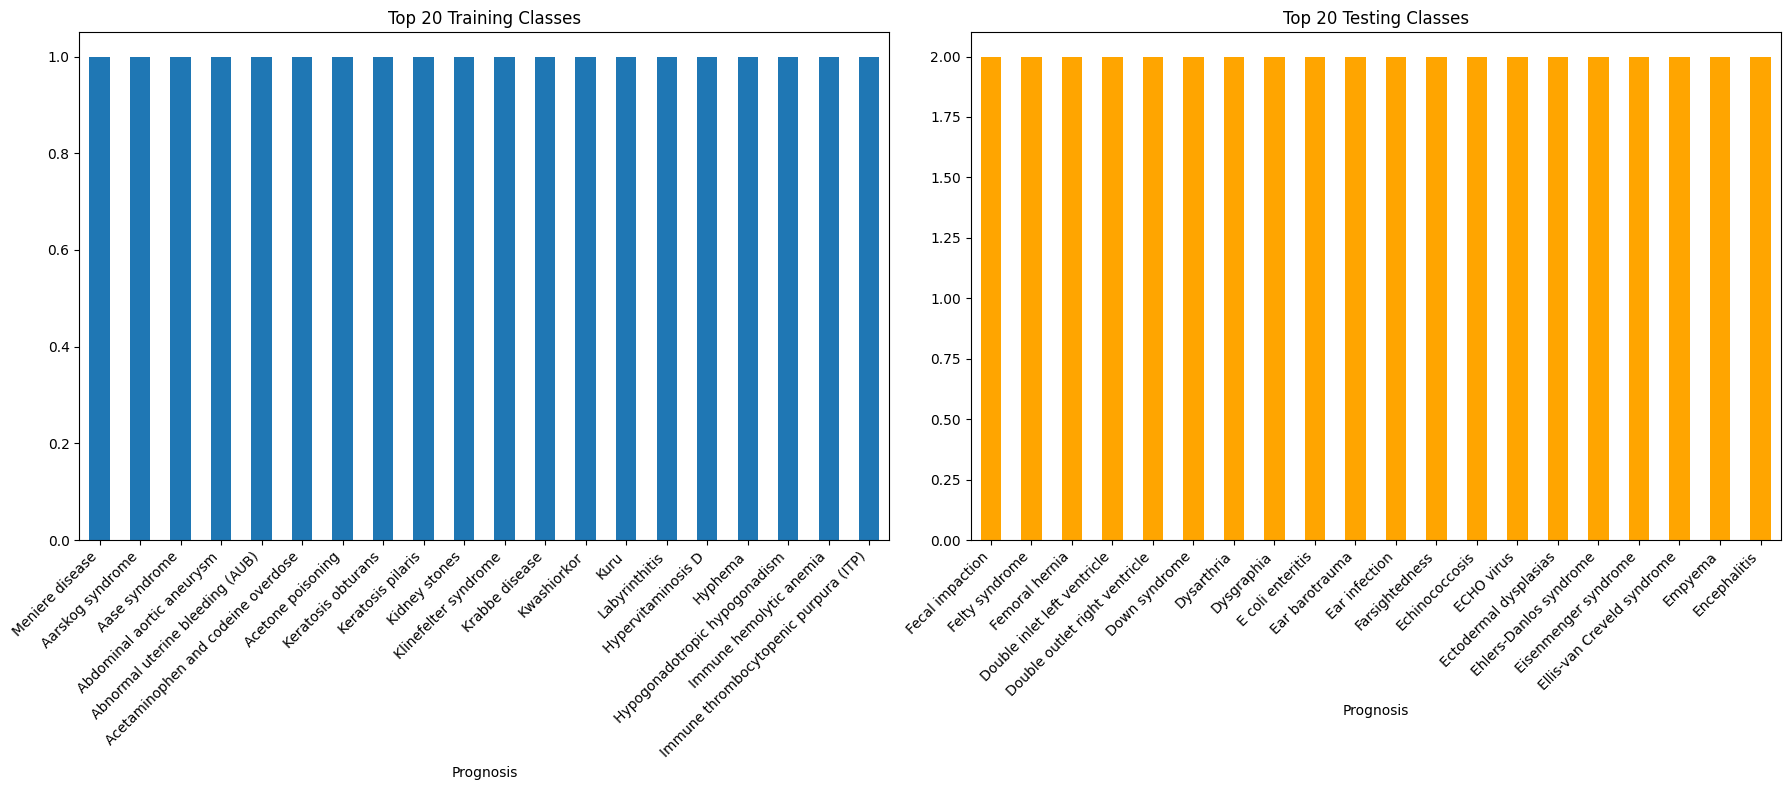


Tuberculosis Case Analysis:
Found 1 TB cases in training set

TB Symptom Annotations (13 symptoms):
1. Pain in the abdomen
2. Cough
3. Unintentional weight loss
4. Shortness of breath
5. Excessive sweating
6. Joint pain
7. fever
8. Fever-- usually low-grade
9. Swelling of abdomen
10. Malaise(general discomfortness,ill feeling or uneasiness)
11. Chills
12. Pale skin due to anemia (pallor)
13. Swollen glands


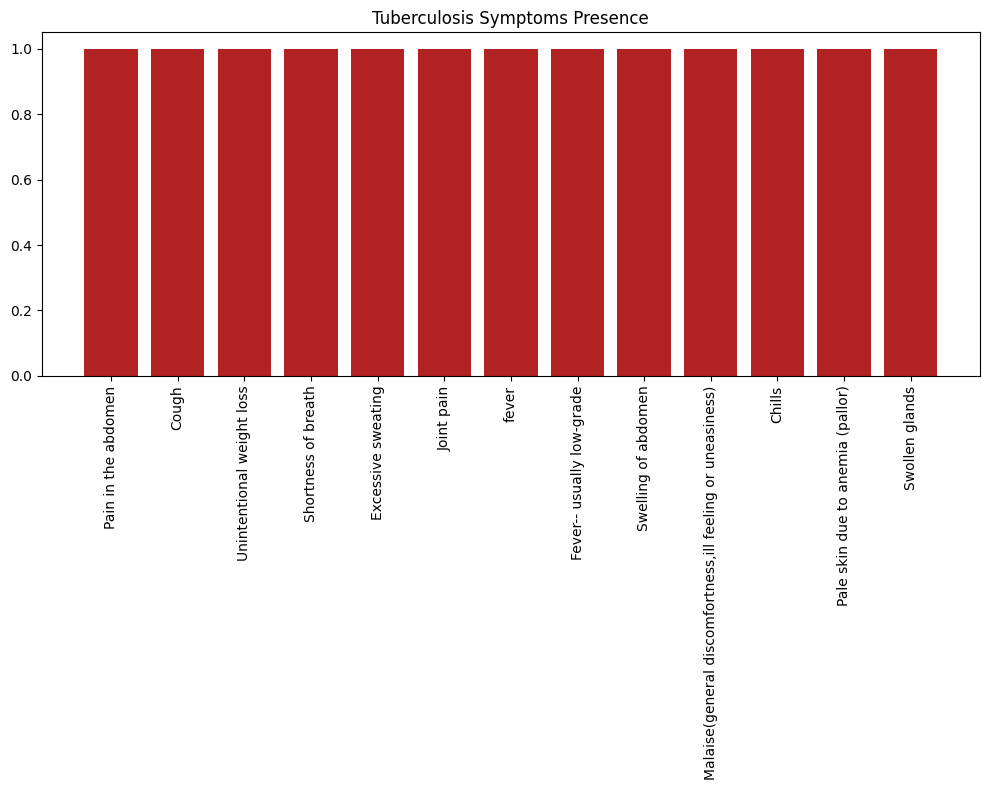


Binary Classification Dataset:
Training set: (391, 1326), Positive TB cases: 1
Testing set: (414, 1326), Positive TB cases: 1


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


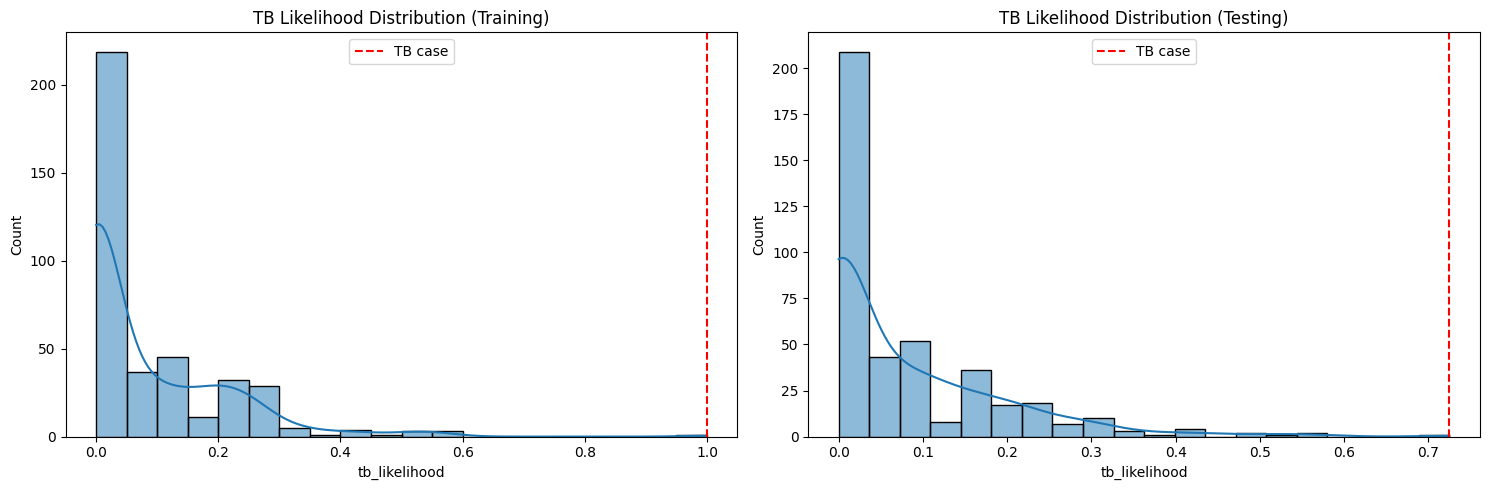


Diseases with TB-like symptoms:
                        Prognosis  tb_likelihood
88             Atypical pneumonia          0.575
337  Hypersensitivity pneumonitis          0.550
80                  Aspergillosis          0.550
48           Amebic liver abscess          0.525
168                 CMV pneumonia          0.525
230                       Empyema          0.500
86                  Atrial myxoma          0.475
122                 Bronchiolitis          0.425
59                        Anthrax          0.425
157  Chronic lymphocytic leukemia          0.425

TB-focused dataset dimensions:
Training: (391, 13)
Testing: (414, 13)

Sample TB-focused data:


Pain in the abdomen  Cough  Unintentional weight loss  Shortness of breath  \
0                    0      0                          0                    0   
1                    0      0                          0                    0   

   Excessive sweating  Joint pain  fever  Fever-- usually low-grade  \
0                   0           0      0                          0   
1                   0           0      0                          0   

   Swelling of abdomen  \
0                    0   
1                    0   

   Malaise(general discomfortness,ill feeling or uneasiness)  Chills  \
0                                                  0               0   
1                                                  0               0   

   Pale skin due to anemia (pallor)  Swollen glands  
0                                 0               0  
1                                 0               0


Dataset Summary:
- Full dataset contains 391 training and 414 test samples
- Each sample has 1326 symptom features
- TB case identified: 'Disseminated tuberculosis' with 13 characteristic symptoms
- TB likelihood scores calculated based on weighted symptom presence
- Binary classification task: Distinguishing TB from 390 other diseases


In [11]:

try:
    if os.path.exists('/kaggle/input/disease-prediction-using-symptoms/trainings.csv'):
        train_symptoms = pd.read_csv('/kaggle/input/disease-prediction-using-symptoms/trainings.csv', encoding='windows-1252')
        test_symptoms = pd.read_csv('/kaggle/input/disease-prediction-using-symptoms/testing.csv', encoding='windows-1252')
    else:
        train_symptoms = pd.read_csv('trainings.csv', encoding='windows-1252')
        test_symptoms = pd.read_csv('testing.csv', encoding='windows-1252')
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")


print("\nSymptoms Dataset Details")
print(f"Training Samples: {len(train_symptoms)}")
print(f"Test Samples: {len(test_symptoms)}")
print(f"Number of Classes: {train_symptoms['Prognosis'].nunique()}")
print(f"Number of Symptoms: {len(train_symptoms.columns[:-1])}")


print("\nSample Entries:")
display(train_symptoms.head(2))


is_one_to_one = len(train_symptoms) == train_symptoms['Prognosis'].nunique()
print(f"\nEach row represents a unique disease: {is_one_to_one}")

# Visualize class distribution
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
train_count = train_symptoms['Prognosis'].value_counts().head(20)
train_count.plot(kind='bar', title='Top 20 Training Classes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.subplot(1, 2, 2)
test_count = test_symptoms['Prognosis'].value_counts().head(20)
test_count.plot(kind='bar', title='Top 20 Testing Classes', color='orange')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('class_distribution.png', bbox_inches='tight', dpi=300)
plt.show()


print("\nTuberculosis Case Analysis:")
tb_train = train_symptoms[train_symptoms['Prognosis'] == 'Disseminated tuberculosis']
tb_test = test_symptoms[test_symptoms['Prognosis'] == 'Disseminated tuberculosis']

if len(tb_train) > 0:
    print(f"Found {len(tb_train)} TB cases in training set")

    tb_symptoms = tb_train.iloc[0, :-1][tb_train.iloc[0, :-1] == 1].index.tolist()
    print(f"\nTB Symptom Annotations ({len(tb_symptoms)} symptoms):")
    for i, symptom in enumerate(tb_symptoms):
        print(f"{i+1}. {symptom}")

    plt.figure(figsize=(10, 8))
    plt.bar(range(len(tb_symptoms)), [1] * len(tb_symptoms), color='firebrick')
    plt.xticks(range(len(tb_symptoms)), tb_symptoms, rotation=90)
    plt.title('Tuberculosis Symptoms Presence')
    plt.tight_layout()
    plt.savefig('tb_symptoms.png', bbox_inches='tight', dpi=300)
    plt.show()
else:
    print("No tuberculosis cases found in training set.")

# Create binary TB classification dataset
def create_binary_dataset(original_df, target_disease='Disseminated tuberculosis'):
    df = original_df.copy()
    df['is_tb'] = (df['Prognosis'] == target_disease).astype(int)
    X = df.iloc[:, :-2]
    y = df['is_tb']
    return X, y

X_train, y_train = create_binary_dataset(train_symptoms)
X_test, y_test = create_binary_dataset(test_symptoms)

print(f"\nBinary Classification Dataset:")
print(f"Training set: {X_train.shape}, Positive TB cases: {y_train.sum()}")
print(f"Testing set: {X_test.shape}, Positive TB cases: {y_test.sum()}")


def calculate_tb_likelihood(df, tb_symptoms_list, weights=None):
    if weights is None:
        weights = {symptom: 1 for symptom in tb_symptoms_list}
    else:
        for symptom in tb_symptoms_list:
            if symptom not in weights:
                weights[symptom] = 1
    weighted_sum = sum(df[symptom] * weights[symptom] for symptom in tb_symptoms_list)
    max_possible = sum(weights.values())
    return weighted_sum / max_possible


tb_symptom_weights = {
    'Cough': 3,
    'Unintentional weight loss': 2.5,
    'Fever-- usually low-grade': 2,
    'fever': 2,
    'Excessive sweating': 2,
    'Shortness of breath': 1.5
}

train_symptoms['tb_likelihood'] = train_symptoms.apply(
    lambda row: calculate_tb_likelihood(row, tb_symptoms, tb_symptom_weights), 
    axis=1
)

test_symptoms['tb_likelihood'] = test_symptoms.apply(
    lambda row: calculate_tb_likelihood(row, tb_symptoms, tb_symptom_weights), 
    axis=1
)


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_symptoms['tb_likelihood'], bins=20, kde=True)
plt.axvline(train_symptoms[train_symptoms['Prognosis'] == 'Disseminated tuberculosis']['tb_likelihood'].values[0], 
            color='r', linestyle='--', label='TB case')
plt.title('TB Likelihood Distribution (Training)')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(test_symptoms['tb_likelihood'], bins=20, kde=True)
plt.axvline(test_symptoms[test_symptoms['Prognosis'] == 'Disseminated tuberculosis']['tb_likelihood'].values[0], 
            color='r', linestyle='--', label='TB case')
plt.title('TB Likelihood Distribution (Testing)')
plt.legend()
plt.tight_layout()
plt.savefig('tb_likelihood.png', bbox_inches='tight', dpi=300)
plt.show()


high_tb_score = train_symptoms[train_symptoms['Prognosis'] != 'Disseminated tuberculosis']
high_tb_score = high_tb_score.sort_values('tb_likelihood', ascending=False).head(10)
print("\nDiseases with TB-like symptoms:")
print(high_tb_score[['Prognosis', 'tb_likelihood']])


X_train_tb_focused, y_train_tb = X_train[tb_symptoms], y_train
X_test_tb_focused, y_test_tb = X_test[tb_symptoms], y_test

print(f"\nTB-focused dataset dimensions:")
print(f"Training: {X_train_tb_focused.shape}")
print(f"Testing: {X_test_tb_focused.shape}")


print("\nSample TB-focused data:")
display(X_train_tb_focused.head(2))


print("\nDataset Summary:")
print(f"- Full dataset contains {len(train_symptoms)} training and {len(test_symptoms)} test samples")
print(f"- Each sample has {len(train_symptoms.columns[:-2])} symptom features")
print(f"- TB case identified: 'Disseminated tuberculosis' with {len(tb_symptoms)} characteristic symptoms")
print(f"- TB likelihood scores calculated based on weighted symptom presence")
print(f"- Binary classification task: Distinguishing TB from {train_symptoms['Prognosis'].nunique()-1} other diseases")



# Chest X-ray Dataset



 Dataset Information:
Total number of images: 4200
Class distribution:
label
Normal          3500
Tuberculosis     700
Name: count, dtype: int64


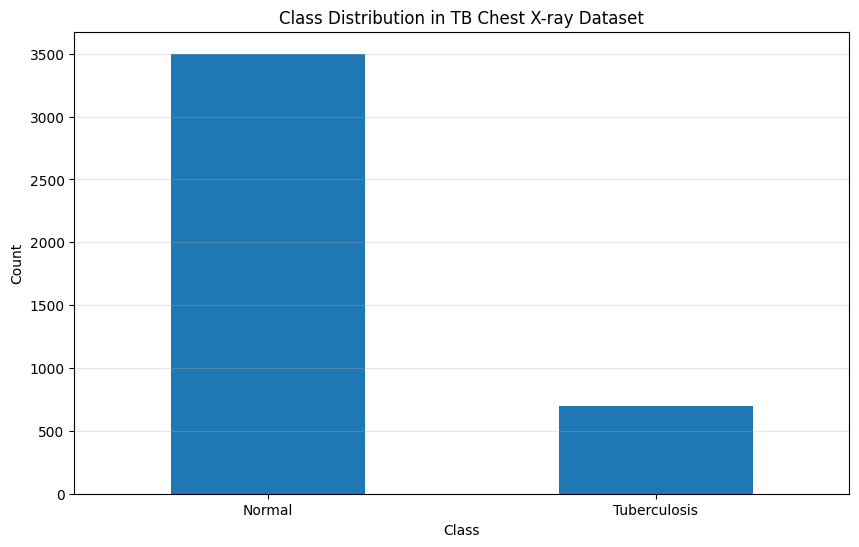

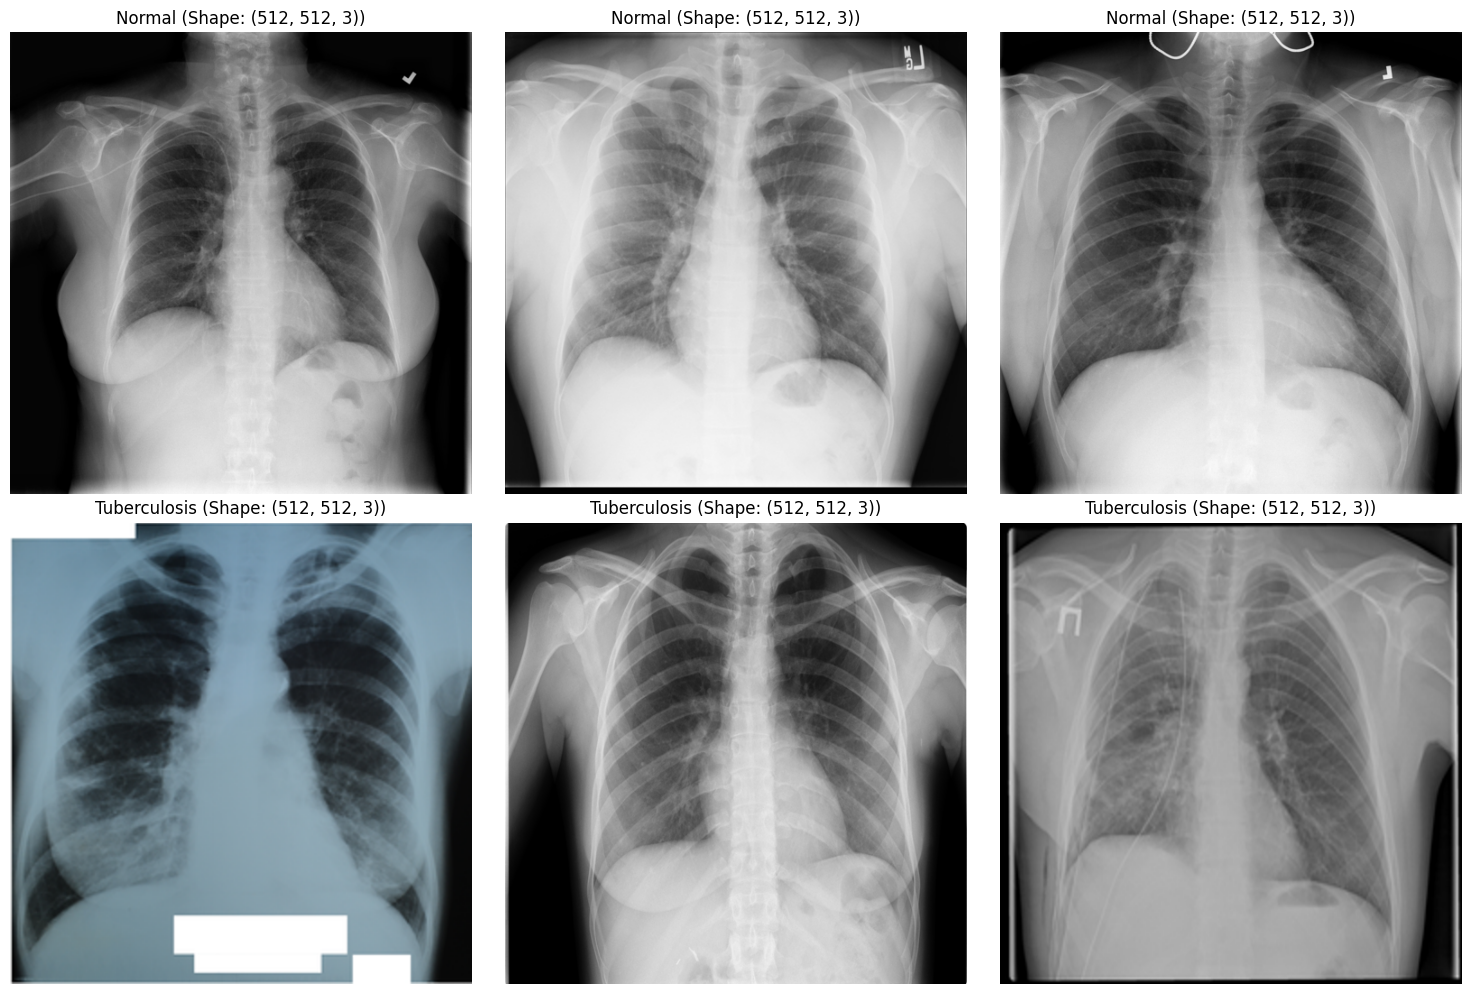


 Train/Test Split:
Training set: 3360 images
Testing set: 840 images

Class distribution in training set:
label
Normal          2800
Tuberculosis     560
Name: count, dtype: int64

Class distribution in testing set:
label
Normal          700
Tuberculosis    140
Name: count, dtype: int64
Analyzing 100 sample images...

 Image Statistics:
Height (pixels): Mean=512.0, Std=0.0
Width (pixels): Mean=512.0, Std=0.0
Aspect Ratio: Mean=1.000

 Analyzing class features...


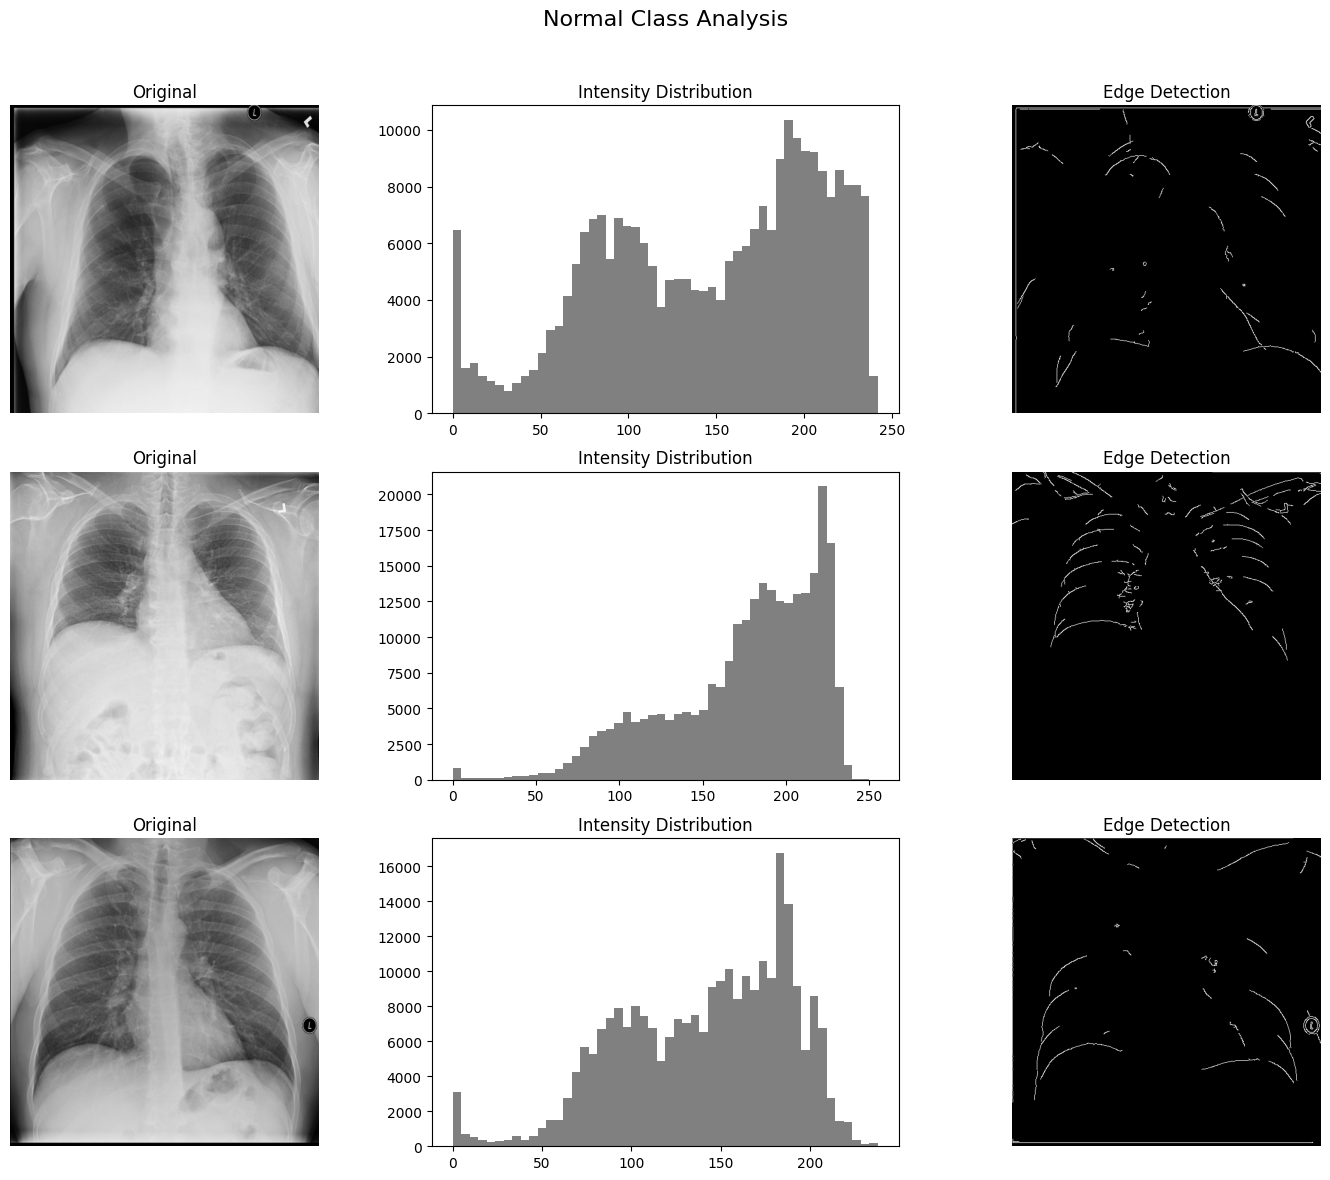

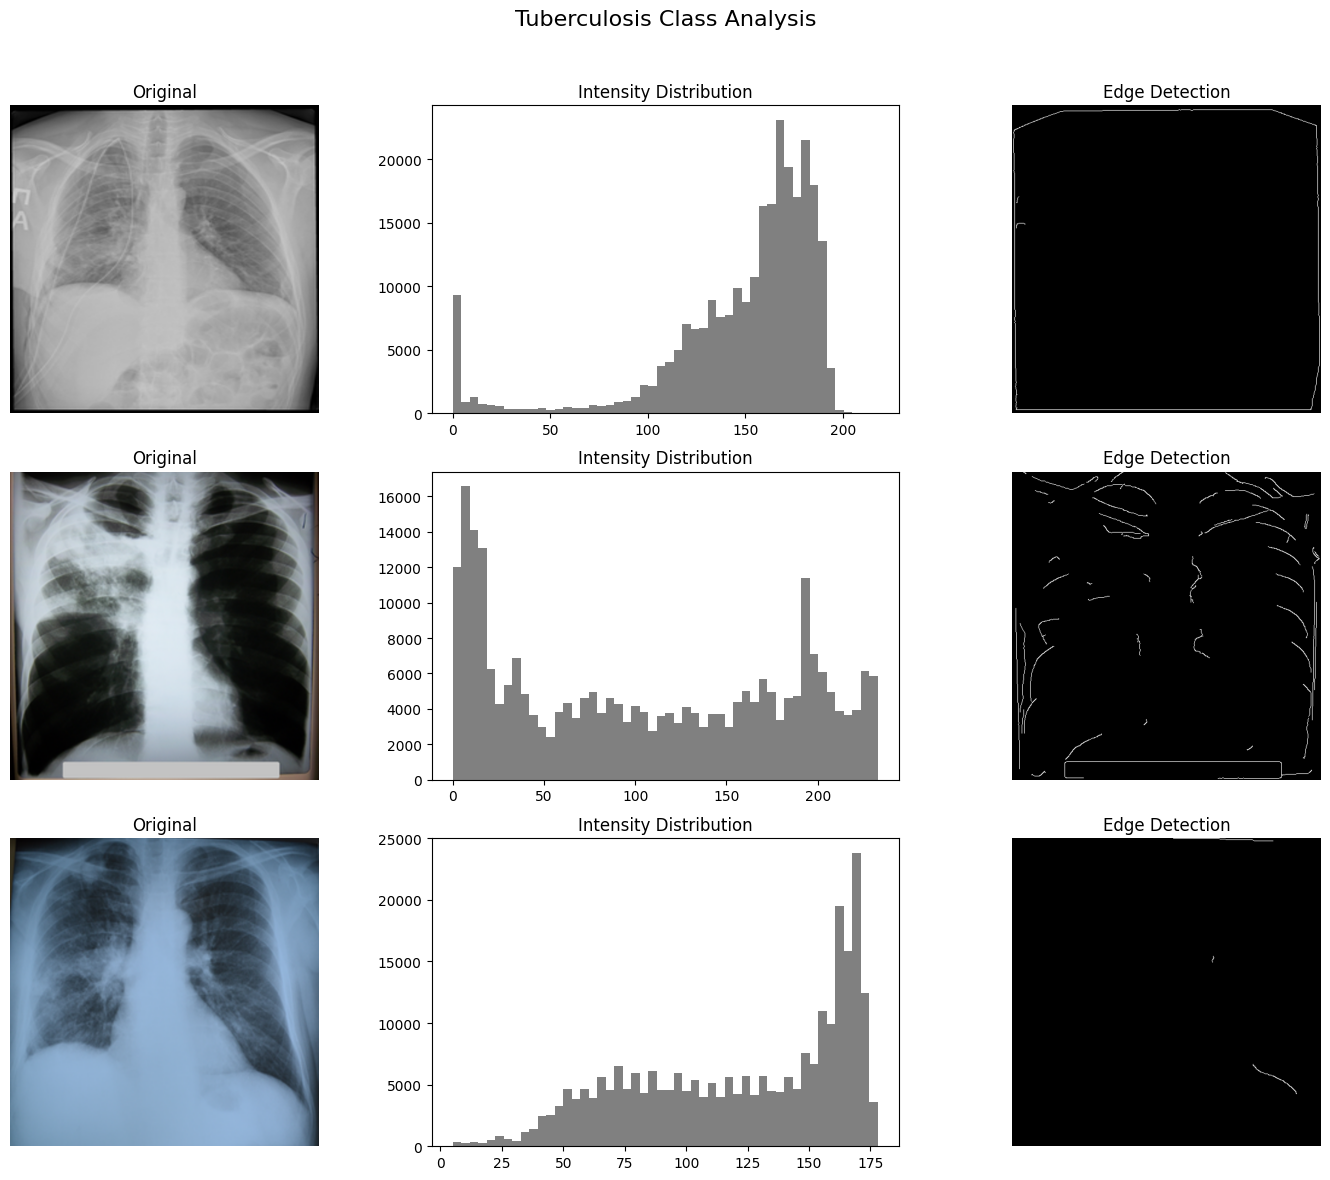

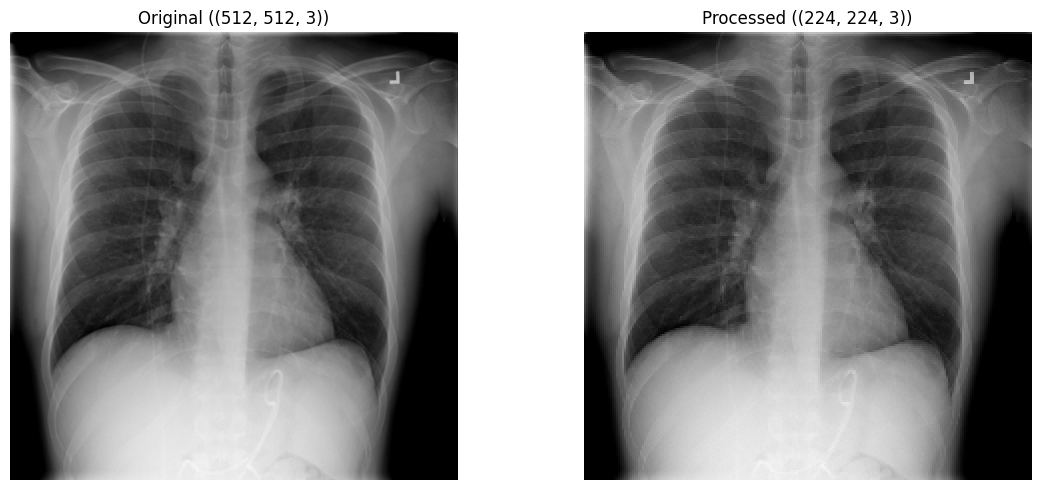

In [30]:

base_path = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database'
normal_path = os.path.join(base_path, 'Normal')
tb_path = os.path.join(base_path, 'Tuberculosis')

def create_dataset_df(normal_dir, tb_dir):
    normal_files = glob(os.path.join(normal_dir, '*.png'))
    tb_files = glob(os.path.join(tb_dir, '*.png'))
    
    files = normal_files + tb_files
    labels = ['Normal'] * len(normal_files) + ['Tuberculosis'] * len(tb_files)
    
    return pd.DataFrame({
        'image_path': files,
        'label': labels
    })


if os.path.exists(normal_path) and os.path.exists(tb_path):
    df = create_dataset_df(normal_path, tb_path)
    
    print("\n Dataset Information:")
    print(f"Total number of images: {len(df)}")
    print(f"Class distribution:\n{df['label'].value_counts()}")
    plt.figure(figsize=(10, 6))
    df['label'].value_counts().plot(kind='bar')
    plt.title('Class Distribution in TB Chest X-ray Dataset')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    plt.figure(figsize=(15, 10))
    for i, label in enumerate(['Normal', 'Tuberculosis']):
        sample_paths = df[df['label'] == label]['image_path'].sample(min(3, len(df[df['label'] == label]))).tolist()
        
        for j, path in enumerate(sample_paths):
            plt.subplot(2, 3, i*3 + j + 1)
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f"{label} (Shape: {img.shape})")
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    
   # split the dataset into train and test
    train_df, test_df = train_test_split(
        df, 
        test_size=0.2, 
        random_state=42,
        stratify=df['label']  
    )
    
    print("\n Train/Test Split:")
    print(f"Training set: {len(train_df)} images")
    print(f"Testing set: {len(test_df)} images")
    print("\nClass distribution in training set:")
    print(train_df['label'].value_counts())
    print("\nClass distribution in testing set:")
    print(test_df['label'].value_counts())
    
    # Image statistics analysis
    def analyze_image_statistics(dataframe):
        heights = []
        widths = []
        aspects = []
        
        sample_size = min(100, len(dataframe))
        sample_df = dataframe.sample(sample_size)
        print(f"Analyzing {sample_size} sample images...")
        for path in sample_df['image_path']:
            try:
                img = cv2.imread(path)
                if img is not None:
                    h, w = img.shape[:2]
                    heights.append(h)
                    widths.append(w)
                    aspects.append(w/h)
            except Exception as e:
                print(f"Error processing image {path}: {e}")
        
        return {
            'height': {'mean': np.mean(heights), 'std': np.std(heights)},
            'width': {'mean': np.mean(widths), 'std': np.std(widths)},
            'aspect_ratio': {'mean': np.mean(aspects), 'std': np.std(aspects)}
        }
    
    # Analyze image statistics
    stats = analyze_image_statistics(df)
    print("\n Image Statistics:")
    print(f"Height (pixels): Mean={stats['height']['mean']:.1f}, Std={stats['height']['std']:.1f}")
    print(f"Width (pixels): Mean={stats['width']['mean']:.1f}, Std={stats['width']['std']:.1f}")
    print(f"Aspect Ratio: Mean={stats['aspect_ratio']['mean']:.3f}")
    
    # Class-specific image analysis
    def analyze_class_features(label, num_samples=3):
        class_df = df[df['label'] == label]
        sample_paths = class_df['image_path'].sample(num_samples).tolist()
        plt.figure(figsize=(15, 12))
        for i, path in enumerate(sample_paths):
            plt.subplot(num_samples, 3, i*3 + 1)
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f"Original")
            plt.axis('off')
            plt.subplot(num_samples, 3, i*3 + 2)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            plt.hist(gray.ravel(), bins=50, color='gray')
            plt.title(f"Intensity Distribution")
            plt.subplot(num_samples, 3, i*3 + 3)
            edges = cv2.Canny(gray, 100, 200)
            plt.imshow(edges, cmap='gray')
            plt.title(f"Edge Detection")
            plt.axis('off')
            
        plt.suptitle(f"{label} Class Analysis", fontsize=16, y=0.98)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()
    
    print("\n Analyzing class features...")
    analyze_class_features('Normal')
    analyze_class_features('Tuberculosis')
    def preprocess_for_model(image_path, target_size=(224, 224)):
        """Preprocess an image for model training"""
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        img = img / 255.0  # Normalize to [0,1]
        return img
    
    #  preprocessing
    sample_img_path = df['image_path'].iloc[0]
    original_img = cv2.imread(sample_img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    processed_img = preprocess_for_model(sample_img_path)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title(f"Original ({original_img.shape})")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(processed_img)
    plt.title(f"Processed ({processed_img.shape})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    

In [5]:
!pip install transformers timm torch torchvision scikit-learn opencv-python matplotlib pandas numpy tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.2 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.

Using device: cuda:0
GPU Memory Allocated: 0.00 GB
GPU Memory Reserved: 0.00 GB
Creating dataset dataframe...

Dataset Information:
Total number of images: 4200
Class distribution:
label
Normal          3500
Tuberculosis     700
Name: count, dtype: int64

Train/Test Split:
Training set: 3360 images
Testing set: 840 images
Loading pretrained chest X-ray segmentation model...


config.json:   0%|          | 0.00/708 [00:00<?, ?B/s]

configuration.py:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ianpan/chest-x-ray-basic:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py:   0%|          | 0.00/3.33k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


unet.py:   0%|          | 0.00/7.50k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ianpan/chest-x-ray-basic:
- unet.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ianpan/chest-x-ray-basic:
- modeling.py
- unet.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
2025-04-28 16:59:11.636387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745859551.827657      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745859551.880237      31 cuda_blas.cc:1418] Unable to re

model.safetensors:   0%|          | 0.00/89.1M [00:00<?, ?B/s]

Successfully loaded pretrained segmentation model
Pre-processing and caching segmented images...


100%|██████████| 3360/3360 [02:49<00:00, 19.86it/s]


Processed 3360 images. Cached at /kaggle/working/segmented_cache/
Pre-processing and caching segmented images...


100%|██████████| 840/840 [00:42<00:00, 19.92it/s]


Processed 840 images. Cached at /kaggle/working/segmented_cache/
GPU Memory Allocated: 0.01 GB
GPU Memory Reserved: 0.02 GB

Creating data loaders with pre-segmented lung images...


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 181MB/s]



===== Training DenseNet201 with Segmented Lungs =====
GPU Memory Allocated: 0.01 GB
GPU Memory Reserved: 0.02 GB


Epoch 1/15:   0%|          | 0/420 [00:00<?, ?it/s]

GPU Memory Allocated: 0.08 GB
GPU Memory Reserved: 0.09 GB


Epoch 1/15:   3%|▎         | 13/420 [00:01<00:25, 15.89it/s]

Batch 10, Loss: 0.3514, Running Acc: 78.75%


Epoch 1/15:   5%|▌         | 23/420 [00:01<00:23, 17.17it/s]

Batch 20, Loss: 0.5291, Running Acc: 78.12%


Epoch 1/15:   8%|▊         | 33/420 [00:02<00:22, 17.26it/s]

Batch 30, Loss: 0.4427, Running Acc: 77.08%


Epoch 1/15:  10%|█         | 43/420 [00:02<00:21, 17.78it/s]

Batch 40, Loss: 0.5430, Running Acc: 76.56%


Epoch 1/15:  13%|█▎        | 53/420 [00:03<00:21, 17.47it/s]

Batch 50, Loss: 1.2577, Running Acc: 77.75%


Epoch 1/15:  15%|█▌        | 63/420 [00:03<00:20, 17.36it/s]

Batch 60, Loss: 0.4623, Running Acc: 78.12%


Epoch 1/15:  17%|█▋        | 73/420 [00:04<00:19, 17.61it/s]

Batch 70, Loss: 0.3046, Running Acc: 78.75%


Epoch 1/15:  20%|█▉        | 83/420 [00:05<00:19, 17.63it/s]

Batch 80, Loss: 0.1637, Running Acc: 79.38%


Epoch 1/15:  22%|██▏       | 93/420 [00:05<00:18, 17.68it/s]

Batch 90, Loss: 0.2890, Running Acc: 80.14%


Epoch 1/15:  25%|██▍       | 103/420 [00:06<00:17, 17.67it/s]

Batch 100, Loss: 0.0696, Running Acc: 80.88%


Epoch 1/15:  27%|██▋       | 113/420 [00:06<00:18, 17.05it/s]

Batch 110, Loss: 0.4173, Running Acc: 81.25%


Epoch 1/15:  29%|██▉       | 123/420 [00:07<00:16, 17.53it/s]

Batch 120, Loss: 0.5357, Running Acc: 81.88%


Epoch 1/15:  32%|███▏      | 133/420 [00:07<00:16, 17.68it/s]

Batch 130, Loss: 0.1446, Running Acc: 82.21%


Epoch 1/15:  34%|███▍      | 143/420 [00:08<00:16, 16.63it/s]

Batch 140, Loss: 0.3557, Running Acc: 82.50%


Epoch 1/15:  36%|███▋      | 153/420 [00:09<00:15, 17.34it/s]

Batch 150, Loss: 0.3863, Running Acc: 82.67%


Epoch 1/15:  39%|███▉      | 163/420 [00:09<00:14, 17.40it/s]

Batch 160, Loss: 0.0362, Running Acc: 83.20%


Epoch 1/15:  41%|████      | 173/420 [00:10<00:14, 17.44it/s]

Batch 170, Loss: 0.5922, Running Acc: 83.16%


Epoch 1/15:  44%|████▎     | 183/420 [00:10<00:13, 17.93it/s]

Batch 180, Loss: 0.5815, Running Acc: 83.47%


Epoch 1/15:  46%|████▌     | 193/420 [00:11<00:12, 17.95it/s]

Batch 190, Loss: 0.2602, Running Acc: 83.29%


Epoch 1/15:  48%|████▊     | 203/420 [00:11<00:12, 17.68it/s]

Batch 200, Loss: 0.3266, Running Acc: 83.62%


Epoch 1/15:  51%|█████     | 213/420 [00:12<00:11, 17.77it/s]

Batch 210, Loss: 0.1118, Running Acc: 83.81%


Epoch 1/15:  53%|█████▎    | 223/420 [00:13<00:11, 17.38it/s]

Batch 220, Loss: 0.2962, Running Acc: 83.81%


Epoch 1/15:  55%|█████▌    | 233/420 [00:13<00:10, 17.65it/s]

Batch 230, Loss: 0.5237, Running Acc: 83.91%


Epoch 1/15:  58%|█████▊    | 243/420 [00:14<00:10, 16.29it/s]

Batch 240, Loss: 0.7382, Running Acc: 83.85%


Epoch 1/15:  60%|██████    | 253/420 [00:14<00:09, 16.88it/s]

Batch 250, Loss: 0.4837, Running Acc: 83.80%


Epoch 1/15:  63%|██████▎   | 263/420 [00:15<00:09, 17.21it/s]

Batch 260, Loss: 0.1202, Running Acc: 83.51%


Epoch 1/15:  65%|██████▌   | 273/420 [00:15<00:08, 17.57it/s]

Batch 270, Loss: 1.3121, Running Acc: 83.75%


Epoch 1/15:  67%|██████▋   | 283/420 [00:16<00:07, 17.60it/s]

Batch 280, Loss: 0.1684, Running Acc: 83.88%


Epoch 1/15:  70%|██████▉   | 293/420 [00:17<00:07, 17.72it/s]

Batch 290, Loss: 0.1276, Running Acc: 83.62%


Epoch 1/15:  72%|███████▏  | 303/420 [00:17<00:06, 17.73it/s]

Batch 300, Loss: 0.1584, Running Acc: 83.79%


Epoch 1/15:  75%|███████▍  | 313/420 [00:18<00:06, 17.14it/s]

Batch 310, Loss: 0.4026, Running Acc: 83.87%


Epoch 1/15:  77%|███████▋  | 323/420 [00:18<00:05, 17.27it/s]

Batch 320, Loss: 0.2750, Running Acc: 84.02%


Epoch 1/15:  79%|███████▉  | 333/420 [00:19<00:04, 17.65it/s]

Batch 330, Loss: 0.5531, Running Acc: 84.13%


Epoch 1/15:  82%|████████▏ | 343/420 [00:19<00:04, 17.73it/s]

Batch 340, Loss: 0.1266, Running Acc: 84.30%


Epoch 1/15:  84%|████████▍ | 353/420 [00:20<00:03, 17.33it/s]

Batch 350, Loss: 0.1812, Running Acc: 84.39%


Epoch 1/15:  86%|████████▋ | 363/420 [00:21<00:03, 16.25it/s]

Batch 360, Loss: 0.4536, Running Acc: 84.44%


Epoch 1/15:  89%|████████▉ | 373/420 [00:21<00:02, 16.77it/s]

Batch 370, Loss: 0.0702, Running Acc: 84.73%


Epoch 1/15:  91%|█████████ | 383/420 [00:22<00:02, 17.21it/s]

Batch 380, Loss: 0.1768, Running Acc: 84.77%


Epoch 1/15:  94%|█████████▎| 393/420 [00:22<00:01, 17.56it/s]

Batch 390, Loss: 0.3370, Running Acc: 84.84%


Epoch 1/15:  96%|█████████▌| 403/420 [00:23<00:00, 17.69it/s]

Batch 400, Loss: 0.2607, Running Acc: 84.84%


Epoch 1/15:  98%|█████████▊| 413/420 [00:24<00:00, 17.70it/s]

Batch 410, Loss: 0.3785, Running Acc: 84.88%


Epoch 1/15: 100%|██████████| 420/420 [00:24<00:00, 17.20it/s]


Batch 420, Loss: 0.6647, Running Acc: 84.79%
Epoch 1/15, Loss: 0.3741, Accuracy: 84.79%, Time: 24.4s
Saved best model checkpoint


Epoch 2/15:   0%|          | 2/420 [00:00<00:24, 17.25it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.11 GB


Epoch 2/15:   3%|▎         | 12/420 [00:00<00:23, 17.71it/s]

Batch 10, Loss: 0.2287, Running Acc: 86.25%


Epoch 2/15:   5%|▌         | 22/420 [00:01<00:22, 17.58it/s]

Batch 20, Loss: 0.9507, Running Acc: 87.50%


Epoch 2/15:   8%|▊         | 32/420 [00:01<00:22, 17.55it/s]

Batch 30, Loss: 0.3756, Running Acc: 86.67%


Epoch 2/15:  10%|█         | 42/420 [00:02<00:21, 17.57it/s]

Batch 40, Loss: 0.4516, Running Acc: 85.31%


Epoch 2/15:  12%|█▏        | 52/420 [00:02<00:20, 17.85it/s]

Batch 50, Loss: 0.2812, Running Acc: 85.50%


Epoch 2/15:  15%|█▍        | 62/420 [00:03<00:21, 16.53it/s]

Batch 60, Loss: 2.1972, Running Acc: 85.83%


Epoch 2/15:  17%|█▋        | 72/420 [00:04<00:19, 17.45it/s]

Batch 70, Loss: 0.1738, Running Acc: 85.89%


Epoch 2/15:  20%|█▉        | 82/420 [00:04<00:19, 17.51it/s]

Batch 80, Loss: 0.6784, Running Acc: 85.16%


Epoch 2/15:  22%|██▏       | 92/420 [00:05<00:18, 17.70it/s]

Batch 90, Loss: 0.1243, Running Acc: 85.69%


Epoch 2/15:  24%|██▍       | 102/420 [00:05<00:17, 18.01it/s]

Batch 100, Loss: 0.2361, Running Acc: 85.88%


Epoch 2/15:  27%|██▋       | 112/420 [00:06<00:17, 17.50it/s]

Batch 110, Loss: 0.1560, Running Acc: 86.14%


Epoch 2/15:  29%|██▉       | 122/420 [00:06<00:16, 17.53it/s]

Batch 120, Loss: 0.6388, Running Acc: 86.15%


Epoch 2/15:  31%|███▏      | 132/420 [00:07<00:16, 17.52it/s]

Batch 130, Loss: 0.0829, Running Acc: 86.35%


Epoch 2/15:  34%|███▍      | 142/420 [00:08<00:15, 17.82it/s]

Batch 140, Loss: 0.7275, Running Acc: 86.43%


Epoch 2/15:  36%|███▌      | 152/420 [00:08<00:14, 17.97it/s]

Batch 150, Loss: 0.6421, Running Acc: 86.50%


Epoch 2/15:  39%|███▊      | 162/420 [00:09<00:14, 17.84it/s]

Batch 160, Loss: 0.0807, Running Acc: 86.72%


Epoch 2/15:  41%|████      | 172/420 [00:09<00:13, 17.79it/s]

Batch 170, Loss: 0.0918, Running Acc: 86.76%


Epoch 2/15:  43%|████▎     | 182/420 [00:10<00:13, 17.21it/s]

Batch 180, Loss: 0.5384, Running Acc: 86.88%


Epoch 2/15:  46%|████▌     | 192/420 [00:10<00:12, 17.67it/s]

Batch 190, Loss: 0.6762, Running Acc: 86.84%


Epoch 2/15:  48%|████▊     | 202/420 [00:11<00:12, 17.55it/s]

Batch 200, Loss: 0.0712, Running Acc: 86.88%


Epoch 2/15:  50%|█████     | 212/420 [00:12<00:11, 17.56it/s]

Batch 210, Loss: 0.2936, Running Acc: 86.90%


Epoch 2/15:  53%|█████▎    | 222/420 [00:12<00:11, 17.49it/s]

Batch 220, Loss: 0.6925, Running Acc: 86.48%


Epoch 2/15:  55%|█████▌    | 232/420 [00:13<00:10, 17.53it/s]

Batch 230, Loss: 1.3077, Running Acc: 86.58%


Epoch 2/15:  58%|█████▊    | 242/420 [00:13<00:10, 16.79it/s]

Batch 240, Loss: 0.4823, Running Acc: 86.41%


Epoch 2/15:  60%|██████    | 252/420 [00:14<00:09, 17.72it/s]

Batch 250, Loss: 0.1417, Running Acc: 86.30%


Epoch 2/15:  62%|██████▏   | 262/420 [00:14<00:08, 17.81it/s]

Batch 260, Loss: 0.2247, Running Acc: 86.54%


Epoch 2/15:  65%|██████▍   | 272/420 [00:15<00:08, 17.71it/s]

Batch 270, Loss: 0.5105, Running Acc: 86.25%


Epoch 2/15:  67%|██████▋   | 282/420 [00:16<00:07, 17.69it/s]

Batch 280, Loss: 0.0925, Running Acc: 86.34%


Epoch 2/15:  70%|██████▉   | 292/420 [00:16<00:07, 17.78it/s]

Batch 290, Loss: 0.1290, Running Acc: 86.51%


Epoch 2/15:  72%|███████▏  | 302/420 [00:17<00:06, 17.87it/s]

Batch 300, Loss: 0.3789, Running Acc: 86.54%


Epoch 2/15:  74%|███████▍  | 312/420 [00:17<00:06, 17.76it/s]

Batch 310, Loss: 0.0796, Running Acc: 86.69%


Epoch 2/15:  77%|███████▋  | 322/420 [00:18<00:05, 17.35it/s]

Batch 320, Loss: 0.0663, Running Acc: 86.80%


Epoch 2/15:  79%|███████▉  | 332/420 [00:18<00:05, 17.25it/s]

Batch 330, Loss: 0.2798, Running Acc: 86.78%


Epoch 2/15:  81%|████████▏ | 342/420 [00:19<00:04, 17.63it/s]

Batch 340, Loss: 0.5731, Running Acc: 86.73%


Epoch 2/15:  84%|████████▍ | 352/420 [00:20<00:03, 17.70it/s]

Batch 350, Loss: 0.1676, Running Acc: 86.64%


Epoch 2/15:  86%|████████▌ | 362/420 [00:20<00:03, 17.63it/s]

Batch 360, Loss: 0.2072, Running Acc: 86.39%


Epoch 2/15:  89%|████████▊ | 372/420 [00:21<00:02, 17.30it/s]

Batch 370, Loss: 0.7313, Running Acc: 86.32%


Epoch 2/15:  91%|█████████ | 382/420 [00:21<00:02, 17.46it/s]

Batch 380, Loss: 0.1727, Running Acc: 86.35%


Epoch 2/15:  93%|█████████▎| 392/420 [00:22<00:01, 17.73it/s]

Batch 390, Loss: 0.1166, Running Acc: 86.41%


Epoch 2/15:  96%|█████████▌| 402/420 [00:22<00:01, 17.75it/s]

Batch 400, Loss: 0.4874, Running Acc: 86.38%


Epoch 2/15:  98%|█████████▊| 412/420 [00:23<00:00, 17.28it/s]

Batch 410, Loss: 0.1401, Running Acc: 86.40%


Epoch 2/15: 100%|██████████| 420/420 [00:23<00:00, 17.55it/s]


Batch 420, Loss: 0.3415, Running Acc: 86.52%
Epoch 2/15, Loss: 0.3792, Accuracy: 86.52%, Time: 23.9s


Epoch 3/15:   0%|          | 0/420 [00:00<?, ?it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.11 GB


Epoch 3/15:   3%|▎         | 12/420 [00:00<00:22, 17.90it/s]

Batch 10, Loss: 0.7730, Running Acc: 85.00%


Epoch 3/15:   5%|▌         | 22/420 [00:01<00:22, 17.68it/s]

Batch 20, Loss: 0.5032, Running Acc: 82.50%


Epoch 3/15:   8%|▊         | 32/420 [00:01<00:21, 17.91it/s]

Batch 30, Loss: 0.0483, Running Acc: 84.17%


Epoch 3/15:  10%|█         | 42/420 [00:02<00:21, 17.62it/s]

Batch 40, Loss: 0.9750, Running Acc: 85.31%


Epoch 3/15:  12%|█▏        | 52/420 [00:02<00:20, 17.81it/s]

Batch 50, Loss: 0.2578, Running Acc: 86.50%


Epoch 3/15:  15%|█▍        | 62/420 [00:03<00:20, 17.63it/s]

Batch 60, Loss: 0.6966, Running Acc: 85.83%


Epoch 3/15:  17%|█▋        | 72/420 [00:04<00:21, 16.36it/s]

Batch 70, Loss: 0.7266, Running Acc: 86.43%


Epoch 3/15:  20%|█▉        | 82/420 [00:04<00:20, 16.77it/s]

Batch 80, Loss: 0.0497, Running Acc: 87.03%


Epoch 3/15:  22%|██▏       | 92/420 [00:05<00:18, 17.46it/s]

Batch 90, Loss: 0.0858, Running Acc: 87.50%


Epoch 3/15:  24%|██▍       | 102/420 [00:05<00:17, 17.79it/s]

Batch 100, Loss: 0.5022, Running Acc: 87.12%


Epoch 3/15:  27%|██▋       | 112/420 [00:06<00:17, 17.47it/s]

Batch 110, Loss: 0.0305, Running Acc: 87.39%


Epoch 3/15:  29%|██▉       | 122/420 [00:07<00:16, 17.66it/s]

Batch 120, Loss: 0.2263, Running Acc: 87.29%


Epoch 3/15:  31%|███▏      | 132/420 [00:07<00:16, 17.72it/s]

Batch 130, Loss: 0.1947, Running Acc: 87.40%


Epoch 3/15:  34%|███▍      | 142/420 [00:08<00:16, 17.11it/s]

Batch 140, Loss: 0.9442, Running Acc: 87.23%


Epoch 3/15:  36%|███▌      | 152/420 [00:08<00:15, 17.46it/s]

Batch 150, Loss: 0.1772, Running Acc: 87.58%


Epoch 3/15:  39%|███▊      | 162/420 [00:09<00:14, 17.27it/s]

Batch 160, Loss: 0.3078, Running Acc: 88.05%


Epoch 3/15:  41%|████      | 172/420 [00:09<00:14, 17.20it/s]

Batch 170, Loss: 0.5106, Running Acc: 87.94%


Epoch 3/15:  43%|████▎     | 182/420 [00:10<00:13, 17.70it/s]

Batch 180, Loss: 0.1706, Running Acc: 87.85%


Epoch 3/15:  46%|████▌     | 192/420 [00:11<00:12, 17.86it/s]

Batch 190, Loss: 0.6973, Running Acc: 87.70%


Epoch 3/15:  48%|████▊     | 202/420 [00:11<00:12, 17.71it/s]

Batch 200, Loss: 0.4664, Running Acc: 87.50%


Epoch 3/15:  50%|█████     | 212/420 [00:12<00:11, 17.67it/s]

Batch 210, Loss: 0.1359, Running Acc: 87.44%


Epoch 3/15:  53%|█████▎    | 222/420 [00:12<00:11, 17.62it/s]

Batch 220, Loss: 0.4761, Running Acc: 87.50%


Epoch 3/15:  55%|█████▌    | 232/420 [00:13<00:10, 17.55it/s]

Batch 230, Loss: 0.5694, Running Acc: 87.39%


Epoch 3/15:  58%|█████▊    | 242/420 [00:13<00:10, 17.46it/s]

Batch 240, Loss: 0.6624, Running Acc: 87.08%


Epoch 3/15:  60%|██████    | 252/420 [00:14<00:09, 17.49it/s]

Batch 250, Loss: 0.0821, Running Acc: 87.10%


Epoch 3/15:  62%|██████▏   | 262/420 [00:15<00:09, 17.46it/s]

Batch 260, Loss: 0.2822, Running Acc: 87.21%


Epoch 3/15:  65%|██████▍   | 272/420 [00:15<00:08, 17.74it/s]

Batch 270, Loss: 0.1980, Running Acc: 87.22%


Epoch 3/15:  67%|██████▋   | 282/420 [00:16<00:07, 17.54it/s]

Batch 280, Loss: 0.6042, Running Acc: 86.92%


Epoch 3/15:  70%|██████▉   | 292/420 [00:16<00:07, 17.54it/s]

Batch 290, Loss: 0.2051, Running Acc: 86.85%


Epoch 3/15:  72%|███████▏  | 302/420 [00:17<00:06, 17.91it/s]

Batch 300, Loss: 0.1747, Running Acc: 86.88%


Epoch 3/15:  74%|███████▍  | 312/420 [00:17<00:06, 17.75it/s]

Batch 310, Loss: 0.1016, Running Acc: 86.77%


Epoch 3/15:  77%|███████▋  | 322/420 [00:18<00:05, 17.77it/s]

Batch 320, Loss: 0.5446, Running Acc: 86.80%


Epoch 3/15:  79%|███████▉  | 332/420 [00:18<00:04, 17.72it/s]

Batch 330, Loss: 0.4551, Running Acc: 86.78%


Epoch 3/15:  81%|████████▏ | 342/420 [00:19<00:04, 16.77it/s]

Batch 340, Loss: 0.0812, Running Acc: 86.91%


Epoch 3/15:  84%|████████▍ | 352/420 [00:20<00:03, 17.64it/s]

Batch 350, Loss: 0.0940, Running Acc: 86.79%


Epoch 3/15:  86%|████████▌ | 362/420 [00:20<00:03, 17.61it/s]

Batch 360, Loss: 0.1398, Running Acc: 86.94%


Epoch 3/15:  89%|████████▊ | 372/420 [00:21<00:02, 17.44it/s]

Batch 370, Loss: 0.1526, Running Acc: 87.03%


Epoch 3/15:  91%|█████████ | 382/420 [00:21<00:02, 17.56it/s]

Batch 380, Loss: 0.6181, Running Acc: 86.97%


Epoch 3/15:  93%|█████████▎| 392/420 [00:22<00:01, 17.62it/s]

Batch 390, Loss: 0.1708, Running Acc: 86.96%


Epoch 3/15:  96%|█████████▌| 402/420 [00:23<00:01, 17.50it/s]

Batch 400, Loss: 0.5036, Running Acc: 86.97%


Epoch 3/15:  98%|█████████▊| 412/420 [00:23<00:00, 17.55it/s]

Batch 410, Loss: 0.4508, Running Acc: 86.95%


Epoch 3/15: 100%|██████████| 420/420 [00:24<00:00, 17.49it/s]


Batch 420, Loss: 0.2350, Running Acc: 86.90%
Epoch 3/15, Loss: 0.3613, Accuracy: 86.90%, Time: 24.0s
Saved best model checkpoint


Epoch 4/15:   0%|          | 2/420 [00:00<00:23, 17.65it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.11 GB


Epoch 4/15:   3%|▎         | 12/420 [00:00<00:22, 17.75it/s]

Batch 10, Loss: 0.0810, Running Acc: 91.25%


Epoch 4/15:   5%|▌         | 22/420 [00:01<00:22, 17.64it/s]

Batch 20, Loss: 0.7961, Running Acc: 87.50%


Epoch 4/15:   8%|▊         | 32/420 [00:01<00:22, 17.56it/s]

Batch 30, Loss: 0.2101, Running Acc: 87.50%


Epoch 4/15:  10%|█         | 42/420 [00:02<00:21, 17.60it/s]

Batch 40, Loss: 0.2343, Running Acc: 85.94%


Epoch 4/15:  12%|█▏        | 52/420 [00:02<00:20, 17.55it/s]

Batch 50, Loss: 0.1584, Running Acc: 85.50%


Epoch 4/15:  15%|█▍        | 62/420 [00:03<00:20, 17.33it/s]

Batch 60, Loss: 0.1331, Running Acc: 86.25%


Epoch 4/15:  17%|█▋        | 72/420 [00:04<00:19, 17.44it/s]

Batch 70, Loss: 0.5384, Running Acc: 86.61%


Epoch 4/15:  20%|█▉        | 82/420 [00:04<00:19, 17.47it/s]

Batch 80, Loss: 0.1561, Running Acc: 87.19%


Epoch 4/15:  22%|██▏       | 92/420 [00:05<00:19, 17.10it/s]

Batch 90, Loss: 0.7849, Running Acc: 86.81%


Epoch 4/15:  24%|██▍       | 102/420 [00:05<00:18, 17.23it/s]

Batch 100, Loss: 0.3942, Running Acc: 87.25%


Epoch 4/15:  27%|██▋       | 112/420 [00:06<00:17, 17.67it/s]

Batch 110, Loss: 0.4863, Running Acc: 86.36%


Epoch 4/15:  29%|██▉       | 122/420 [00:06<00:16, 17.74it/s]

Batch 120, Loss: 0.0968, Running Acc: 86.56%


Epoch 4/15:  31%|███▏      | 132/420 [00:07<00:16, 17.71it/s]

Batch 130, Loss: 0.4909, Running Acc: 86.73%


Epoch 4/15:  34%|███▍      | 142/420 [00:08<00:15, 17.38it/s]

Batch 140, Loss: 0.4984, Running Acc: 86.25%


Epoch 4/15:  36%|███▌      | 152/420 [00:08<00:15, 17.40it/s]

Batch 150, Loss: 0.2017, Running Acc: 86.58%


Epoch 4/15:  39%|███▊      | 162/420 [00:09<00:14, 17.44it/s]

Batch 160, Loss: 0.3312, Running Acc: 86.33%


Epoch 4/15:  41%|████      | 172/420 [00:09<00:14, 17.25it/s]

Batch 170, Loss: 0.2100, Running Acc: 86.62%


Epoch 4/15:  43%|████▎     | 182/420 [00:10<00:13, 17.30it/s]

Batch 180, Loss: 0.1636, Running Acc: 86.18%


Epoch 4/15:  46%|████▌     | 192/420 [00:11<00:14, 16.20it/s]

Batch 190, Loss: 0.4927, Running Acc: 85.72%


Epoch 4/15:  48%|████▊     | 202/420 [00:11<00:12, 17.03it/s]

Batch 200, Loss: 0.1743, Running Acc: 85.50%


Epoch 4/15:  50%|█████     | 212/420 [00:12<00:11, 17.50it/s]

Batch 210, Loss: 0.1094, Running Acc: 85.65%


Epoch 4/15:  53%|█████▎    | 222/420 [00:12<00:11, 17.60it/s]

Batch 220, Loss: 0.1503, Running Acc: 85.62%


Epoch 4/15:  55%|█████▌    | 232/420 [00:13<00:10, 17.57it/s]

Batch 230, Loss: 0.5050, Running Acc: 85.76%


Epoch 4/15:  58%|█████▊    | 242/420 [00:13<00:10, 17.48it/s]

Batch 240, Loss: 0.4105, Running Acc: 85.73%


Epoch 4/15:  60%|██████    | 252/420 [00:14<00:09, 17.66it/s]

Batch 250, Loss: 0.3079, Running Acc: 85.65%


Epoch 4/15:  62%|██████▏   | 262/420 [00:15<00:09, 16.59it/s]

Batch 260, Loss: 0.0167, Running Acc: 85.96%


Epoch 4/15:  65%|██████▍   | 272/420 [00:15<00:08, 17.15it/s]

Batch 270, Loss: 0.2623, Running Acc: 86.02%


Epoch 4/15:  67%|██████▋   | 282/420 [00:16<00:07, 17.35it/s]

Batch 280, Loss: 0.9247, Running Acc: 86.03%


Epoch 4/15:  70%|██████▉   | 292/420 [00:16<00:07, 17.41it/s]

Batch 290, Loss: 0.0598, Running Acc: 86.34%


Epoch 4/15:  72%|███████▏  | 302/420 [00:17<00:06, 17.58it/s]

Batch 300, Loss: 0.5803, Running Acc: 86.25%


Epoch 4/15:  74%|███████▍  | 312/420 [00:17<00:06, 17.67it/s]

Batch 310, Loss: 0.0837, Running Acc: 86.41%


Epoch 4/15:  77%|███████▋  | 322/420 [00:18<00:05, 17.48it/s]

Batch 320, Loss: 0.5752, Running Acc: 86.45%


Epoch 4/15:  79%|███████▉  | 332/420 [00:19<00:05, 17.44it/s]

Batch 330, Loss: 0.3105, Running Acc: 86.29%


Epoch 4/15:  81%|████████▏ | 342/420 [00:19<00:04, 17.67it/s]

Batch 340, Loss: 0.1331, Running Acc: 86.40%


Epoch 4/15:  84%|████████▍ | 352/420 [00:20<00:03, 17.86it/s]

Batch 350, Loss: 1.0635, Running Acc: 86.39%


Epoch 4/15:  86%|████████▌ | 362/420 [00:20<00:03, 17.79it/s]

Batch 360, Loss: 0.2095, Running Acc: 86.53%


Epoch 4/15:  89%|████████▊ | 372/420 [00:21<00:02, 17.45it/s]

Batch 370, Loss: 0.0921, Running Acc: 86.66%


Epoch 4/15:  91%|█████████ | 382/420 [00:21<00:02, 17.72it/s]

Batch 380, Loss: 0.3723, Running Acc: 86.71%


Epoch 4/15:  93%|█████████▎| 392/420 [00:22<00:01, 17.64it/s]

Batch 390, Loss: 0.2125, Running Acc: 86.63%


Epoch 4/15:  96%|█████████▌| 402/420 [00:23<00:01, 17.46it/s]

Batch 400, Loss: 0.0392, Running Acc: 86.88%


Epoch 4/15:  98%|█████████▊| 412/420 [00:23<00:00, 17.47it/s]

Batch 410, Loss: 0.0998, Running Acc: 86.92%


Epoch 4/15: 100%|██████████| 420/420 [00:24<00:00, 17.44it/s]


Batch 420, Loss: 0.2672, Running Acc: 86.99%
Epoch 4/15, Loss: 0.3418, Accuracy: 86.99%, Time: 24.1s
Saved best model checkpoint


Epoch 5/15:   0%|          | 2/420 [00:00<00:23, 17.49it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.11 GB


Epoch 5/15:   3%|▎         | 12/420 [00:00<00:24, 16.88it/s]

Batch 10, Loss: 0.0527, Running Acc: 87.50%


Epoch 5/15:   5%|▌         | 22/420 [00:01<00:23, 17.05it/s]

Batch 20, Loss: 0.1001, Running Acc: 86.88%


Epoch 5/15:   8%|▊         | 32/420 [00:01<00:23, 16.64it/s]

Batch 30, Loss: 0.2182, Running Acc: 87.08%


Epoch 5/15:  10%|█         | 42/420 [00:02<00:22, 16.59it/s]

Batch 40, Loss: 0.8162, Running Acc: 86.88%


Epoch 5/15:  12%|█▏        | 52/420 [00:03<00:21, 17.07it/s]

Batch 50, Loss: 0.2304, Running Acc: 86.75%


Epoch 5/15:  15%|█▍        | 62/420 [00:03<00:20, 17.50it/s]

Batch 60, Loss: 0.6418, Running Acc: 86.04%


Epoch 5/15:  17%|█▋        | 72/420 [00:04<00:19, 17.55it/s]

Batch 70, Loss: 0.6452, Running Acc: 86.07%


Epoch 5/15:  20%|█▉        | 82/420 [00:04<00:19, 17.71it/s]

Batch 80, Loss: 0.0301, Running Acc: 86.56%


Epoch 5/15:  22%|██▏       | 92/420 [00:05<00:19, 16.73it/s]

Batch 90, Loss: 0.1391, Running Acc: 86.53%


Epoch 5/15:  24%|██▍       | 102/420 [00:06<00:19, 16.09it/s]

Batch 100, Loss: 0.0983, Running Acc: 87.12%


Epoch 5/15:  27%|██▋       | 112/420 [00:06<00:19, 16.10it/s]

Batch 110, Loss: 0.1522, Running Acc: 87.39%


Epoch 5/15:  29%|██▉       | 122/420 [00:07<00:18, 16.30it/s]

Batch 120, Loss: 0.8417, Running Acc: 86.98%


Epoch 5/15:  31%|███▏      | 132/420 [00:07<00:16, 17.26it/s]

Batch 130, Loss: 0.1167, Running Acc: 86.63%


Epoch 5/15:  34%|███▍      | 142/420 [00:08<00:15, 17.38it/s]

Batch 140, Loss: 0.0649, Running Acc: 86.52%


Epoch 5/15:  36%|███▌      | 152/420 [00:08<00:15, 17.21it/s]

Batch 150, Loss: 0.7452, Running Acc: 86.33%


Epoch 5/15:  39%|███▊      | 162/420 [00:09<00:14, 17.36it/s]

Batch 160, Loss: 0.4498, Running Acc: 85.94%


Epoch 5/15:  41%|████      | 172/420 [00:10<00:14, 17.26it/s]

Batch 170, Loss: 0.0234, Running Acc: 86.18%


Epoch 5/15:  43%|████▎     | 182/420 [00:10<00:15, 15.86it/s]

Batch 180, Loss: 1.2012, Running Acc: 86.25%


Epoch 5/15:  46%|████▌     | 192/420 [00:11<00:13, 17.15it/s]

Batch 190, Loss: 0.5476, Running Acc: 85.99%


Epoch 5/15:  48%|████▊     | 202/420 [00:11<00:12, 17.30it/s]

Batch 200, Loss: 0.0206, Running Acc: 86.19%


Epoch 5/15:  50%|█████     | 212/420 [00:12<00:11, 17.56it/s]

Batch 210, Loss: 0.2482, Running Acc: 85.89%


Epoch 5/15:  53%|█████▎    | 222/420 [00:13<00:11, 17.93it/s]

Batch 220, Loss: 0.1529, Running Acc: 85.74%


Epoch 5/15:  55%|█████▌    | 232/420 [00:13<00:10, 17.62it/s]

Batch 230, Loss: 0.0170, Running Acc: 85.82%


Epoch 5/15:  58%|█████▊    | 242/420 [00:14<00:10, 17.24it/s]

Batch 240, Loss: 0.6303, Running Acc: 85.83%


Epoch 5/15:  60%|██████    | 252/420 [00:14<00:09, 17.31it/s]

Batch 250, Loss: 0.1321, Running Acc: 85.85%


Epoch 5/15:  62%|██████▏   | 262/420 [00:15<00:08, 17.61it/s]

Batch 260, Loss: 0.1339, Running Acc: 86.01%


Epoch 5/15:  65%|██████▍   | 272/420 [00:15<00:08, 17.55it/s]

Batch 270, Loss: 0.5125, Running Acc: 86.02%


Epoch 5/15:  67%|██████▋   | 282/420 [00:16<00:07, 17.45it/s]

Batch 280, Loss: 0.3126, Running Acc: 85.94%


Epoch 5/15:  70%|██████▉   | 292/420 [00:17<00:07, 17.53it/s]

Batch 290, Loss: 0.0280, Running Acc: 86.25%


Epoch 5/15:  72%|███████▏  | 302/420 [00:17<00:07, 16.69it/s]

Batch 300, Loss: 0.1490, Running Acc: 86.08%


Epoch 5/15:  74%|███████▍  | 312/420 [00:18<00:06, 16.18it/s]

Batch 310, Loss: 0.8034, Running Acc: 85.81%


Epoch 5/15:  77%|███████▋  | 322/420 [00:18<00:05, 16.48it/s]

Batch 320, Loss: 0.2887, Running Acc: 85.74%


Epoch 5/15:  79%|███████▉  | 332/420 [00:19<00:05, 17.31it/s]

Batch 330, Loss: 0.5540, Running Acc: 85.76%


Epoch 5/15:  81%|████████▏ | 342/420 [00:20<00:04, 17.42it/s]

Batch 340, Loss: 0.6162, Running Acc: 85.88%


Epoch 5/15:  84%|████████▍ | 352/420 [00:20<00:04, 16.80it/s]

Batch 350, Loss: 0.6759, Running Acc: 85.82%


Epoch 5/15:  86%|████████▌ | 362/420 [00:21<00:03, 17.42it/s]

Batch 360, Loss: 0.3462, Running Acc: 85.73%


Epoch 5/15:  89%|████████▊ | 372/420 [00:21<00:02, 17.55it/s]

Batch 370, Loss: 0.7079, Running Acc: 85.81%


Epoch 5/15:  91%|█████████ | 382/420 [00:22<00:02, 17.50it/s]

Batch 380, Loss: 0.4467, Running Acc: 85.86%


Epoch 5/15:  93%|█████████▎| 392/420 [00:22<00:01, 17.51it/s]

Batch 390, Loss: 0.1903, Running Acc: 85.96%


Epoch 5/15:  96%|█████████▌| 402/420 [00:23<00:01, 17.34it/s]

Batch 400, Loss: 1.0183, Running Acc: 85.75%


Epoch 5/15:  98%|█████████▊| 412/420 [00:24<00:00, 17.64it/s]

Batch 410, Loss: 0.2678, Running Acc: 85.88%


Epoch 5/15: 100%|██████████| 420/420 [00:24<00:00, 17.12it/s]


Batch 420, Loss: 0.1397, Running Acc: 85.86%
Epoch 5/15, Loss: 0.3898, Accuracy: 85.86%, Time: 24.5s


Epoch 6/15:   0%|          | 0/420 [00:00<?, ?it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.11 GB


Epoch 6/15:   3%|▎         | 12/420 [00:00<00:23, 17.63it/s]

Batch 10, Loss: 0.1645, Running Acc: 85.00%


Epoch 6/15:   5%|▌         | 22/420 [00:01<00:22, 17.71it/s]

Batch 20, Loss: 0.4563, Running Acc: 85.00%


Epoch 6/15:   8%|▊         | 32/420 [00:01<00:22, 17.44it/s]

Batch 30, Loss: 0.1354, Running Acc: 85.83%


Epoch 6/15:  10%|█         | 42/420 [00:02<00:21, 17.53it/s]

Batch 40, Loss: 0.0641, Running Acc: 86.25%


Epoch 6/15:  12%|█▏        | 52/420 [00:02<00:20, 17.65it/s]

Batch 50, Loss: 0.0802, Running Acc: 85.75%


Epoch 6/15:  15%|█▍        | 62/420 [00:03<00:20, 17.65it/s]

Batch 60, Loss: 0.4977, Running Acc: 86.04%


Epoch 6/15:  17%|█▋        | 72/420 [00:04<00:19, 17.47it/s]

Batch 70, Loss: 0.1892, Running Acc: 85.71%


Epoch 6/15:  20%|█▉        | 82/420 [00:04<00:19, 17.63it/s]

Batch 80, Loss: 1.0941, Running Acc: 86.41%


Epoch 6/15:  22%|██▏       | 92/420 [00:05<00:18, 17.65it/s]

Batch 90, Loss: 0.1178, Running Acc: 86.67%


Epoch 6/15:  24%|██▍       | 102/420 [00:05<00:19, 16.14it/s]

Batch 100, Loss: 0.0713, Running Acc: 87.50%


Epoch 6/15:  27%|██▋       | 112/420 [00:06<00:18, 16.84it/s]

Batch 110, Loss: 0.4409, Running Acc: 87.73%


Epoch 6/15:  29%|██▉       | 122/420 [00:06<00:17, 17.20it/s]

Batch 120, Loss: 0.1227, Running Acc: 87.08%


Epoch 6/15:  31%|███▏      | 132/420 [00:07<00:16, 17.04it/s]

Batch 130, Loss: 0.9612, Running Acc: 87.12%


Epoch 6/15:  34%|███▍      | 142/420 [00:08<00:15, 17.40it/s]

Batch 140, Loss: 0.1435, Running Acc: 86.88%


Epoch 6/15:  36%|███▌      | 152/420 [00:08<00:15, 17.75it/s]

Batch 150, Loss: 0.5926, Running Acc: 86.92%


Epoch 6/15:  39%|███▊      | 162/420 [00:09<00:14, 17.81it/s]

Batch 160, Loss: 0.0543, Running Acc: 87.27%


Epoch 6/15:  41%|████      | 172/420 [00:09<00:14, 17.45it/s]

Batch 170, Loss: 0.4172, Running Acc: 87.43%


Epoch 6/15:  43%|████▎     | 182/420 [00:10<00:13, 17.51it/s]

Batch 180, Loss: 0.2761, Running Acc: 87.15%


Epoch 6/15:  46%|████▌     | 192/420 [00:10<00:12, 17.61it/s]

Batch 190, Loss: 0.4107, Running Acc: 87.30%


Epoch 6/15:  48%|████▊     | 202/420 [00:11<00:12, 17.66it/s]

Batch 200, Loss: 0.2500, Running Acc: 87.38%


Epoch 6/15:  50%|█████     | 212/420 [00:12<00:12, 17.19it/s]

Batch 210, Loss: 0.0748, Running Acc: 87.20%


Epoch 6/15:  53%|█████▎    | 222/420 [00:12<00:11, 17.27it/s]

Batch 220, Loss: 0.3620, Running Acc: 87.22%


Epoch 6/15:  55%|█████▌    | 232/420 [00:13<00:10, 17.67it/s]

Batch 230, Loss: 0.1669, Running Acc: 87.23%


Epoch 6/15:  58%|█████▊    | 242/420 [00:13<00:10, 17.46it/s]

Batch 240, Loss: 0.0788, Running Acc: 87.19%


Epoch 6/15:  60%|██████    | 252/420 [00:14<00:09, 17.46it/s]

Batch 250, Loss: 0.0327, Running Acc: 87.40%


Epoch 6/15:  62%|██████▏   | 262/420 [00:14<00:09, 17.55it/s]

Batch 260, Loss: 1.1033, Running Acc: 87.50%


Epoch 6/15:  65%|██████▍   | 272/420 [00:15<00:08, 17.65it/s]

Batch 270, Loss: 0.0251, Running Acc: 87.50%


Epoch 6/15:  67%|██████▋   | 282/420 [00:16<00:07, 17.33it/s]

Batch 280, Loss: 0.3073, Running Acc: 87.28%


Epoch 6/15:  70%|██████▉   | 292/420 [00:16<00:07, 17.80it/s]

Batch 290, Loss: 0.1087, Running Acc: 87.11%


Epoch 6/15:  72%|███████▏  | 302/420 [00:17<00:06, 17.70it/s]

Batch 300, Loss: 0.1599, Running Acc: 87.21%


Epoch 6/15:  74%|███████▍  | 312/420 [00:17<00:06, 17.51it/s]

Batch 310, Loss: 0.1468, Running Acc: 87.02%


Epoch 6/15:  77%|███████▋  | 322/420 [00:18<00:05, 17.47it/s]

Batch 320, Loss: 0.8500, Running Acc: 86.99%


Epoch 6/15:  79%|███████▉  | 332/420 [00:18<00:05, 17.30it/s]

Batch 330, Loss: 0.2077, Running Acc: 86.97%


Epoch 6/15:  81%|████████▏ | 342/420 [00:19<00:04, 17.46it/s]

Batch 340, Loss: 0.3183, Running Acc: 86.91%


Epoch 6/15:  84%|████████▍ | 352/420 [00:20<00:03, 17.73it/s]

Batch 350, Loss: 0.2753, Running Acc: 86.82%


Epoch 6/15:  86%|████████▌ | 362/420 [00:20<00:03, 17.58it/s]

Batch 360, Loss: 0.8168, Running Acc: 86.81%


Epoch 6/15:  89%|████████▊ | 372/420 [00:21<00:02, 17.50it/s]

Batch 370, Loss: 0.4664, Running Acc: 86.89%


Epoch 6/15:  91%|█████████ | 382/420 [00:21<00:02, 17.62it/s]

Batch 380, Loss: 0.7003, Running Acc: 86.94%


Epoch 6/15:  93%|█████████▎| 392/420 [00:22<00:01, 17.66it/s]

Batch 390, Loss: 0.1333, Running Acc: 86.86%


Epoch 6/15:  96%|█████████▌| 402/420 [00:22<00:01, 17.36it/s]

Batch 400, Loss: 0.1072, Running Acc: 86.81%


Epoch 6/15:  98%|█████████▊| 412/420 [00:23<00:00, 17.57it/s]

Batch 410, Loss: 0.0700, Running Acc: 86.92%


Epoch 6/15: 100%|██████████| 420/420 [00:24<00:00, 17.48it/s]


Batch 420, Loss: 0.1057, Running Acc: 86.93%
Epoch 6/15, Loss: 0.3400, Accuracy: 86.93%, Time: 24.0s
Saved best model checkpoint


Epoch 7/15:   0%|          | 2/420 [00:00<00:26, 15.84it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.11 GB


Epoch 7/15:   3%|▎         | 12/420 [00:00<00:24, 16.35it/s]

Batch 10, Loss: 0.7708, Running Acc: 85.00%


Epoch 7/15:   5%|▌         | 22/420 [00:01<00:24, 16.40it/s]

Batch 20, Loss: 0.0120, Running Acc: 84.38%


Epoch 7/15:   8%|▊         | 32/420 [00:01<00:22, 17.48it/s]

Batch 30, Loss: 0.1408, Running Acc: 85.42%


Epoch 7/15:  10%|█         | 42/420 [00:02<00:21, 17.86it/s]

Batch 40, Loss: 0.4608, Running Acc: 85.62%


Epoch 7/15:  12%|█▏        | 52/420 [00:03<00:20, 17.69it/s]

Batch 50, Loss: 0.0419, Running Acc: 86.25%


Epoch 7/15:  15%|█▍        | 62/420 [00:03<00:19, 17.93it/s]

Batch 60, Loss: 0.5713, Running Acc: 86.25%


Epoch 7/15:  17%|█▋        | 72/420 [00:04<00:19, 17.78it/s]

Batch 70, Loss: 0.3731, Running Acc: 85.71%


Epoch 7/15:  20%|█▉        | 82/420 [00:04<00:19, 17.68it/s]

Batch 80, Loss: 0.9589, Running Acc: 85.78%


Epoch 7/15:  22%|██▏       | 92/420 [00:05<00:18, 17.59it/s]

Batch 90, Loss: 0.6651, Running Acc: 86.25%


Epoch 7/15:  24%|██▍       | 102/420 [00:05<00:17, 17.74it/s]

Batch 100, Loss: 0.2230, Running Acc: 86.38%


Epoch 7/15:  27%|██▋       | 112/420 [00:06<00:17, 17.62it/s]

Batch 110, Loss: 0.7133, Running Acc: 85.91%


Epoch 7/15:  29%|██▉       | 122/420 [00:07<00:16, 17.64it/s]

Batch 120, Loss: 0.5785, Running Acc: 85.62%


Epoch 7/15:  31%|███▏      | 132/420 [00:07<00:17, 16.83it/s]

Batch 130, Loss: 0.0179, Running Acc: 85.38%


Epoch 7/15:  34%|███▍      | 142/420 [00:08<00:15, 17.42it/s]

Batch 140, Loss: 1.6183, Running Acc: 85.89%


Epoch 7/15:  36%|███▌      | 152/420 [00:08<00:14, 17.91it/s]

Batch 150, Loss: 0.0512, Running Acc: 86.17%


Epoch 7/15:  39%|███▊      | 162/420 [00:09<00:14, 17.82it/s]

Batch 160, Loss: 0.2001, Running Acc: 86.09%


Epoch 7/15:  41%|████      | 172/420 [00:09<00:14, 17.62it/s]

Batch 170, Loss: 0.1177, Running Acc: 85.66%


Epoch 7/15:  43%|████▎     | 182/420 [00:10<00:13, 17.44it/s]

Batch 180, Loss: 0.4845, Running Acc: 85.83%


Epoch 7/15:  46%|████▌     | 192/420 [00:11<00:13, 17.33it/s]

Batch 190, Loss: 0.2251, Running Acc: 85.99%


Epoch 7/15:  48%|████▊     | 202/420 [00:11<00:12, 16.86it/s]

Batch 200, Loss: 0.1651, Running Acc: 86.25%


Epoch 7/15:  50%|█████     | 212/420 [00:12<00:11, 17.77it/s]

Batch 210, Loss: 0.0802, Running Acc: 86.43%


Epoch 7/15:  53%|█████▎    | 222/420 [00:12<00:11, 17.32it/s]

Batch 220, Loss: 0.1861, Running Acc: 86.65%


Epoch 7/15:  55%|█████▌    | 232/420 [00:13<00:10, 17.52it/s]

Batch 230, Loss: 0.4178, Running Acc: 86.47%


Epoch 7/15:  58%|█████▊    | 242/420 [00:13<00:10, 17.37it/s]

Batch 240, Loss: 0.1973, Running Acc: 86.61%


Epoch 7/15:  60%|██████    | 252/420 [00:14<00:09, 17.32it/s]

Batch 250, Loss: 0.3380, Running Acc: 86.70%


Epoch 7/15:  62%|██████▏   | 262/420 [00:15<00:09, 17.42it/s]

Batch 260, Loss: 0.5317, Running Acc: 86.44%


Epoch 7/15:  65%|██████▍   | 272/420 [00:15<00:08, 17.96it/s]

Batch 270, Loss: 0.0974, Running Acc: 86.48%


Epoch 7/15:  67%|██████▋   | 282/420 [00:16<00:08, 16.72it/s]

Batch 280, Loss: 0.8341, Running Acc: 86.74%


Epoch 7/15:  70%|██████▉   | 292/420 [00:16<00:07, 17.01it/s]

Batch 290, Loss: 0.7284, Running Acc: 86.68%


Epoch 7/15:  72%|███████▏  | 302/420 [00:17<00:06, 17.31it/s]

Batch 300, Loss: 0.1208, Running Acc: 86.71%


Epoch 7/15:  74%|███████▍  | 312/420 [00:17<00:06, 16.86it/s]

Batch 310, Loss: 0.1785, Running Acc: 86.77%


Epoch 7/15:  77%|███████▋  | 322/420 [00:18<00:06, 16.00it/s]

Batch 320, Loss: 1.0547, Running Acc: 86.76%


Epoch 7/15:  79%|███████▉  | 332/420 [00:19<00:05, 16.30it/s]

Batch 330, Loss: 0.6825, Running Acc: 86.74%


Epoch 7/15:  81%|████████▏ | 342/420 [00:19<00:04, 16.70it/s]

Batch 340, Loss: 0.2589, Running Acc: 86.76%


Epoch 7/15:  84%|████████▍ | 352/420 [00:20<00:04, 16.59it/s]

Batch 350, Loss: 0.2696, Running Acc: 86.64%


Epoch 7/15:  86%|████████▌ | 362/420 [00:21<00:03, 17.02it/s]

Batch 360, Loss: 0.2100, Running Acc: 86.74%


Epoch 7/15:  89%|████████▊ | 372/420 [00:21<00:02, 16.78it/s]

Batch 370, Loss: 1.2982, Running Acc: 86.66%


Epoch 7/15:  91%|█████████ | 382/420 [00:22<00:02, 17.27it/s]

Batch 380, Loss: 0.2517, Running Acc: 86.74%


Epoch 7/15:  93%|█████████▎| 392/420 [00:22<00:01, 17.81it/s]

Batch 390, Loss: 1.2413, Running Acc: 86.96%


Epoch 7/15:  96%|█████████▌| 402/420 [00:23<00:01, 17.69it/s]

Batch 400, Loss: 0.0144, Running Acc: 87.09%


Epoch 7/15:  98%|█████████▊| 412/420 [00:23<00:00, 17.70it/s]

Batch 410, Loss: 0.0795, Running Acc: 87.07%


Epoch 7/15: 100%|██████████| 420/420 [00:24<00:00, 17.26it/s]


Batch 420, Loss: 0.3132, Running Acc: 86.96%
Epoch 7/15, Loss: 0.3510, Accuracy: 86.96%, Time: 24.3s


Epoch 8/15:   0%|          | 0/420 [00:00<?, ?it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.11 GB


Epoch 8/15:   3%|▎         | 12/420 [00:00<00:23, 17.63it/s]

Batch 10, Loss: 0.3298, Running Acc: 83.75%


Epoch 8/15:   5%|▌         | 22/420 [00:01<00:22, 17.51it/s]

Batch 20, Loss: 0.9633, Running Acc: 85.62%


Epoch 8/15:   8%|▊         | 32/420 [00:01<00:21, 18.03it/s]

Batch 30, Loss: 0.0500, Running Acc: 88.33%


Epoch 8/15:  10%|█         | 42/420 [00:02<00:21, 17.88it/s]

Batch 40, Loss: 0.4792, Running Acc: 87.50%


Epoch 8/15:  12%|█▏        | 52/420 [00:02<00:20, 17.63it/s]

Batch 50, Loss: 0.3476, Running Acc: 88.75%


Epoch 8/15:  15%|█▍        | 62/420 [00:03<00:20, 17.36it/s]

Batch 60, Loss: 0.0261, Running Acc: 87.92%


Epoch 8/15:  17%|█▋        | 72/420 [00:04<00:20, 17.37it/s]

Batch 70, Loss: 0.7849, Running Acc: 88.21%


Epoch 8/15:  20%|█▉        | 82/420 [00:04<00:19, 17.71it/s]

Batch 80, Loss: 0.3026, Running Acc: 87.81%


Epoch 8/15:  22%|██▏       | 92/420 [00:05<00:18, 17.82it/s]

Batch 90, Loss: 0.1007, Running Acc: 87.64%


Epoch 8/15:  24%|██▍       | 102/420 [00:05<00:18, 17.66it/s]

Batch 100, Loss: 0.5204, Running Acc: 87.88%


Epoch 8/15:  27%|██▋       | 112/420 [00:06<00:17, 17.62it/s]

Batch 110, Loss: 0.2893, Running Acc: 87.50%


Epoch 8/15:  29%|██▉       | 122/420 [00:06<00:19, 15.30it/s]

Batch 120, Loss: 0.0423, Running Acc: 87.92%


Epoch 8/15:  31%|███▏      | 132/420 [00:07<00:17, 16.03it/s]

Batch 130, Loss: 0.0990, Running Acc: 87.88%


Epoch 8/15:  34%|███▍      | 142/420 [00:08<00:16, 16.69it/s]

Batch 140, Loss: 0.2657, Running Acc: 87.68%


Epoch 8/15:  36%|███▌      | 152/420 [00:08<00:15, 17.25it/s]

Batch 150, Loss: 0.4129, Running Acc: 87.42%


Epoch 8/15:  39%|███▊      | 162/420 [00:09<00:14, 17.52it/s]

Batch 160, Loss: 0.3897, Running Acc: 87.27%


Epoch 8/15:  41%|████      | 172/420 [00:09<00:14, 17.51it/s]

Batch 170, Loss: 0.3171, Running Acc: 87.06%


Epoch 8/15:  43%|████▎     | 182/420 [00:10<00:13, 17.56it/s]

Batch 180, Loss: 0.1625, Running Acc: 87.08%


Epoch 8/15:  46%|████▌     | 192/420 [00:11<00:13, 17.33it/s]

Batch 190, Loss: 0.5325, Running Acc: 87.24%


Epoch 8/15:  48%|████▊     | 202/420 [00:11<00:12, 17.63it/s]

Batch 200, Loss: 0.0517, Running Acc: 87.19%


Epoch 8/15:  50%|█████     | 212/420 [00:12<00:11, 18.06it/s]

Batch 210, Loss: 0.0384, Running Acc: 87.20%


Epoch 8/15:  53%|█████▎    | 222/420 [00:12<00:11, 17.81it/s]

Batch 220, Loss: 0.1562, Running Acc: 87.44%


Epoch 8/15:  55%|█████▌    | 232/420 [00:13<00:10, 17.68it/s]

Batch 230, Loss: 0.3397, Running Acc: 87.50%


Epoch 8/15:  58%|█████▊    | 242/420 [00:13<00:10, 17.43it/s]

Batch 240, Loss: 0.3902, Running Acc: 87.19%


Epoch 8/15:  60%|██████    | 252/420 [00:14<00:09, 17.36it/s]

Batch 250, Loss: 0.1387, Running Acc: 87.30%


Epoch 8/15:  62%|██████▏   | 262/420 [00:15<00:08, 17.66it/s]

Batch 260, Loss: 0.3844, Running Acc: 87.31%


Epoch 8/15:  65%|██████▍   | 272/420 [00:15<00:08, 17.75it/s]

Batch 270, Loss: 0.1999, Running Acc: 87.41%


Epoch 8/15:  67%|██████▋   | 282/420 [00:16<00:07, 17.47it/s]

Batch 280, Loss: 0.0882, Running Acc: 87.10%


Epoch 8/15:  70%|██████▉   | 292/420 [00:16<00:07, 16.59it/s]

Batch 290, Loss: 0.5099, Running Acc: 87.16%


Epoch 8/15:  72%|███████▏  | 302/420 [00:17<00:06, 17.15it/s]

Batch 300, Loss: 0.0486, Running Acc: 87.38%


Epoch 8/15:  74%|███████▍  | 312/420 [00:17<00:06, 17.50it/s]

Batch 310, Loss: 0.2442, Running Acc: 87.34%


Epoch 8/15:  77%|███████▋  | 322/420 [00:18<00:05, 17.83it/s]

Batch 320, Loss: 1.0791, Running Acc: 87.15%


Epoch 8/15:  79%|███████▉  | 332/420 [00:19<00:04, 17.66it/s]

Batch 330, Loss: 0.9073, Running Acc: 86.93%


Epoch 8/15:  81%|████████▏ | 342/420 [00:19<00:04, 17.51it/s]

Batch 340, Loss: 0.3515, Running Acc: 86.80%


Epoch 8/15:  84%|████████▍ | 352/420 [00:20<00:04, 16.84it/s]

Batch 350, Loss: 0.4720, Running Acc: 86.64%


Epoch 8/15:  86%|████████▌ | 362/420 [00:20<00:03, 16.95it/s]

Batch 360, Loss: 0.3772, Running Acc: 86.49%


Epoch 8/15:  89%|████████▊ | 372/420 [00:21<00:02, 17.56it/s]

Batch 370, Loss: 0.7944, Running Acc: 86.55%


Epoch 8/15:  91%|█████████ | 382/420 [00:21<00:02, 17.73it/s]

Batch 380, Loss: 0.0208, Running Acc: 86.61%


Epoch 8/15:  93%|█████████▎| 392/420 [00:22<00:01, 17.81it/s]

Batch 390, Loss: 0.6677, Running Acc: 86.67%


Epoch 8/15:  96%|█████████▌| 402/420 [00:23<00:01, 17.59it/s]

Batch 400, Loss: 0.1340, Running Acc: 86.69%


Epoch 8/15:  98%|█████████▊| 412/420 [00:23<00:00, 17.63it/s]

Batch 410, Loss: 0.5892, Running Acc: 86.74%


Epoch 8/15: 100%|██████████| 420/420 [00:24<00:00, 17.43it/s]


Batch 420, Loss: 0.1571, Running Acc: 86.82%
Epoch 8/15, Loss: 0.3583, Accuracy: 86.82%, Time: 24.1s


Epoch 9/15:   0%|          | 0/420 [00:00<?, ?it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.11 GB


Epoch 9/15:   3%|▎         | 12/420 [00:00<00:22, 17.91it/s]

Batch 10, Loss: 0.3408, Running Acc: 91.25%


Epoch 9/15:   5%|▌         | 22/420 [00:01<00:22, 17.46it/s]

Batch 20, Loss: 0.4785, Running Acc: 89.38%


Epoch 9/15:   8%|▊         | 32/420 [00:01<00:22, 17.43it/s]

Batch 30, Loss: 0.2541, Running Acc: 85.00%


Epoch 9/15:  10%|█         | 42/420 [00:02<00:21, 17.30it/s]

Batch 40, Loss: 0.4007, Running Acc: 85.94%


Epoch 9/15:  12%|█▏        | 52/420 [00:02<00:21, 17.32it/s]

Batch 50, Loss: 0.0254, Running Acc: 87.00%


Epoch 9/15:  15%|█▍        | 62/420 [00:03<00:20, 17.53it/s]

Batch 60, Loss: 0.6616, Running Acc: 86.67%


Epoch 9/15:  17%|█▋        | 72/420 [00:04<00:19, 17.68it/s]

Batch 70, Loss: 0.0636, Running Acc: 87.32%


Epoch 9/15:  20%|█▉        | 82/420 [00:04<00:19, 17.40it/s]

Batch 80, Loss: 0.0383, Running Acc: 87.66%


Epoch 9/15:  22%|██▏       | 92/420 [00:05<00:18, 17.49it/s]

Batch 90, Loss: 0.6645, Running Acc: 87.08%


Epoch 9/15:  24%|██▍       | 102/420 [00:05<00:18, 17.48it/s]

Batch 100, Loss: 0.1852, Running Acc: 87.38%


Epoch 9/15:  27%|██▋       | 112/420 [00:06<00:17, 17.55it/s]

Batch 110, Loss: 0.3607, Running Acc: 87.16%


Epoch 9/15:  29%|██▉       | 122/420 [00:06<00:17, 17.41it/s]

Batch 120, Loss: 0.2677, Running Acc: 86.88%


Epoch 9/15:  31%|███▏      | 132/420 [00:07<00:16, 17.42it/s]

Batch 130, Loss: 0.7838, Running Acc: 87.02%


Epoch 9/15:  34%|███▍      | 142/420 [00:08<00:15, 17.65it/s]

Batch 140, Loss: 0.1612, Running Acc: 87.14%


Epoch 9/15:  36%|███▌      | 152/420 [00:08<00:15, 17.64it/s]

Batch 150, Loss: 0.3814, Running Acc: 87.17%


Epoch 9/15:  39%|███▊      | 162/420 [00:09<00:14, 17.52it/s]

Batch 160, Loss: 0.4834, Running Acc: 87.11%


Epoch 9/15:  41%|████      | 172/420 [00:09<00:14, 17.52it/s]

Batch 170, Loss: 0.8170, Running Acc: 86.76%


Epoch 9/15:  43%|████▎     | 182/420 [00:10<00:13, 17.32it/s]

Batch 180, Loss: 0.3349, Running Acc: 86.25%


Epoch 9/15:  46%|████▌     | 192/420 [00:10<00:12, 17.67it/s]

Batch 190, Loss: 0.2153, Running Acc: 86.58%


Epoch 9/15:  48%|████▊     | 202/420 [00:11<00:12, 17.71it/s]

Batch 200, Loss: 0.6266, Running Acc: 86.69%


Epoch 9/15:  50%|█████     | 212/420 [00:12<00:11, 17.41it/s]

Batch 210, Loss: 0.1687, Running Acc: 86.85%


Epoch 9/15:  53%|█████▎    | 222/420 [00:12<00:11, 16.83it/s]

Batch 220, Loss: 0.0403, Running Acc: 87.16%


Epoch 9/15:  55%|█████▌    | 232/420 [00:13<00:10, 17.52it/s]

Batch 230, Loss: 0.0989, Running Acc: 87.12%


Epoch 9/15:  58%|█████▊    | 242/420 [00:13<00:10, 17.73it/s]

Batch 240, Loss: 0.2404, Running Acc: 87.14%


Epoch 9/15:  60%|██████    | 252/420 [00:14<00:10, 16.29it/s]

Batch 250, Loss: 0.2535, Running Acc: 87.45%


Epoch 9/15:  62%|██████▏   | 262/420 [00:15<00:09, 17.15it/s]

Batch 260, Loss: 0.1281, Running Acc: 87.74%


Epoch 9/15:  65%|██████▍   | 272/420 [00:15<00:08, 17.58it/s]

Batch 270, Loss: 0.3758, Running Acc: 87.73%


Epoch 9/15:  67%|██████▋   | 282/420 [00:16<00:07, 17.39it/s]

Batch 280, Loss: 1.4229, Running Acc: 87.41%


Epoch 9/15:  70%|██████▉   | 292/420 [00:16<00:07, 17.46it/s]

Batch 290, Loss: 0.1811, Running Acc: 87.24%


Epoch 9/15:  72%|███████▏  | 302/420 [00:17<00:06, 17.58it/s]

Batch 300, Loss: 0.8971, Running Acc: 86.83%


Epoch 9/15:  74%|███████▍  | 312/420 [00:17<00:06, 17.53it/s]

Batch 310, Loss: 0.1723, Running Acc: 86.69%


Epoch 9/15:  77%|███████▋  | 322/420 [00:18<00:05, 17.55it/s]

Batch 320, Loss: 0.1697, Running Acc: 86.48%


Epoch 9/15:  79%|███████▉  | 332/420 [00:19<00:05, 17.51it/s]

Batch 330, Loss: 0.6054, Running Acc: 86.36%


Epoch 9/15:  81%|████████▏ | 342/420 [00:19<00:04, 18.02it/s]

Batch 340, Loss: 0.0245, Running Acc: 86.36%


Epoch 9/15:  84%|████████▍ | 352/420 [00:20<00:03, 17.95it/s]

Batch 350, Loss: 0.7037, Running Acc: 86.39%


Epoch 9/15:  86%|████████▌ | 362/420 [00:20<00:03, 17.84it/s]

Batch 360, Loss: 0.0280, Running Acc: 86.53%


Epoch 9/15:  89%|████████▊ | 372/420 [00:21<00:02, 17.71it/s]

Batch 370, Loss: 0.7001, Running Acc: 86.49%


Epoch 9/15:  91%|█████████ | 382/420 [00:21<00:02, 17.40it/s]

Batch 380, Loss: 0.1331, Running Acc: 86.48%


Epoch 9/15:  93%|█████████▎| 392/420 [00:22<00:01, 17.39it/s]

Batch 390, Loss: 0.0780, Running Acc: 86.54%


Epoch 9/15:  96%|█████████▌| 402/420 [00:23<00:01, 17.62it/s]

Batch 400, Loss: 0.9566, Running Acc: 86.56%


Epoch 9/15:  98%|█████████▊| 412/420 [00:23<00:00, 17.77it/s]

Batch 410, Loss: 0.2330, Running Acc: 86.52%


Epoch 9/15: 100%|██████████| 420/420 [00:24<00:00, 17.48it/s]


Batch 420, Loss: 0.0309, Running Acc: 86.58%
Epoch 9/15, Loss: 0.3612, Accuracy: 86.58%, Time: 24.0s


Epoch 10/15:   0%|          | 0/420 [00:00<?, ?it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.11 GB


Epoch 10/15:   3%|▎         | 12/420 [00:00<00:23, 17.30it/s]

Batch 10, Loss: 0.2820, Running Acc: 88.75%


Epoch 10/15:   5%|▌         | 22/420 [00:01<00:22, 17.69it/s]

Batch 20, Loss: 0.2592, Running Acc: 87.50%


Epoch 10/15:   8%|▊         | 32/420 [00:01<00:23, 16.68it/s]

Batch 30, Loss: 0.1037, Running Acc: 88.75%


Epoch 10/15:  10%|█         | 42/420 [00:02<00:22, 16.46it/s]

Batch 40, Loss: 0.0272, Running Acc: 89.69%


Epoch 10/15:  12%|█▏        | 52/420 [00:03<00:21, 17.29it/s]

Batch 50, Loss: 0.2762, Running Acc: 89.50%


Epoch 10/15:  15%|█▍        | 62/420 [00:03<00:20, 17.69it/s]

Batch 60, Loss: 0.2516, Running Acc: 89.17%


Epoch 10/15:  17%|█▋        | 72/420 [00:04<00:19, 17.60it/s]

Batch 70, Loss: 0.1770, Running Acc: 88.04%


Epoch 10/15:  20%|█▉        | 82/420 [00:04<00:19, 17.61it/s]

Batch 80, Loss: 0.2047, Running Acc: 87.34%


Epoch 10/15:  22%|██▏       | 92/420 [00:05<00:18, 17.61it/s]

Batch 90, Loss: 1.0200, Running Acc: 87.08%


Epoch 10/15:  24%|██▍       | 102/420 [00:05<00:18, 17.58it/s]

Batch 100, Loss: 0.6261, Running Acc: 86.75%


Epoch 10/15:  27%|██▋       | 112/420 [00:06<00:17, 17.29it/s]

Batch 110, Loss: 0.0898, Running Acc: 86.82%


Epoch 10/15:  29%|██▉       | 122/420 [00:06<00:16, 18.03it/s]

Batch 120, Loss: 0.2170, Running Acc: 86.04%


Epoch 10/15:  31%|███▏      | 132/420 [00:07<00:16, 17.46it/s]

Batch 130, Loss: 0.1256, Running Acc: 86.54%


Epoch 10/15:  34%|███▍      | 142/420 [00:08<00:16, 17.19it/s]

Batch 140, Loss: 0.2546, Running Acc: 86.70%


Epoch 10/15:  36%|███▌      | 152/420 [00:08<00:15, 17.01it/s]

Batch 150, Loss: 0.1057, Running Acc: 86.75%


Epoch 10/15:  39%|███▊      | 162/420 [00:09<00:14, 17.42it/s]

Batch 160, Loss: 0.0508, Running Acc: 87.11%


Epoch 10/15:  41%|████      | 172/420 [00:09<00:13, 17.75it/s]

Batch 170, Loss: 0.1167, Running Acc: 87.13%


Epoch 10/15:  43%|████▎     | 182/420 [00:10<00:13, 17.90it/s]

Batch 180, Loss: 1.2245, Running Acc: 86.88%


Epoch 10/15:  46%|████▌     | 192/420 [00:11<00:12, 17.63it/s]

Batch 190, Loss: 0.0504, Running Acc: 86.97%


Epoch 10/15:  48%|████▊     | 202/420 [00:11<00:12, 17.70it/s]

Batch 200, Loss: 0.2289, Running Acc: 87.19%


Epoch 10/15:  50%|█████     | 212/420 [00:12<00:11, 17.40it/s]

Batch 210, Loss: 0.0796, Running Acc: 87.14%


Epoch 10/15:  53%|█████▎    | 222/420 [00:12<00:11, 17.57it/s]

Batch 220, Loss: 0.3803, Running Acc: 87.27%


Epoch 10/15:  55%|█████▌    | 232/420 [00:13<00:10, 17.89it/s]

Batch 230, Loss: 0.5908, Running Acc: 87.28%


Epoch 10/15:  58%|█████▊    | 242/420 [00:13<00:10, 17.68it/s]

Batch 240, Loss: 0.4905, Running Acc: 87.29%


Epoch 10/15:  60%|██████    | 252/420 [00:14<00:09, 17.67it/s]

Batch 250, Loss: 0.4681, Running Acc: 87.35%


Epoch 10/15:  62%|██████▏   | 262/420 [00:14<00:09, 17.53it/s]

Batch 260, Loss: 0.6685, Running Acc: 87.36%


Epoch 10/15:  65%|██████▍   | 272/420 [00:15<00:08, 17.48it/s]

Batch 270, Loss: 0.6710, Running Acc: 87.55%


Epoch 10/15:  67%|██████▋   | 282/420 [00:16<00:07, 17.58it/s]

Batch 280, Loss: 0.1045, Running Acc: 87.59%


Epoch 10/15:  70%|██████▉   | 292/420 [00:16<00:07, 17.48it/s]

Batch 290, Loss: 0.1520, Running Acc: 87.54%


Epoch 10/15:  72%|███████▏  | 302/420 [00:17<00:06, 17.58it/s]

Batch 300, Loss: 0.2412, Running Acc: 87.38%


Epoch 10/15:  74%|███████▍  | 312/420 [00:17<00:06, 17.60it/s]

Batch 310, Loss: 0.0807, Running Acc: 87.50%


Epoch 10/15:  77%|███████▋  | 322/420 [00:18<00:05, 16.62it/s]

Batch 320, Loss: 0.1763, Running Acc: 87.62%


Epoch 10/15:  79%|███████▉  | 332/420 [00:19<00:05, 17.52it/s]

Batch 330, Loss: 0.4028, Running Acc: 87.65%


Epoch 10/15:  81%|████████▏ | 342/420 [00:19<00:04, 17.61it/s]

Batch 340, Loss: 0.2534, Running Acc: 87.65%


Epoch 10/15:  84%|████████▍ | 352/420 [00:20<00:03, 17.42it/s]

Batch 350, Loss: 0.2818, Running Acc: 87.50%


Epoch 10/15:  86%|████████▌ | 362/420 [00:20<00:03, 17.29it/s]

Batch 360, Loss: 0.6262, Running Acc: 87.29%


Epoch 10/15:  89%|████████▊ | 372/420 [00:21<00:02, 16.16it/s]

Batch 370, Loss: 0.0399, Running Acc: 87.33%


Epoch 10/15:  91%|█████████ | 382/420 [00:21<00:02, 16.88it/s]

Batch 380, Loss: 0.4256, Running Acc: 87.24%


Epoch 10/15:  93%|█████████▎| 392/420 [00:22<00:01, 16.58it/s]

Batch 390, Loss: 0.2451, Running Acc: 87.05%


Epoch 10/15:  96%|█████████▌| 402/420 [00:23<00:01, 17.50it/s]

Batch 400, Loss: 0.2052, Running Acc: 86.88%


Epoch 10/15:  98%|█████████▊| 412/420 [00:23<00:00, 17.43it/s]

Batch 410, Loss: 0.3588, Running Acc: 86.86%


Epoch 10/15: 100%|██████████| 420/420 [00:24<00:00, 17.41it/s]


Batch 420, Loss: 0.4207, Running Acc: 86.79%
Epoch 10/15, Loss: 0.3642, Accuracy: 86.79%, Time: 24.1s


Epoch 11/15:   0%|          | 2/420 [00:00<00:24, 17.39it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.11 GB


Epoch 11/15:   3%|▎         | 12/420 [00:00<00:23, 17.44it/s]

Batch 10, Loss: 0.1958, Running Acc: 90.00%


Epoch 11/15:   5%|▌         | 22/420 [00:01<00:22, 17.60it/s]

Batch 20, Loss: 0.0207, Running Acc: 93.12%


Epoch 11/15:   8%|▊         | 32/420 [00:01<00:22, 17.53it/s]

Batch 30, Loss: 0.2318, Running Acc: 90.00%


Epoch 11/15:  10%|█         | 42/420 [00:02<00:21, 17.52it/s]

Batch 40, Loss: 0.1927, Running Acc: 88.75%


Epoch 11/15:  12%|█▏        | 52/420 [00:02<00:21, 17.44it/s]

Batch 50, Loss: 0.3737, Running Acc: 87.75%


Epoch 11/15:  15%|█▍        | 62/420 [00:03<00:20, 17.28it/s]

Batch 60, Loss: 0.4014, Running Acc: 86.88%


Epoch 11/15:  17%|█▋        | 72/420 [00:04<00:21, 16.37it/s]

Batch 70, Loss: 0.2428, Running Acc: 86.79%


Epoch 11/15:  20%|█▉        | 82/420 [00:04<00:19, 17.09it/s]

Batch 80, Loss: 0.0425, Running Acc: 86.56%


Epoch 11/15:  22%|██▏       | 92/420 [00:05<00:19, 17.18it/s]

Batch 90, Loss: 0.1244, Running Acc: 86.53%


Epoch 11/15:  24%|██▍       | 102/420 [00:05<00:18, 17.37it/s]

Batch 100, Loss: 0.2223, Running Acc: 86.25%


Epoch 11/15:  27%|██▋       | 112/420 [00:06<00:17, 17.47it/s]

Batch 110, Loss: 0.5735, Running Acc: 86.48%


Epoch 11/15:  29%|██▉       | 122/420 [00:07<00:17, 17.38it/s]

Batch 120, Loss: 0.4947, Running Acc: 86.56%


Epoch 11/15:  31%|███▏      | 132/420 [00:07<00:17, 16.66it/s]

Batch 130, Loss: 1.4195, Running Acc: 86.25%


Epoch 11/15:  34%|███▍      | 142/420 [00:08<00:16, 17.23it/s]

Batch 140, Loss: 0.4840, Running Acc: 86.43%


Epoch 11/15:  36%|███▌      | 152/420 [00:08<00:15, 17.40it/s]

Batch 150, Loss: 0.0301, Running Acc: 86.50%


Epoch 11/15:  39%|███▊      | 162/420 [00:09<00:14, 17.36it/s]

Batch 160, Loss: 0.5559, Running Acc: 86.02%


Epoch 11/15:  41%|████      | 172/420 [00:09<00:14, 17.37it/s]

Batch 170, Loss: 0.2033, Running Acc: 85.96%


Epoch 11/15:  43%|████▎     | 182/420 [00:10<00:13, 17.22it/s]

Batch 180, Loss: 0.0192, Running Acc: 86.32%


Epoch 11/15:  46%|████▌     | 192/420 [00:11<00:13, 17.20it/s]

Batch 190, Loss: 0.3011, Running Acc: 86.51%


Epoch 11/15:  48%|████▊     | 202/420 [00:11<00:12, 17.43it/s]

Batch 200, Loss: 0.2462, Running Acc: 86.62%


Epoch 11/15:  50%|█████     | 212/420 [00:12<00:11, 17.56it/s]

Batch 210, Loss: 0.6424, Running Acc: 86.61%


Epoch 11/15:  53%|█████▎    | 222/420 [00:12<00:11, 17.39it/s]

Batch 220, Loss: 1.5622, Running Acc: 86.82%


Epoch 11/15:  55%|█████▌    | 232/420 [00:13<00:10, 17.25it/s]

Batch 230, Loss: 0.5860, Running Acc: 87.01%


Epoch 11/15:  58%|█████▊    | 242/420 [00:14<00:11, 16.14it/s]

Batch 240, Loss: 0.0463, Running Acc: 87.08%


Epoch 11/15:  60%|██████    | 252/420 [00:14<00:09, 17.30it/s]

Batch 250, Loss: 0.4036, Running Acc: 87.15%


Epoch 11/15:  62%|██████▏   | 262/420 [00:15<00:09, 17.48it/s]

Batch 260, Loss: 0.1686, Running Acc: 87.16%


Epoch 11/15:  65%|██████▍   | 272/420 [00:15<00:08, 17.45it/s]

Batch 270, Loss: 0.2651, Running Acc: 87.18%


Epoch 11/15:  67%|██████▋   | 282/420 [00:16<00:07, 17.32it/s]

Batch 280, Loss: 0.3814, Running Acc: 87.32%


Epoch 11/15:  70%|██████▉   | 292/420 [00:16<00:07, 17.42it/s]

Batch 290, Loss: 0.3178, Running Acc: 87.37%


Epoch 11/15:  72%|███████▏  | 302/420 [00:17<00:06, 17.36it/s]

Batch 300, Loss: 0.1275, Running Acc: 87.38%


Epoch 11/15:  74%|███████▍  | 312/420 [00:18<00:06, 17.54it/s]

Batch 310, Loss: 0.4371, Running Acc: 87.34%


Epoch 11/15:  77%|███████▋  | 322/420 [00:18<00:05, 17.26it/s]

Batch 320, Loss: 0.3429, Running Acc: 87.34%


Epoch 11/15:  79%|███████▉  | 332/420 [00:19<00:05, 17.24it/s]

Batch 330, Loss: 0.1406, Running Acc: 87.42%


Epoch 11/15:  81%|████████▏ | 342/420 [00:19<00:04, 17.27it/s]

Batch 340, Loss: 0.0335, Running Acc: 87.24%


Epoch 11/15:  84%|████████▍ | 352/420 [00:20<00:03, 17.16it/s]

Batch 350, Loss: 0.3204, Running Acc: 87.21%


Epoch 11/15:  86%|████████▌ | 362/420 [00:20<00:03, 17.36it/s]

Batch 360, Loss: 0.1049, Running Acc: 87.26%


Epoch 11/15:  89%|████████▊ | 372/420 [00:21<00:02, 17.41it/s]

Batch 370, Loss: 0.2406, Running Acc: 87.30%


Epoch 11/15:  91%|█████████ | 382/420 [00:22<00:02, 17.49it/s]

Batch 380, Loss: 0.2324, Running Acc: 87.24%


Epoch 11/15:  93%|█████████▎| 392/420 [00:22<00:01, 17.40it/s]

Batch 390, Loss: 1.4728, Running Acc: 87.31%


Epoch 11/15:  96%|█████████▌| 402/420 [00:23<00:01, 17.24it/s]

Batch 400, Loss: 0.1845, Running Acc: 87.31%


Epoch 11/15:  98%|█████████▊| 412/420 [00:23<00:00, 17.26it/s]

Batch 410, Loss: 0.2887, Running Acc: 87.38%


Epoch 11/15: 100%|██████████| 420/420 [00:24<00:00, 17.26it/s]


Batch 420, Loss: 0.3727, Running Acc: 87.32%
Epoch 11/15, Loss: 0.3656, Accuracy: 87.32%, Time: 24.3s


Epoch 12/15:   0%|          | 2/420 [00:00<00:26, 16.08it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.11 GB


Epoch 12/15:   3%|▎         | 12/420 [00:00<00:23, 17.38it/s]

Batch 10, Loss: 0.2418, Running Acc: 86.25%


Epoch 12/15:   5%|▌         | 22/420 [00:01<00:22, 17.61it/s]

Batch 20, Loss: 0.2439, Running Acc: 88.12%


Epoch 12/15:   8%|▊         | 32/420 [00:01<00:21, 17.76it/s]

Batch 30, Loss: 0.2183, Running Acc: 87.50%


Epoch 12/15:  10%|█         | 42/420 [00:02<00:21, 17.54it/s]

Batch 40, Loss: 0.1223, Running Acc: 87.19%


Epoch 12/15:  12%|█▏        | 52/420 [00:02<00:21, 17.14it/s]

Batch 50, Loss: 0.2717, Running Acc: 87.75%


Epoch 12/15:  15%|█▍        | 62/420 [00:03<00:20, 17.18it/s]

Batch 60, Loss: 1.1380, Running Acc: 87.08%


Epoch 12/15:  17%|█▋        | 72/420 [00:04<00:27, 12.59it/s]

Batch 70, Loss: 0.0788, Running Acc: 86.79%


Epoch 12/15:  20%|█▉        | 82/420 [00:05<00:23, 14.30it/s]

Batch 80, Loss: 0.2004, Running Acc: 86.09%


Epoch 12/15:  22%|██▏       | 92/420 [00:05<00:19, 16.56it/s]

Batch 90, Loss: 0.0468, Running Acc: 86.25%


Epoch 12/15:  24%|██▍       | 102/420 [00:06<00:18, 17.23it/s]

Batch 100, Loss: 0.0771, Running Acc: 86.38%


Epoch 12/15:  27%|██▋       | 112/420 [00:06<00:17, 17.17it/s]

Batch 110, Loss: 0.3322, Running Acc: 86.70%


Epoch 12/15:  29%|██▉       | 122/420 [00:07<00:16, 17.56it/s]

Batch 120, Loss: 0.2986, Running Acc: 86.35%


Epoch 12/15:  31%|███▏      | 132/420 [00:07<00:16, 17.55it/s]

Batch 130, Loss: 0.0517, Running Acc: 86.73%


Epoch 12/15:  34%|███▍      | 142/420 [00:08<00:16, 16.70it/s]

Batch 140, Loss: 0.7948, Running Acc: 87.05%


Epoch 12/15:  36%|███▌      | 152/420 [00:09<00:15, 17.34it/s]

Batch 150, Loss: 0.0413, Running Acc: 87.33%


Epoch 12/15:  39%|███▊      | 162/420 [00:09<00:15, 16.70it/s]

Batch 160, Loss: 0.0956, Running Acc: 87.34%


Epoch 12/15:  41%|████      | 172/420 [00:10<00:14, 17.09it/s]

Batch 170, Loss: 0.3864, Running Acc: 87.35%


Epoch 12/15:  43%|████▎     | 182/420 [00:10<00:13, 17.26it/s]

Batch 180, Loss: 0.0433, Running Acc: 87.36%


Epoch 12/15:  46%|████▌     | 192/420 [00:11<00:13, 17.37it/s]

Batch 190, Loss: 0.0451, Running Acc: 87.37%


Epoch 12/15:  48%|████▊     | 202/420 [00:12<00:12, 17.23it/s]

Batch 200, Loss: 0.1909, Running Acc: 87.50%


Epoch 12/15:  50%|█████     | 212/420 [00:12<00:11, 17.49it/s]

Batch 210, Loss: 0.3342, Running Acc: 87.44%


Epoch 12/15:  53%|█████▎    | 222/420 [00:13<00:11, 17.60it/s]

Batch 220, Loss: 0.5520, Running Acc: 87.16%


Epoch 12/15:  55%|█████▌    | 232/420 [00:13<00:10, 17.59it/s]

Batch 230, Loss: 1.0032, Running Acc: 86.96%


Epoch 12/15:  58%|█████▊    | 242/420 [00:14<00:10, 16.91it/s]

Batch 240, Loss: 0.4523, Running Acc: 86.72%


Epoch 12/15:  60%|██████    | 252/420 [00:14<00:09, 17.22it/s]

Batch 250, Loss: 0.2507, Running Acc: 86.65%


Epoch 12/15:  62%|██████▏   | 262/420 [00:15<00:09, 17.29it/s]

Batch 260, Loss: 0.4650, Running Acc: 86.68%


Epoch 12/15:  65%|██████▍   | 272/420 [00:16<00:08, 17.30it/s]

Batch 270, Loss: 0.3590, Running Acc: 86.34%


Epoch 12/15:  67%|██████▋   | 282/420 [00:16<00:07, 17.60it/s]

Batch 280, Loss: 0.0747, Running Acc: 86.38%


Epoch 12/15:  70%|██████▉   | 292/420 [00:17<00:07, 17.49it/s]

Batch 290, Loss: 0.0497, Running Acc: 86.42%


Epoch 12/15:  72%|███████▏  | 302/420 [00:17<00:06, 17.45it/s]

Batch 300, Loss: 0.3039, Running Acc: 86.50%


Epoch 12/15:  74%|███████▍  | 312/420 [00:18<00:06, 17.49it/s]

Batch 310, Loss: 0.2428, Running Acc: 86.57%


Epoch 12/15:  77%|███████▋  | 322/420 [00:18<00:05, 17.51it/s]

Batch 320, Loss: 0.0825, Running Acc: 86.41%


Epoch 12/15:  79%|███████▉  | 332/420 [00:19<00:05, 16.50it/s]

Batch 330, Loss: 0.0952, Running Acc: 86.55%


Epoch 12/15:  81%|████████▏ | 342/420 [00:20<00:04, 17.40it/s]

Batch 340, Loss: 0.9301, Running Acc: 86.54%


Epoch 12/15:  84%|████████▍ | 352/420 [00:20<00:03, 17.61it/s]

Batch 350, Loss: 0.1903, Running Acc: 86.75%


Epoch 12/15:  86%|████████▌ | 362/420 [00:21<00:03, 17.36it/s]

Batch 360, Loss: 0.0772, Running Acc: 86.88%


Epoch 12/15:  89%|████████▊ | 372/420 [00:21<00:02, 17.77it/s]

Batch 370, Loss: 0.1889, Running Acc: 86.99%


Epoch 12/15:  91%|█████████ | 382/420 [00:22<00:02, 17.23it/s]

Batch 380, Loss: 0.4813, Running Acc: 86.74%


Epoch 12/15:  93%|█████████▎| 392/420 [00:23<00:01, 17.26it/s]

Batch 390, Loss: 0.2885, Running Acc: 86.76%


Epoch 12/15:  96%|█████████▌| 402/420 [00:23<00:01, 17.30it/s]

Batch 400, Loss: 0.3758, Running Acc: 86.81%


Epoch 12/15:  98%|█████████▊| 412/420 [00:24<00:00, 17.30it/s]

Batch 410, Loss: 0.1387, Running Acc: 86.86%


Epoch 12/15: 100%|██████████| 420/420 [00:24<00:00, 17.06it/s]


Batch 420, Loss: 0.1634, Running Acc: 86.96%
Epoch 12/15, Loss: 0.3474, Accuracy: 86.96%, Time: 24.6s


Epoch 13/15:   0%|          | 0/420 [00:00<?, ?it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.11 GB


Epoch 13/15:   3%|▎         | 12/420 [00:00<00:23, 17.59it/s]

Batch 10, Loss: 0.8217, Running Acc: 78.75%


Epoch 13/15:   5%|▌         | 22/420 [00:01<00:22, 17.38it/s]

Batch 20, Loss: 0.3388, Running Acc: 81.88%


Epoch 13/15:   8%|▊         | 32/420 [00:01<00:22, 17.37it/s]

Batch 30, Loss: 0.7776, Running Acc: 83.75%


Epoch 13/15:  10%|█         | 42/420 [00:02<00:21, 17.64it/s]

Batch 40, Loss: 0.1665, Running Acc: 83.44%


Epoch 13/15:  12%|█▏        | 52/420 [00:02<00:20, 17.67it/s]

Batch 50, Loss: 0.2655, Running Acc: 84.50%


Epoch 13/15:  15%|█▍        | 62/420 [00:03<00:20, 17.57it/s]

Batch 60, Loss: 0.0685, Running Acc: 85.42%


Epoch 13/15:  17%|█▋        | 72/420 [00:04<00:19, 17.47it/s]

Batch 70, Loss: 0.5920, Running Acc: 84.46%


Epoch 13/15:  20%|█▉        | 82/420 [00:04<00:20, 16.62it/s]

Batch 80, Loss: 0.5006, Running Acc: 83.91%


Epoch 13/15:  22%|██▏       | 92/420 [00:05<00:18, 17.38it/s]

Batch 90, Loss: 0.1485, Running Acc: 84.44%


Epoch 13/15:  24%|██▍       | 102/420 [00:05<00:18, 17.33it/s]

Batch 100, Loss: 0.4656, Running Acc: 85.25%


Epoch 13/15:  27%|██▋       | 112/420 [00:06<00:17, 17.13it/s]

Batch 110, Loss: 0.3493, Running Acc: 86.02%


Epoch 13/15:  29%|██▉       | 122/420 [00:07<00:17, 17.23it/s]

Batch 120, Loss: 0.7326, Running Acc: 85.94%


Epoch 13/15:  31%|███▏      | 132/420 [00:07<00:16, 17.24it/s]

Batch 130, Loss: 0.2766, Running Acc: 85.96%


Epoch 13/15:  34%|███▍      | 142/420 [00:08<00:16, 17.28it/s]

Batch 140, Loss: 0.3479, Running Acc: 86.07%


Epoch 13/15:  36%|███▌      | 152/420 [00:08<00:15, 17.53it/s]

Batch 150, Loss: 0.2469, Running Acc: 85.75%


Epoch 13/15:  39%|███▊      | 162/420 [00:09<00:15, 17.12it/s]

Batch 160, Loss: 0.7126, Running Acc: 85.94%


Epoch 13/15:  41%|████      | 172/420 [00:09<00:14, 17.20it/s]

Batch 170, Loss: 0.4418, Running Acc: 85.88%


Epoch 13/15:  43%|████▎     | 182/420 [00:10<00:13, 17.05it/s]

Batch 180, Loss: 0.3853, Running Acc: 85.83%


Epoch 13/15:  46%|████▌     | 192/420 [00:11<00:14, 15.75it/s]

Batch 190, Loss: 0.0626, Running Acc: 86.18%


Epoch 13/15:  48%|████▊     | 202/420 [00:11<00:13, 16.25it/s]

Batch 200, Loss: 0.0583, Running Acc: 86.38%


Epoch 13/15:  50%|█████     | 212/420 [00:12<00:12, 17.20it/s]

Batch 210, Loss: 0.3924, Running Acc: 86.37%


Epoch 13/15:  53%|█████▎    | 222/420 [00:12<00:11, 17.40it/s]

Batch 220, Loss: 0.3736, Running Acc: 86.31%


Epoch 13/15:  55%|█████▌    | 232/420 [00:13<00:10, 17.25it/s]

Batch 230, Loss: 0.4763, Running Acc: 86.25%


Epoch 13/15:  58%|█████▊    | 242/420 [00:14<00:10, 17.26it/s]

Batch 240, Loss: 0.0767, Running Acc: 86.35%


Epoch 13/15:  60%|██████    | 252/420 [00:14<00:10, 16.04it/s]

Batch 250, Loss: 0.1356, Running Acc: 86.50%


Epoch 13/15:  62%|██████▏   | 262/420 [00:15<00:09, 17.28it/s]

Batch 260, Loss: 0.3948, Running Acc: 86.49%


Epoch 13/15:  65%|██████▍   | 272/420 [00:15<00:08, 17.68it/s]

Batch 270, Loss: 0.1071, Running Acc: 86.53%


Epoch 13/15:  67%|██████▋   | 282/420 [00:16<00:07, 17.54it/s]

Batch 280, Loss: 0.5304, Running Acc: 86.38%


Epoch 13/15:  70%|██████▉   | 292/420 [00:16<00:07, 17.22it/s]

Batch 290, Loss: 1.3118, Running Acc: 86.34%


Epoch 13/15:  72%|███████▏  | 302/420 [00:17<00:06, 17.55it/s]

Batch 300, Loss: 0.4626, Running Acc: 86.29%


Epoch 13/15:  74%|███████▍  | 312/420 [00:18<00:06, 17.73it/s]

Batch 310, Loss: 0.0202, Running Acc: 86.29%


Epoch 13/15:  77%|███████▋  | 322/420 [00:18<00:05, 17.67it/s]

Batch 320, Loss: 0.3729, Running Acc: 86.13%


Epoch 13/15:  79%|███████▉  | 332/420 [00:19<00:05, 17.44it/s]

Batch 330, Loss: 0.8036, Running Acc: 85.91%


Epoch 13/15:  81%|████████▏ | 342/420 [00:19<00:04, 17.35it/s]

Batch 340, Loss: 0.6398, Running Acc: 85.88%


Epoch 13/15:  84%|████████▍ | 352/420 [00:20<00:03, 17.18it/s]

Batch 350, Loss: 0.2300, Running Acc: 85.93%


Epoch 13/15:  86%|████████▌ | 362/420 [00:20<00:03, 17.43it/s]

Batch 360, Loss: 0.1264, Running Acc: 86.08%


Epoch 13/15:  89%|████████▊ | 372/420 [00:21<00:02, 17.45it/s]

Batch 370, Loss: 0.4125, Running Acc: 86.18%


Epoch 13/15:  91%|█████████ | 382/420 [00:22<00:02, 17.38it/s]

Batch 380, Loss: 0.1965, Running Acc: 86.28%


Epoch 13/15:  93%|█████████▎| 392/420 [00:22<00:01, 17.35it/s]

Batch 390, Loss: 0.5847, Running Acc: 86.22%


Epoch 13/15:  96%|█████████▌| 402/420 [00:23<00:01, 17.27it/s]

Batch 400, Loss: 0.4914, Running Acc: 86.28%


Epoch 13/15:  98%|█████████▊| 412/420 [00:23<00:00, 17.28it/s]

Batch 410, Loss: 0.1547, Running Acc: 86.40%


Epoch 13/15: 100%|██████████| 420/420 [00:24<00:00, 17.25it/s]


Batch 420, Loss: 0.3715, Running Acc: 86.19%
Epoch 13/15, Loss: 0.3672, Accuracy: 86.19%, Time: 24.4s


Epoch 14/15:   0%|          | 2/420 [00:00<00:28, 14.47it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.11 GB


Epoch 14/15:   3%|▎         | 12/420 [00:00<00:23, 17.12it/s]

Batch 10, Loss: 0.3132, Running Acc: 81.25%


Epoch 14/15:   5%|▌         | 22/420 [00:01<00:22, 17.39it/s]

Batch 20, Loss: 0.1959, Running Acc: 82.50%


Epoch 14/15:   8%|▊         | 32/420 [00:01<00:22, 17.29it/s]

Batch 30, Loss: 0.3208, Running Acc: 84.17%


Epoch 14/15:  10%|█         | 42/420 [00:02<00:21, 17.28it/s]

Batch 40, Loss: 0.2456, Running Acc: 84.06%


Epoch 14/15:  12%|█▏        | 52/420 [00:03<00:21, 17.43it/s]

Batch 50, Loss: 0.3486, Running Acc: 84.50%


Epoch 14/15:  15%|█▍        | 62/420 [00:03<00:20, 17.55it/s]

Batch 60, Loss: 1.0087, Running Acc: 84.17%


Epoch 14/15:  17%|█▋        | 72/420 [00:04<00:19, 17.61it/s]

Batch 70, Loss: 0.3062, Running Acc: 84.46%


Epoch 14/15:  20%|█▉        | 82/420 [00:04<00:19, 17.42it/s]

Batch 80, Loss: 0.1257, Running Acc: 85.00%


Epoch 14/15:  22%|██▏       | 92/420 [00:05<00:18, 17.37it/s]

Batch 90, Loss: 0.2308, Running Acc: 85.28%


Epoch 14/15:  24%|██▍       | 102/420 [00:05<00:18, 17.29it/s]

Batch 100, Loss: 0.1146, Running Acc: 85.38%


Epoch 14/15:  27%|██▋       | 112/420 [00:06<00:17, 17.51it/s]

Batch 110, Loss: 0.1018, Running Acc: 84.32%


Epoch 14/15:  29%|██▉       | 122/420 [00:07<00:16, 17.82it/s]

Batch 120, Loss: 0.2329, Running Acc: 84.27%


Epoch 14/15:  31%|███▏      | 132/420 [00:07<00:16, 17.57it/s]

Batch 130, Loss: 0.1844, Running Acc: 84.42%


Epoch 14/15:  34%|███▍      | 142/420 [00:08<00:16, 17.33it/s]

Batch 140, Loss: 0.2109, Running Acc: 85.00%


Epoch 14/15:  36%|███▌      | 152/420 [00:08<00:15, 17.27it/s]

Batch 150, Loss: 0.5731, Running Acc: 85.25%


Epoch 14/15:  39%|███▊      | 162/420 [00:09<00:14, 17.33it/s]

Batch 160, Loss: 0.2368, Running Acc: 85.47%


Epoch 14/15:  41%|████      | 172/420 [00:09<00:14, 17.24it/s]

Batch 170, Loss: 0.3971, Running Acc: 85.59%


Epoch 14/15:  43%|████▎     | 182/420 [00:10<00:14, 15.87it/s]

Batch 180, Loss: 0.5312, Running Acc: 85.42%


Epoch 14/15:  46%|████▌     | 192/420 [00:11<00:13, 17.28it/s]

Batch 190, Loss: 0.3399, Running Acc: 85.20%


Epoch 14/15:  48%|████▊     | 202/420 [00:11<00:12, 17.50it/s]

Batch 200, Loss: 0.1420, Running Acc: 85.31%


Epoch 14/15:  50%|█████     | 212/420 [00:12<00:12, 17.14it/s]

Batch 210, Loss: 0.0880, Running Acc: 85.71%


Epoch 14/15:  53%|█████▎    | 222/420 [00:12<00:11, 17.09it/s]

Batch 220, Loss: 0.1415, Running Acc: 85.80%


Epoch 14/15:  55%|█████▌    | 232/420 [00:13<00:10, 17.27it/s]

Batch 230, Loss: 0.2189, Running Acc: 86.09%


Epoch 14/15:  58%|█████▊    | 242/420 [00:14<00:10, 17.34it/s]

Batch 240, Loss: 0.0307, Running Acc: 86.35%


Epoch 14/15:  60%|██████    | 252/420 [00:14<00:09, 17.35it/s]

Batch 250, Loss: 0.3939, Running Acc: 86.15%


Epoch 14/15:  62%|██████▏   | 262/420 [00:15<00:09, 17.26it/s]

Batch 260, Loss: 0.2407, Running Acc: 86.06%


Epoch 14/15:  65%|██████▍   | 272/420 [00:15<00:08, 17.32it/s]

Batch 270, Loss: 0.7202, Running Acc: 85.93%


Epoch 14/15:  67%|██████▋   | 282/420 [00:16<00:07, 17.26it/s]

Batch 280, Loss: 0.5877, Running Acc: 85.85%


Epoch 14/15:  70%|██████▉   | 292/420 [00:16<00:07, 17.30it/s]

Batch 290, Loss: 0.5996, Running Acc: 85.91%


Epoch 14/15:  72%|███████▏  | 302/420 [00:17<00:06, 17.34it/s]

Batch 300, Loss: 0.2541, Running Acc: 86.00%


Epoch 14/15:  74%|███████▍  | 312/420 [00:18<00:06, 16.14it/s]

Batch 310, Loss: 0.4131, Running Acc: 85.97%


Epoch 14/15:  77%|███████▋  | 322/420 [00:18<00:05, 17.05it/s]

Batch 320, Loss: 0.0469, Running Acc: 86.09%


Epoch 14/15:  79%|███████▉  | 332/420 [00:19<00:05, 17.33it/s]

Batch 330, Loss: 0.5480, Running Acc: 86.17%


Epoch 14/15:  81%|████████▏ | 342/420 [00:19<00:04, 17.39it/s]

Batch 340, Loss: 0.0797, Running Acc: 86.40%


Epoch 14/15:  84%|████████▍ | 352/420 [00:20<00:03, 17.00it/s]

Batch 350, Loss: 0.6955, Running Acc: 86.39%


Epoch 14/15:  86%|████████▌ | 362/420 [00:21<00:03, 17.57it/s]

Batch 360, Loss: 0.1593, Running Acc: 86.46%


Epoch 14/15:  89%|████████▊ | 372/420 [00:21<00:02, 17.58it/s]

Batch 370, Loss: 0.1443, Running Acc: 86.28%


Epoch 14/15:  91%|█████████ | 382/420 [00:22<00:02, 17.61it/s]

Batch 380, Loss: 0.1935, Running Acc: 86.41%


Epoch 14/15:  93%|█████████▎| 392/420 [00:22<00:01, 17.42it/s]

Batch 390, Loss: 0.1456, Running Acc: 86.54%


Epoch 14/15:  96%|█████████▌| 402/420 [00:23<00:01, 17.58it/s]

Batch 400, Loss: 0.1420, Running Acc: 86.59%


Epoch 14/15:  98%|█████████▊| 412/420 [00:23<00:00, 17.44it/s]

Batch 410, Loss: 0.2696, Running Acc: 86.59%


Epoch 14/15: 100%|██████████| 420/420 [00:24<00:00, 17.27it/s]


Batch 420, Loss: 0.0737, Running Acc: 86.61%
Epoch 14/15, Loss: 0.3567, Accuracy: 86.61%, Time: 24.3s


Epoch 15/15:   0%|          | 0/420 [00:00<?, ?it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.11 GB


Epoch 15/15:   3%|▎         | 12/420 [00:00<00:23, 17.08it/s]

Batch 10, Loss: 0.5176, Running Acc: 81.25%


Epoch 15/15:   5%|▌         | 22/420 [00:01<00:23, 17.13it/s]

Batch 20, Loss: 0.0835, Running Acc: 82.50%


Epoch 15/15:   8%|▊         | 32/420 [00:01<00:23, 16.73it/s]

Batch 30, Loss: 0.5044, Running Acc: 84.17%


Epoch 15/15:  10%|█         | 42/420 [00:02<00:22, 16.95it/s]

Batch 40, Loss: 0.9317, Running Acc: 86.25%


Epoch 15/15:  12%|█▏        | 52/420 [00:03<00:21, 17.13it/s]

Batch 50, Loss: 0.5340, Running Acc: 84.50%


Epoch 15/15:  15%|█▍        | 62/420 [00:03<00:20, 17.43it/s]

Batch 60, Loss: 0.1187, Running Acc: 82.08%


Epoch 15/15:  17%|█▋        | 72/420 [00:04<00:19, 17.68it/s]

Batch 70, Loss: 0.0157, Running Acc: 82.32%


Epoch 15/15:  20%|█▉        | 82/420 [00:04<00:19, 17.47it/s]

Batch 80, Loss: 0.0081, Running Acc: 83.28%


Epoch 15/15:  22%|██▏       | 92/420 [00:05<00:18, 17.30it/s]

Batch 90, Loss: 0.6668, Running Acc: 84.03%


Epoch 15/15:  24%|██▍       | 102/420 [00:05<00:18, 16.75it/s]

Batch 100, Loss: 0.4528, Running Acc: 84.00%


Epoch 15/15:  27%|██▋       | 112/420 [00:06<00:18, 16.77it/s]

Batch 110, Loss: 0.2814, Running Acc: 84.32%


Epoch 15/15:  29%|██▉       | 122/420 [00:07<00:17, 16.92it/s]

Batch 120, Loss: 0.2359, Running Acc: 84.90%


Epoch 15/15:  31%|███▏      | 132/420 [00:07<00:16, 17.38it/s]

Batch 130, Loss: 0.6737, Running Acc: 85.00%


Epoch 15/15:  34%|███▍      | 142/420 [00:08<00:16, 17.36it/s]

Batch 140, Loss: 0.4777, Running Acc: 84.64%


Epoch 15/15:  36%|███▌      | 152/420 [00:08<00:15, 17.37it/s]

Batch 150, Loss: 0.3329, Running Acc: 85.00%


Epoch 15/15:  39%|███▊      | 162/420 [00:09<00:14, 17.61it/s]

Batch 160, Loss: 0.4008, Running Acc: 85.47%


Epoch 15/15:  41%|████      | 172/420 [00:09<00:13, 17.72it/s]

Batch 170, Loss: 0.6742, Running Acc: 85.59%


Epoch 15/15:  43%|████▎     | 182/420 [00:10<00:13, 17.65it/s]

Batch 180, Loss: 0.1065, Running Acc: 85.83%


Epoch 15/15:  46%|████▌     | 192/420 [00:11<00:12, 17.62it/s]

Batch 190, Loss: 0.2745, Running Acc: 85.86%


Epoch 15/15:  48%|████▊     | 202/420 [00:11<00:12, 17.36it/s]

Batch 200, Loss: 0.3918, Running Acc: 86.06%


Epoch 15/15:  50%|█████     | 212/420 [00:12<00:12, 17.23it/s]

Batch 210, Loss: 0.2675, Running Acc: 86.07%


Epoch 15/15:  53%|█████▎    | 222/420 [00:12<00:11, 17.81it/s]

Batch 220, Loss: 0.1227, Running Acc: 86.19%


Epoch 15/15:  55%|█████▌    | 232/420 [00:13<00:10, 17.52it/s]

Batch 230, Loss: 0.1574, Running Acc: 86.30%


Epoch 15/15:  58%|█████▊    | 242/420 [00:14<00:10, 17.35it/s]

Batch 240, Loss: 0.1269, Running Acc: 86.15%


Epoch 15/15:  60%|██████    | 252/420 [00:14<00:09, 17.48it/s]

Batch 250, Loss: 0.2597, Running Acc: 86.35%


Epoch 15/15:  62%|██████▏   | 262/420 [00:15<00:09, 17.39it/s]

Batch 260, Loss: 0.2620, Running Acc: 86.15%


Epoch 15/15:  65%|██████▍   | 272/420 [00:15<00:08, 16.60it/s]

Batch 270, Loss: 0.0488, Running Acc: 86.34%


Epoch 15/15:  67%|██████▋   | 282/420 [00:16<00:07, 17.56it/s]

Batch 280, Loss: 0.1853, Running Acc: 86.34%


Epoch 15/15:  70%|██████▉   | 292/420 [00:16<00:07, 17.72it/s]

Batch 290, Loss: 0.2305, Running Acc: 86.29%


Epoch 15/15:  72%|███████▏  | 302/420 [00:17<00:06, 17.44it/s]

Batch 300, Loss: 0.8067, Running Acc: 86.21%


Epoch 15/15:  74%|███████▍  | 312/420 [00:18<00:06, 17.60it/s]

Batch 310, Loss: 0.7578, Running Acc: 86.37%


Epoch 15/15:  77%|███████▋  | 322/420 [00:18<00:05, 17.58it/s]

Batch 320, Loss: 0.5729, Running Acc: 86.25%


Epoch 15/15:  79%|███████▉  | 332/420 [00:19<00:05, 17.51it/s]

Batch 330, Loss: 0.0719, Running Acc: 86.25%


Epoch 15/15:  81%|████████▏ | 342/420 [00:19<00:04, 17.57it/s]

Batch 340, Loss: 0.0484, Running Acc: 86.29%


Epoch 15/15:  84%|████████▍ | 352/420 [00:20<00:03, 17.27it/s]

Batch 350, Loss: 0.2364, Running Acc: 86.29%


Epoch 15/15:  86%|████████▌ | 362/420 [00:20<00:03, 17.53it/s]

Batch 360, Loss: 0.4255, Running Acc: 86.15%


Epoch 15/15:  89%|████████▊ | 372/420 [00:21<00:02, 17.25it/s]

Batch 370, Loss: 0.3549, Running Acc: 86.01%


Epoch 15/15:  91%|█████████ | 382/420 [00:22<00:02, 17.37it/s]

Batch 380, Loss: 0.0852, Running Acc: 85.95%


Epoch 15/15:  93%|█████████▎| 392/420 [00:22<00:01, 17.42it/s]

Batch 390, Loss: 0.7182, Running Acc: 85.93%


Epoch 15/15:  96%|█████████▌| 402/420 [00:23<00:01, 17.54it/s]

Batch 400, Loss: 0.0505, Running Acc: 86.09%


Epoch 15/15:  98%|█████████▊| 412/420 [00:23<00:00, 17.44it/s]

Batch 410, Loss: 0.1954, Running Acc: 86.01%


Epoch 15/15: 100%|██████████| 420/420 [00:24<00:00, 17.33it/s]


Batch 420, Loss: 0.5811, Running Acc: 85.92%
Epoch 15/15, Loss: 0.3792, Accuracy: 85.92%, Time: 24.2s


/tmp/ipykernel_31/4264006130.py:407: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_densenet201_tb.pth'))


Loaded best model for evaluation

===== Evaluating Model =====


Evaluating: 100%|██████████| 105/105 [00:05<00:00, 19.90it/s]



===== Results Summary =====
Accuracy: 89.29% (Paper with segmentation: 99.90%)
Precision: 66.45% (Paper with segmentation: 99.91%)
Sensitivity/Recall: 72.14% (Paper with segmentation: 99.90%)
F1 Score: 69.18% (Paper with segmentation: 99.90%)
Specificity: 92.71% (Paper with segmentation: 99.52%)
AUC: 82.43%

Confusion Matrix:
[[649  51]
 [ 39 101]]


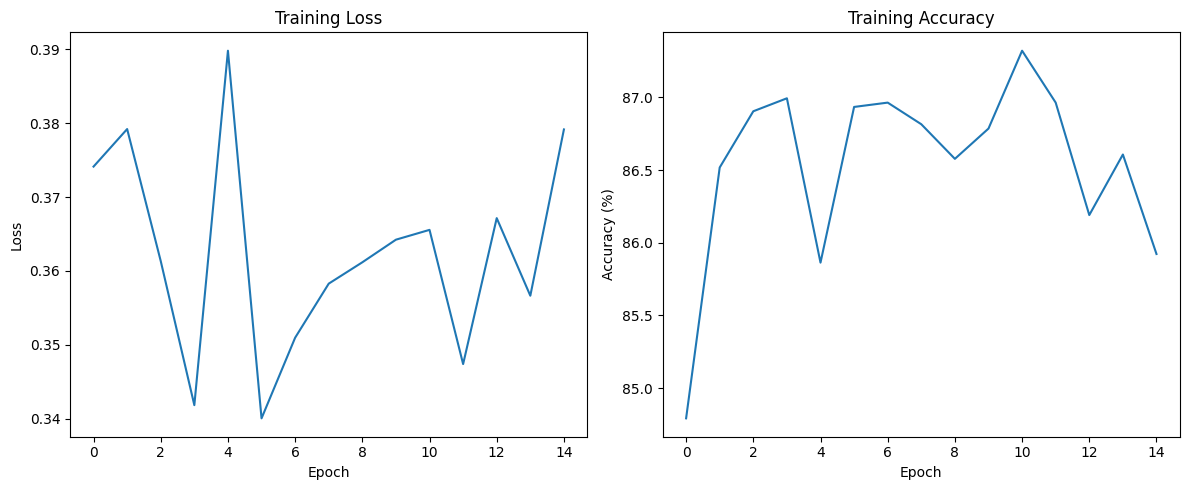


===== Generating Score-CAM Visualizations =====


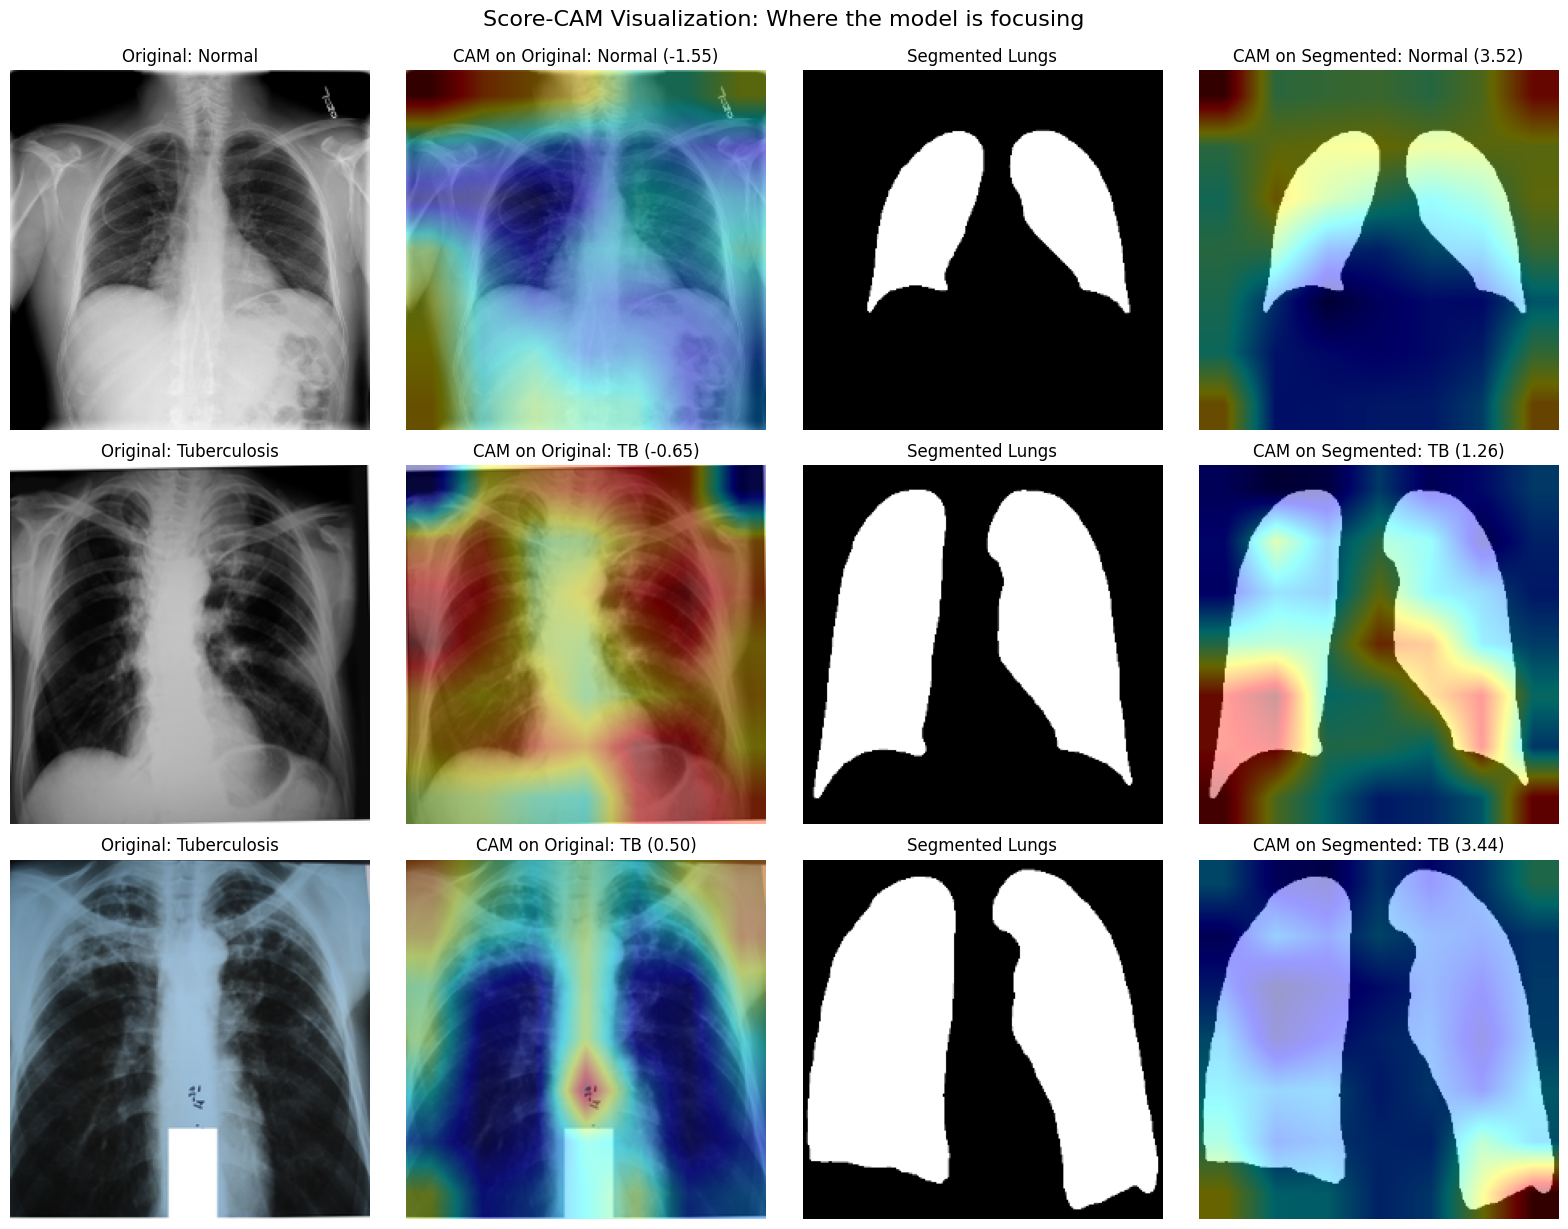

Score-CAM visualization saved

Model saved successfully.

Total runtime: 0h 12m 54s


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm
from transformers import AutoModel
import time
import gc
import traceback
from PIL import Image

# print gpu memory 
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
        print(f"GPU Memory Reserved: {torch.cuda.memory_reserved()/1e9:.2f} GB")


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print_gpu_memory()


def load_segmentation_model():
    print("Loading pretrained chest X-ray segmentation model...")
    try:
        model = AutoModel.from_pretrained("ianpan/chest-x-ray-basic", trust_remote_code=True)
        model = model.eval().to(device)
        print("Successfully loaded pretrained segmentation model")
        return model
    except Exception as e:
        print(f"Error loading pretrained model: {e}")
        print("Using fallback segmentation method")
        return None

# if unet doesnt work so manual
def basic_lung_segmentation(image):
    """
    Basic lung segmentation using image processing as fallback
    """
    
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    
    _, binary = cv2.threshold(enhanced, 90, 255, cv2.THRESH_BINARY)
    
    
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # Apply mask to original image
    if len(image.shape) == 3:
        mask = np.stack([binary, binary, binary], axis=2) / 255.0
    else:
        mask = binary / 255.0
    
    segmented = image * mask
    
    return segmented


def segment_lungs(image, model=None):
    if model is None:
        return basic_lung_segmentation(image)
    
    # Save original image dimensions
    orig_h, orig_w = image.shape[:2]
    
    
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray_img = image
    
    try:
       
        x = model.preprocess(gray_img)  
        x = torch.from_numpy(x).unsqueeze(0).unsqueeze(0)  
        x = x.float().to(device)
        
        # Generate prediction
        with torch.no_grad():
            out = model(x)
            torch.cuda.synchronize()  
        
        
        mask = out["mask"].squeeze().cpu().numpy()
        
        
        mask = mask.argmax(0)
        
        
        binary_mask = np.zeros_like(mask)
        binary_mask[mask == 1] = 1  # Right lung
        binary_mask[mask == 2] = 1  # Left lung
        
        
        if binary_mask.shape[0] != orig_h or binary_mask.shape[1] != orig_w:
            binary_mask = cv2.resize(binary_mask.astype(np.float32), (orig_w, orig_h))
        
        
        if len(image.shape) == 3:
            segmented = image * np.expand_dims(binary_mask, axis=2)
        else:
            segmented = image * binary_mask
        
        
        if segmented.dtype == np.float32 or segmented.dtype == np.float64:
           
            segmented = np.clip(segmented, 0, 1)
            segmented = (segmented * 255).astype(np.uint8)
        
        return segmented
    
    except Exception as e:
        print(f"Error in segmentation: {e}")
        print(traceback.format_exc())
        return basic_lung_segmentation(image)


def preprocess_and_cache_segmented_images(df, model, cache_dir='segmented_cache'):
    os.makedirs(cache_dir, exist_ok=True)
    
    print("Pre-processing and caching segmented images...")
    processed_count = 0
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        
        src_path = row['image_path']
        filename = os.path.basename(src_path)
        dest_path = os.path.join(cache_dir, filename)
        

        if os.path.exists(dest_path):
            processed_count += 1
            continue
        try:
            img = cv2.imread(src_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            segmented = segment_lungs(img, model)   
            segmented = cv2.resize(segmented, (224, 224))
            cv2.imwrite(dest_path, cv2.cvtColor(segmented, cv2.COLOR_RGB2BGR))
            processed_count += 1
            if idx % 100 == 0:
                torch.cuda.empty_cache()      
        except Exception as e:
            print(f"Error processing {src_path}: {e}")
    
    print(f"Processed {processed_count} images. Cached at {cache_dir}/")
    new_df = df.copy()
    new_df['segmented_path'] = new_df['image_path'].apply(
        lambda x: os.path.join(cache_dir, os.path.basename(x))
    )
    
    return new_df


class OptimizedChestXRayDataset(Dataset):
    def __init__(self, dataframe, transform=None, use_segmented_paths=True):
        self.dataframe = dataframe
        self.transform = transform
        self.use_segmented_paths = use_segmented_paths and 'segmented_path' in dataframe.columns
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        
        if self.use_segmented_paths:
            img_path = self.dataframe.iloc[idx]['segmented_path']
        else:
            img_path = self.dataframe.iloc[idx]['image_path']
            
        label = 1 if self.dataframe.iloc[idx]['label'] == 'Tuberculosis' else 0
        
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        if img.shape[:2] != (224, 224):
            img = cv2.resize(img, (224, 224))
        
        
        if self.transform:
            # Make sure the image is in uint8 format before passing to PIL
            if img.dtype == np.float32 or img.dtype == np.float64:
                img = np.clip(img, 0, 1)
                img = (img * 255).astype(np.uint8)
            
            img = self.transform(img)
        
        return img, label


def get_transforms(is_training=True):
    if is_training:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


def create_optimized_dataloaders(train_df, test_df, batch_size=8):
    train_transform = get_transforms(is_training=True)
    test_transform = get_transforms(is_training=False)
    
    train_dataset = OptimizedChestXRayDataset(
        train_df, 
        transform=train_transform,
        use_segmented_paths=True
    )
    
    test_dataset = OptimizedChestXRayDataset(
        test_df, 
        transform=test_transform,
        use_segmented_paths=True
    )
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0,  
        pin_memory=True  
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0,  
        pin_memory=True  
    )
    
    return train_loader, test_loader


def setup_densenet201(num_classes=2):
    """Load and configure DenseNet201 for transfer learning"""
    
    model = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)
    
    
    for param in model.parameters():
        param.requires_grad = False
    
    
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, num_classes)
    )
    
    
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    return model


def train_model(model, train_loader, criterion, optimizer, device, num_epochs=15, use_early_stopping=False, patience=3):
    model.to(device)
    history = {'train_loss': [], 'train_acc': []}
    
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        batch_count = 0
        start_time = time.time()
        
        try:
            for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
                
                if batch_count == 0:
                    print_gpu_memory()
                
                inputs, labels = inputs.to(device), labels.to(device)
                
                
                optimizer.zero_grad()
                
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                
                loss.backward()
                optimizer.step()
                
               
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                
                torch.cuda.empty_cache()
                batch_count += 1
                
                
                if batch_count % 10 == 0:
                    batch_acc = 100 * correct / total
                    print(f"Batch {batch_count}, Loss: {loss.item():.4f}, Running Acc: {batch_acc:.2f}%")
            
            
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = 100 * correct / total
            epoch_time = time.time() - start_time
            
            
            history['train_loss'].append(epoch_loss)
            history['train_acc'].append(epoch_acc)
            
            print(f'Epoch {epoch+1}/{num_epochs}, '
                  f'Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, '
                  f'Time: {epoch_time:.1f}s')
            
            
            torch.save(model.state_dict(), f'densenet201_tb_epoch_{epoch+1}.pth')
            
           
            if use_early_stopping:
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    patience_counter = 0
                    
                    torch.save(model.state_dict(), 'best_densenet201_tb.pth')
                    print("Saved best model checkpoint")
                else:
                    patience_counter += 1
                    print(f"No improvement in loss. Patience: {patience_counter}/{patience}")
                    
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break
            else:
                
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), 'best_densenet201_tb.pth')
                    print("Saved best model checkpoint")
                
        except Exception as e:
            print(f"Error during training: {e}")
            print(traceback.format_exc())
            
            torch.save(model.state_dict(), 'emergency_densenet201_tb.pth')
            print("Saved emergency checkpoint due to error")
            break
    
    
    try:
        model.load_state_dict(torch.load('best_densenet201_tb.pth'))
        print("Loaded best model for evaluation")
    except:
        print("Could not load best model, using current model")
    
    return model, history


def evaluate_model(model, test_loader, device):
    """Evaluate the model and calculate performance metrics"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            
            torch.cuda.empty_cache()
    
    
    
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    
    if conf_matrix.size == 4:  
        tn, fp, fn, tp = conf_matrix.ravel()
    else:
        
        print("Warning: Could not unpack confusion matrix")
        tn, fp, fn, tp = 0, 0, 0, 0
    
    accuracy = accuracy_score(all_labels, all_preds) * 100
    
    
    try:
        precision = precision_score(all_labels, all_preds) * 100
    except:
        precision = 0
        
    try:
        recall = recall_score(all_labels, all_preds) * 100
    except:
        recall = 0
        
    try:
        f1 = f1_score(all_labels, all_preds) * 100
    except:
        f1 = 0
        
    try:
        specificity = tn / (tn + fp) * 100 if (tn + fp) > 0 else 0
    except:
        specificity = 0
    
    try:
        auc = roc_auc_score(all_labels, all_preds) * 100
    except:
        auc = 0
    
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'auc': auc,
        'confusion_matrix': conf_matrix
    }
    
    return results

# visualization isay hogi
class ScoreCAM:
    """
    Implementation of Score-CAM visualization technique
    """
    def __init__(self, model, target_layer_name='features.denseblock4', device=None):
        self.model = model
        self.target_layer_name = target_layer_name
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.model.eval()
        self.outputs = []
        self.handles = []
        
        
        for name, module in self.model.named_modules():
            if target_layer_name in name:
                self.handles.append(
                    module.register_forward_hook(self._get_activation)
                )
    
    def _get_activation(self, module, input, output):
        
        self.outputs.append(output)
    
    def generate_cam(self, input_image, target_class=None):
        self.outputs = []
        with torch.no_grad():
            output = self.model(input_image)
        if target_class is None:
            pred_score, pred_class = torch.max(output, dim=1)
            target_class = pred_class.item()
        else:
            pred_class = target_class
            pred_score = output[0, target_class].item()
        activation_maps = self.outputs[0]  
        batch_size, channels, height, width = activation_maps.shape
        cam = torch.zeros((height, width), dtype=torch.float32, device=self.device)
        for i in range(channels):
            
            channel_map = activation_maps[0, i].unsqueeze(0).unsqueeze(0) 
            
            
            channel_map_norm = (channel_map - channel_map.min()) / (channel_map.max() - channel_map.min() + 1e-8)
            
            
            channel_map_upsampled = F.interpolate(
                channel_map_norm, 
                size=input_image.shape[2:], 
                mode='bilinear', 
                align_corners=False
            )
            
            
            with torch.no_grad():
                
                masked_input = input_image * channel_map_upsampled
                output = self.model(masked_input)
                score = output[0, target_class]
            
            
            cam += score.item() * channel_map[0, 0]
        
        
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        
        
        cam = cam.cpu().numpy()
        
        return cam, pred_class, pred_score
    
    def visualize(self, image_path, target_class=None, use_segmented=False, segmentation_model=None):
        
        
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        if use_segmented and segmentation_model is not None:
            img = segment_lungs(img, segmentation_model)
        
        
        img_resized = cv2.resize(img, (224, 224))
        
        
        if img_resized.dtype != np.uint8:
            img_resized = np.clip(img_resized, 0, 1) * 255
            img_resized = img_resized.astype(np.uint8)
        
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        img_tensor = transform(img_resized).unsqueeze(0).to(self.device)
        
        
        cam, pred_class, pred_score = self.generate_cam(img_tensor, target_class)
        
        
        cam_resized = cv2.resize(cam, (img_resized.shape[1], img_resized.shape[0]))
        
        
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        
        
        cam_img = (heatmap * 0.4 + img_resized * 0.6).astype(np.uint8)
        
        return img_resized, cam_img, pred_class, pred_score
    
    def __del__(self):
       
        for handle in self.handles:
            handle.remove()


def visualize_score_cam(model, test_df, segmentation_model=None, device=None, num_samples=3):
    """
    Visualize Score-CAM results for a few sample images
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    
    normal_df = test_df[test_df['label'] == 'Normal'].sample(num_samples//2)
    tb_df = test_df[test_df['label'] == 'Tuberculosis'].sample(num_samples - num_samples//2)
    sample_df = pd.concat([normal_df, tb_df])
    
    
    score_cam = ScoreCAM(model, target_layer_name='features.denseblock4', device=device)
    
    
    fig, axes = plt.subplots(len(sample_df), 4, figsize=(16, 4*len(sample_df)))
    
    
    if len(sample_df) == 1:
        axes = np.expand_dims(axes, axis=0)
    
    # Process each image
    for i, (_, row) in enumerate(sample_df.iterrows()):
        try:
           
            img_path = row['image_path']
            label = row['label']
            
            
            if segmentation_model is not None and next(segmentation_model.parameters()).device != device:
                segmentation_model = segmentation_model.to(device)
            
            
            
            orig_img, orig_cam, orig_pred, orig_score = score_cam.visualize(
                img_path, 
                target_class=1 if label == 'Tuberculosis' else 0,
                use_segmented=False
            )
            
            # 2. Original image with segmentation
            seg_img, seg_cam, seg_pred, seg_score = score_cam.visualize(
                img_path, 
                target_class=1 if label == 'Tuberculosis' else 0,
                use_segmented=True,
                segmentation_model=segmentation_model
            )
            
            # Plot results
            axes[i, 0].imshow(orig_img)
            axes[i, 0].set_title(f"Original: {label}")
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(orig_cam)
            axes[i, 1].set_title(f"CAM on Original: {'TB' if orig_pred == 1 else 'Normal'} ({orig_score:.2f})")
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(seg_img)
            axes[i, 2].set_title(f"Segmented Lungs")
            axes[i, 2].axis('off')
            
            axes[i, 3].imshow(seg_cam)
            axes[i, 3].set_title(f"CAM on Segmented: {'TB' if seg_pred == 1 else 'Normal'} ({seg_score:.2f})")
            axes[i, 3].axis('off')
            
        except Exception as e:
            print(f"Error visualizing image {img_path}: {e}")
            traceback.print_exc()
    
    plt.tight_layout()
    plt.suptitle("Score-CAM Visualization: Where the model is focusing", fontsize=16, y=1.02)
    plt.savefig('score_cam_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Clean up
    if segmentation_model is not None:
        segmentation_model = segmentation_model.cpu()
    torch.cuda.empty_cache()
    
    return fig

# Main function with optimized workflow and Score-CAM
def main():
    
    total_start_time = time.time()
    
    
    base_path = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database'
    normal_path = os.path.join(base_path, 'Normal')
    tb_path = os.path.join(base_path, 'Tuberculosis')
    
    def create_dataset_df(normal_dir, tb_dir):
        normal_files = glob(os.path.join(normal_dir, '*.png'))
        tb_files = glob(os.path.join(tb_dir, '*.png'))
        
        files = normal_files + tb_files
        labels = ['Normal'] * len(normal_files) + ['Tuberculosis'] * len(tb_files)
        
        return pd.DataFrame({
            'image_path': files,
            'label': labels
        })
    
    # Create dataframe
    print("Creating dataset dataframe...")
    df = create_dataset_df(normal_path, tb_path)
    
    print("\nDataset Information:")
    print(f"Total number of images: {len(df)}")
    print(f"Class distribution:\n{df['label'].value_counts()}")
    
    
    train_df, test_df = train_test_split(
        df, 
        test_size=0.2, 
        random_state=42,
        stratify=df['label']
    )
    
    print("\nTrain/Test Split:")
    print(f"Training set: {len(train_df)} images")
    print(f"Testing set: {len(test_df)} images")
    
    try:
        
        segmentation_model = load_segmentation_model()
        
        
        cache_dir = '/kaggle/working/segmented_cache'
        train_df = preprocess_and_cache_segmented_images(train_df, segmentation_model, cache_dir)
        test_df = preprocess_and_cache_segmented_images(test_df, segmentation_model, cache_dir)
        
        
        segmentation_model = segmentation_model.cpu()
        torch.cuda.empty_cache()
        print_gpu_memory()
        
        
        print("\nCreating data loaders with pre-segmented lung images...")
        train_loader, test_loader = create_optimized_dataloaders(
            train_df, test_df, batch_size=8  # Reduced batch size for P100
        )
        
        
        model = setup_densenet201(num_classes=2)
        
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=0.001,
            momentum=0.9
        )
        
        
        print("\n===== Training DenseNet201 with Segmented Lungs =====")
        print_gpu_memory()
        model, history = train_model(
            model, train_loader, criterion, optimizer, device, 
            num_epochs=15,  
            use_early_stopping=False  
        )
        
        # Evaluate model
        print("\n===== Evaluating Model =====")
        results = evaluate_model(model, test_loader, device)
        
        
        print("\n===== Results Summary =====")
        print(f"Accuracy: {results['accuracy']:.2f}% (Paper with segmentation: 99.90%)")
        print(f"Precision: {results['precision']:.2f}% (Paper with segmentation: 99.91%)")
        print(f"Sensitivity/Recall: {results['recall']:.2f}% (Paper with segmentation: 99.90%)")
        print(f"F1 Score: {results['f1_score']:.2f}% (Paper with segmentation: 99.90%)")
        print(f"Specificity: {results['specificity']:.2f}% (Paper with segmentation: 99.52%)")
        print(f"AUC: {results['auc']:.2f}%")
        print("\nConfusion Matrix:")
        print(results['confusion_matrix'])
        
        # Plot training history
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'])
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'])
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        
        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300)
        plt.show()
        
        
        print("\n===== Generating Score-CAM Visualizations =====")
        try:
            
            segmentation_model = segmentation_model.to(device)
            
            
            fig = visualize_score_cam(
                model=model,
                test_df=test_df,
                segmentation_model=segmentation_model,
                device=device,
                num_samples=3
            )
            
            
            fig.savefig('score_cam_visualization.png', dpi=300, bbox_inches='tight')
            print("Score-CAM visualization saved")
            
            
            segmentation_model = segmentation_model.cpu()
            torch.cuda.empty_cache()
            
        except Exception as e:
            print(f"Error in Score-CAM visualization: {e}")
            traceback.print_exc()
        
        
        torch.save(model.state_dict(), 'densenet201_tb_segmented.pth')
        print("\nModel saved successfully.")
        
    except Exception as e:
        print(f"Error in main execution: {e}")
        print(traceback.format_exc())
    
    finally:
        
        total_time = time.time() - total_start_time
        hours, remainder = divmod(total_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f"\nTotal runtime: {int(hours)}h {int(minutes)}m {int(seconds)}s")


if __name__ == "__main__":
   
    try:
        import torch.multiprocessing as mp
        mp.set_start_method('spawn', force=True)
    except RuntimeError:
        # Method already set
        pass
    
    main()


# **Vision Transformers** 

Using device: cuda:0
GPU Memory Allocated: 9.90 GB
GPU Memory Reserved: 9.99 GB
Creating dataset dataframe...

Dataset Information:
Total number of images: 4200
Class distribution:
label
Normal          3500
Tuberculosis     700
Name: count, dtype: int64

Train/Test Split:
Training set: 3360 images
Testing set: 840 images
Loading pretrained chest X-ray segmentation model...
Successfully loaded pretrained segmentation model
Pre-processing and caching segmented images...


100%|██████████| 3360/3360 [00:00<00:00, 22321.61it/s]


Processed 3360 images. Cached at /kaggle/working/segmented_cache/
Pre-processing and caching segmented images...


100%|██████████| 840/840 [00:00<00:00, 22911.50it/s]

Processed 840 images. Cached at /kaggle/working/segmented_cache/


GPU Memory Allocated: 9.90 GB
GPU Memory Reserved: 9.99 GB

Creating data loaders with pre-segmented lung images...
Loading pretrained Vision Transformer: google/vit-base-patch16-224...


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Vision Transformer loaded successfully with 2 output classes

===== Training Vision Transformer with Segmented Lungs =====
GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.37 GB


Epoch 1/15:   0%|          | 0/420 [00:00<?, ?it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.37 GB


Epoch 1/15:   3%|▎         | 13/420 [00:00<00:27, 14.57it/s]

Batch 10, Loss: 0.4896, Running Acc: 81.25%


Epoch 1/15:   5%|▌         | 21/420 [00:01<00:26, 14.91it/s]

Batch 20, Loss: 0.3447, Running Acc: 83.75%


Epoch 1/15:   8%|▊         | 33/420 [00:02<00:26, 14.82it/s]

Batch 30, Loss: 0.1486, Running Acc: 82.92%


Epoch 1/15:  10%|█         | 43/420 [00:02<00:25, 14.97it/s]

Batch 40, Loss: 0.3468, Running Acc: 83.12%


Epoch 1/15:  13%|█▎        | 53/420 [00:03<00:24, 14.96it/s]

Batch 50, Loss: 0.1383, Running Acc: 83.75%


Epoch 1/15:  15%|█▍        | 61/420 [00:04<00:23, 15.02it/s]

Batch 60, Loss: 0.1249, Running Acc: 85.00%


Epoch 1/15:  17%|█▋        | 71/420 [00:04<00:23, 14.97it/s]

Batch 70, Loss: 0.3285, Running Acc: 85.18%


Epoch 1/15:  20%|█▉        | 83/420 [00:05<00:22, 15.14it/s]

Batch 80, Loss: 0.3811, Running Acc: 84.69%


Epoch 1/15:  22%|██▏       | 93/420 [00:06<00:21, 15.07it/s]

Batch 90, Loss: 0.3086, Running Acc: 84.44%


Epoch 1/15:  25%|██▍       | 103/420 [00:07<00:21, 14.77it/s]

Batch 100, Loss: 0.3159, Running Acc: 84.00%


Epoch 1/15:  27%|██▋       | 113/420 [00:07<00:20, 14.84it/s]

Batch 110, Loss: 0.7227, Running Acc: 84.43%


Epoch 1/15:  29%|██▉       | 121/420 [00:08<00:19, 14.97it/s]

Batch 120, Loss: 0.3161, Running Acc: 84.27%


Epoch 1/15:  31%|███       | 131/420 [00:08<00:19, 14.96it/s]

Batch 130, Loss: 0.7163, Running Acc: 83.56%


Epoch 1/15:  34%|███▎      | 141/420 [00:09<00:19, 14.53it/s]

Batch 140, Loss: 0.3524, Running Acc: 84.20%


Epoch 1/15:  36%|███▌      | 151/420 [00:10<00:18, 14.60it/s]

Batch 150, Loss: 0.1147, Running Acc: 84.50%


Epoch 1/15:  38%|███▊      | 161/420 [00:10<00:17, 15.04it/s]

Batch 160, Loss: 0.4403, Running Acc: 84.30%


Epoch 1/15:  41%|████      | 171/420 [00:11<00:16, 15.13it/s]

Batch 170, Loss: 0.3851, Running Acc: 83.90%


Epoch 1/15:  43%|████▎     | 181/420 [00:12<00:15, 14.95it/s]

Batch 180, Loss: 0.2849, Running Acc: 83.96%


Epoch 1/15:  46%|████▌     | 193/420 [00:13<00:15, 15.07it/s]

Batch 190, Loss: 0.2744, Running Acc: 84.01%


Epoch 1/15:  48%|████▊     | 203/420 [00:13<00:14, 15.02it/s]

Batch 200, Loss: 0.4975, Running Acc: 83.81%


Epoch 1/15:  51%|█████     | 213/420 [00:14<00:13, 15.06it/s]

Batch 210, Loss: 0.2025, Running Acc: 83.99%


Epoch 1/15:  53%|█████▎    | 223/420 [00:15<00:13, 15.03it/s]

Batch 220, Loss: 0.3643, Running Acc: 83.92%


Epoch 1/15:  55%|█████▌    | 233/420 [00:15<00:12, 15.11it/s]

Batch 230, Loss: 0.2622, Running Acc: 83.70%


Epoch 1/15:  58%|█████▊    | 243/420 [00:16<00:11, 15.03it/s]

Batch 240, Loss: 0.3571, Running Acc: 83.70%


Epoch 1/15:  60%|█████▉    | 251/420 [00:16<00:11, 15.04it/s]

Batch 250, Loss: 0.6424, Running Acc: 83.60%


Epoch 1/15:  62%|██████▏   | 261/420 [00:17<00:10, 15.12it/s]

Batch 260, Loss: 0.5522, Running Acc: 83.70%


Epoch 1/15:  65%|██████▍   | 271/420 [00:18<00:09, 15.12it/s]

Batch 270, Loss: 0.6281, Running Acc: 83.66%


Epoch 1/15:  67%|██████▋   | 283/420 [00:19<00:09, 15.15it/s]

Batch 280, Loss: 0.2398, Running Acc: 83.62%


Epoch 1/15:  70%|██████▉   | 293/420 [00:19<00:08, 14.97it/s]

Batch 290, Loss: 0.1677, Running Acc: 83.75%


Epoch 1/15:  72%|███████▏  | 303/420 [00:20<00:07, 15.09it/s]

Batch 300, Loss: 0.1660, Running Acc: 83.96%


Epoch 1/15:  75%|███████▍  | 313/420 [00:21<00:07, 15.02it/s]

Batch 310, Loss: 0.1098, Running Acc: 84.15%


Epoch 1/15:  77%|███████▋  | 323/420 [00:21<00:06, 15.03it/s]

Batch 320, Loss: 0.2876, Running Acc: 84.14%


Epoch 1/15:  79%|███████▉  | 333/420 [00:22<00:05, 14.96it/s]

Batch 330, Loss: 0.5315, Running Acc: 84.13%


Epoch 1/15:  82%|████████▏ | 343/420 [00:23<00:05, 15.00it/s]

Batch 340, Loss: 0.2242, Running Acc: 84.23%


Epoch 1/15:  84%|████████▎ | 351/420 [00:23<00:04, 14.93it/s]

Batch 350, Loss: 0.3178, Running Acc: 84.21%


Epoch 1/15:  86%|████████▋ | 363/420 [00:24<00:03, 15.02it/s]

Batch 360, Loss: 0.3159, Running Acc: 84.38%


Epoch 1/15:  89%|████████▉ | 373/420 [00:25<00:03, 15.15it/s]

Batch 370, Loss: 0.2586, Running Acc: 84.49%


Epoch 1/15:  91%|█████████ | 383/420 [00:25<00:02, 15.20it/s]

Batch 380, Loss: 0.6001, Running Acc: 84.44%


Epoch 1/15:  94%|█████████▎| 393/420 [00:26<00:01, 15.21it/s]

Batch 390, Loss: 0.3098, Running Acc: 84.52%


Epoch 1/15:  96%|█████████▌| 403/420 [00:27<00:01, 15.22it/s]

Batch 400, Loss: 0.4713, Running Acc: 84.44%


Epoch 1/15:  98%|█████████▊| 413/420 [00:27<00:00, 15.23it/s]

Batch 410, Loss: 0.1076, Running Acc: 84.54%


Epoch 1/15: 100%|██████████| 420/420 [00:28<00:00, 14.92it/s]


Batch 420, Loss: 0.4532, Running Acc: 84.61%
Epoch 1/15, Loss: 0.3707, Accuracy: 84.61%, Time: 28.2s
Saved best model checkpoint


Epoch 2/15:   0%|          | 2/420 [00:00<00:27, 15.05it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.37 GB


Epoch 2/15:   3%|▎         | 12/420 [00:00<00:27, 15.07it/s]

Batch 10, Loss: 0.1157, Running Acc: 90.00%


Epoch 2/15:   5%|▌         | 22/420 [00:01<00:26, 15.11it/s]

Batch 20, Loss: 0.2525, Running Acc: 87.50%


Epoch 2/15:   8%|▊         | 32/420 [00:02<00:25, 15.23it/s]

Batch 30, Loss: 0.1240, Running Acc: 90.00%


Epoch 2/15:  10%|█         | 42/420 [00:02<00:25, 15.10it/s]

Batch 40, Loss: 0.1412, Running Acc: 88.12%


Epoch 2/15:  12%|█▏        | 52/420 [00:03<00:24, 14.94it/s]

Batch 50, Loss: 0.1247, Running Acc: 87.00%


Epoch 2/15:  15%|█▍        | 62/420 [00:04<00:23, 14.99it/s]

Batch 60, Loss: 0.0964, Running Acc: 86.25%


Epoch 2/15:  17%|█▋        | 72/420 [00:04<00:23, 14.66it/s]

Batch 70, Loss: 0.6154, Running Acc: 86.61%


Epoch 2/15:  20%|█▉        | 82/420 [00:05<00:22, 14.90it/s]

Batch 80, Loss: 0.1411, Running Acc: 87.19%


Epoch 2/15:  22%|██▏       | 92/420 [00:06<00:21, 14.97it/s]

Batch 90, Loss: 0.2120, Running Acc: 87.92%


Epoch 2/15:  24%|██▍       | 102/420 [00:06<00:21, 14.96it/s]

Batch 100, Loss: 0.5073, Running Acc: 86.88%


Epoch 2/15:  27%|██▋       | 112/420 [00:07<00:20, 14.88it/s]

Batch 110, Loss: 0.3997, Running Acc: 86.59%


Epoch 2/15:  29%|██▉       | 122/420 [00:08<00:19, 15.03it/s]

Batch 120, Loss: 0.3624, Running Acc: 86.56%


Epoch 2/15:  31%|███▏      | 132/420 [00:08<00:19, 15.02it/s]

Batch 130, Loss: 0.4200, Running Acc: 86.63%


Epoch 2/15:  34%|███▍      | 142/420 [00:09<00:18, 15.05it/s]

Batch 140, Loss: 0.3806, Running Acc: 87.32%


Epoch 2/15:  36%|███▌      | 152/420 [00:10<00:18, 14.65it/s]

Batch 150, Loss: 0.3715, Running Acc: 87.17%


Epoch 2/15:  39%|███▊      | 162/420 [00:10<00:17, 14.80it/s]

Batch 160, Loss: 0.1812, Running Acc: 87.50%


Epoch 2/15:  41%|████      | 172/420 [00:11<00:16, 14.70it/s]

Batch 170, Loss: 0.1439, Running Acc: 87.57%


Epoch 2/15:  43%|████▎     | 182/420 [00:12<00:16, 14.58it/s]

Batch 180, Loss: 0.2237, Running Acc: 87.43%


Epoch 2/15:  46%|████▌     | 192/420 [00:12<00:15, 14.44it/s]

Batch 190, Loss: 0.5058, Running Acc: 87.37%


Epoch 2/15:  48%|████▊     | 202/420 [00:13<00:14, 14.99it/s]

Batch 200, Loss: 0.2964, Running Acc: 87.50%


Epoch 2/15:  50%|█████     | 212/420 [00:14<00:13, 15.10it/s]

Batch 210, Loss: 0.4162, Running Acc: 87.56%


Epoch 2/15:  53%|█████▎    | 222/420 [00:14<00:13, 14.88it/s]

Batch 220, Loss: 0.4735, Running Acc: 87.44%


Epoch 2/15:  55%|█████▌    | 232/420 [00:15<00:12, 14.96it/s]

Batch 230, Loss: 0.4925, Running Acc: 87.50%


Epoch 2/15:  58%|█████▊    | 242/420 [00:16<00:11, 14.83it/s]

Batch 240, Loss: 0.0676, Running Acc: 87.60%


Epoch 2/15:  60%|██████    | 252/420 [00:16<00:11, 14.92it/s]

Batch 250, Loss: 0.1869, Running Acc: 87.75%


Epoch 2/15:  62%|██████▏   | 262/420 [00:17<00:10, 15.18it/s]

Batch 260, Loss: 0.3994, Running Acc: 87.55%


Epoch 2/15:  65%|██████▍   | 272/420 [00:18<00:09, 15.18it/s]

Batch 270, Loss: 0.1972, Running Acc: 87.45%


Epoch 2/15:  67%|██████▋   | 282/420 [00:18<00:09, 15.16it/s]

Batch 280, Loss: 0.3514, Running Acc: 87.41%


Epoch 2/15:  70%|██████▉   | 292/420 [00:19<00:08, 15.11it/s]

Batch 290, Loss: 0.4215, Running Acc: 87.46%


Epoch 2/15:  72%|███████▏  | 302/420 [00:20<00:07, 15.14it/s]

Batch 300, Loss: 0.3459, Running Acc: 87.67%


Epoch 2/15:  74%|███████▍  | 312/420 [00:20<00:07, 15.06it/s]

Batch 310, Loss: 0.3943, Running Acc: 87.70%


Epoch 2/15:  77%|███████▋  | 322/420 [00:21<00:06, 15.14it/s]

Batch 320, Loss: 0.6946, Running Acc: 87.50%


Epoch 2/15:  79%|███████▉  | 332/420 [00:22<00:05, 14.85it/s]

Batch 330, Loss: 0.4925, Running Acc: 87.50%


Epoch 2/15:  81%|████████▏ | 342/420 [00:22<00:05, 14.83it/s]

Batch 340, Loss: 0.1068, Running Acc: 87.46%


Epoch 2/15:  84%|████████▍ | 352/420 [00:23<00:04, 14.94it/s]

Batch 350, Loss: 0.5784, Running Acc: 87.57%


Epoch 2/15:  86%|████████▌ | 362/420 [00:24<00:03, 15.17it/s]

Batch 360, Loss: 0.2096, Running Acc: 87.60%


Epoch 2/15:  89%|████████▊ | 372/420 [00:24<00:03, 15.25it/s]

Batch 370, Loss: 0.5844, Running Acc: 87.67%


Epoch 2/15:  91%|█████████ | 382/420 [00:25<00:02, 15.14it/s]

Batch 380, Loss: 0.5345, Running Acc: 87.50%


Epoch 2/15:  93%|█████████▎| 392/420 [00:26<00:01, 14.97it/s]

Batch 390, Loss: 0.1898, Running Acc: 87.50%


Epoch 2/15:  96%|█████████▌| 402/420 [00:26<00:01, 15.13it/s]

Batch 400, Loss: 0.1412, Running Acc: 87.66%


Epoch 2/15:  98%|█████████▊| 412/420 [00:27<00:00, 15.02it/s]

Batch 410, Loss: 0.1421, Running Acc: 87.53%


Epoch 2/15: 100%|██████████| 420/420 [00:28<00:00, 14.96it/s]


Batch 420, Loss: 0.3030, Running Acc: 87.41%
Epoch 2/15, Loss: 0.3046, Accuracy: 87.41%, Time: 28.1s
Saved best model checkpoint


Epoch 3/15:   0%|          | 2/420 [00:00<00:28, 14.43it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.37 GB


Epoch 3/15:   3%|▎         | 12/420 [00:00<00:26, 15.16it/s]

Batch 10, Loss: 0.2253, Running Acc: 88.75%


Epoch 3/15:   5%|▌         | 22/420 [00:01<00:26, 15.03it/s]

Batch 20, Loss: 0.1819, Running Acc: 91.88%


Epoch 3/15:   8%|▊         | 32/420 [00:02<00:25, 15.18it/s]

Batch 30, Loss: 0.2168, Running Acc: 92.50%


Epoch 3/15:  10%|█         | 42/420 [00:02<00:24, 15.25it/s]

Batch 40, Loss: 0.3203, Running Acc: 88.75%


Epoch 3/15:  12%|█▏        | 52/420 [00:03<00:24, 14.85it/s]

Batch 50, Loss: 0.1792, Running Acc: 89.75%


Epoch 3/15:  15%|█▍        | 62/420 [00:04<00:23, 14.95it/s]

Batch 60, Loss: 0.5074, Running Acc: 88.33%


Epoch 3/15:  17%|█▋        | 72/420 [00:04<00:23, 14.95it/s]

Batch 70, Loss: 0.1177, Running Acc: 88.75%


Epoch 3/15:  20%|█▉        | 82/420 [00:05<00:22, 14.92it/s]

Batch 80, Loss: 0.4647, Running Acc: 88.28%


Epoch 3/15:  22%|██▏       | 92/420 [00:06<00:21, 14.95it/s]

Batch 90, Loss: 0.1941, Running Acc: 88.33%


Epoch 3/15:  24%|██▍       | 102/420 [00:06<00:20, 15.25it/s]

Batch 100, Loss: 0.4147, Running Acc: 88.50%


Epoch 3/15:  27%|██▋       | 112/420 [00:07<00:20, 15.22it/s]

Batch 110, Loss: 0.4982, Running Acc: 88.30%


Epoch 3/15:  29%|██▉       | 122/420 [00:08<00:19, 15.23it/s]

Batch 120, Loss: 0.2410, Running Acc: 88.65%


Epoch 3/15:  31%|███▏      | 132/420 [00:08<00:18, 15.25it/s]

Batch 130, Loss: 0.8890, Running Acc: 88.56%


Epoch 3/15:  34%|███▍      | 142/420 [00:09<00:18, 15.17it/s]

Batch 140, Loss: 0.4381, Running Acc: 88.57%


Epoch 3/15:  36%|███▌      | 152/420 [00:10<00:17, 15.11it/s]

Batch 150, Loss: 0.0982, Running Acc: 88.67%


Epoch 3/15:  39%|███▊      | 162/420 [00:10<00:17, 14.95it/s]

Batch 160, Loss: 0.2696, Running Acc: 89.06%


Epoch 3/15:  41%|████      | 172/420 [00:11<00:16, 14.86it/s]

Batch 170, Loss: 0.0815, Running Acc: 89.12%


Epoch 3/15:  43%|████▎     | 182/420 [00:12<00:15, 14.95it/s]

Batch 180, Loss: 0.2699, Running Acc: 89.17%


Epoch 3/15:  46%|████▌     | 192/420 [00:12<00:15, 15.18it/s]

Batch 190, Loss: 0.0511, Running Acc: 89.21%


Epoch 3/15:  48%|████▊     | 202/420 [00:13<00:14, 15.02it/s]

Batch 200, Loss: 0.1746, Running Acc: 89.44%


Epoch 3/15:  50%|█████     | 212/420 [00:14<00:14, 14.74it/s]

Batch 210, Loss: 0.3377, Running Acc: 89.23%


Epoch 3/15:  53%|█████▎    | 222/420 [00:14<00:13, 15.03it/s]

Batch 220, Loss: 0.1887, Running Acc: 88.81%


Epoch 3/15:  55%|█████▌    | 232/420 [00:15<00:12, 15.08it/s]

Batch 230, Loss: 0.4360, Running Acc: 88.86%


Epoch 3/15:  58%|█████▊    | 242/420 [00:16<00:11, 15.16it/s]

Batch 240, Loss: 0.8060, Running Acc: 88.96%


Epoch 3/15:  60%|██████    | 252/420 [00:16<00:11, 15.11it/s]

Batch 250, Loss: 0.1530, Running Acc: 89.15%


Epoch 3/15:  62%|██████▏   | 262/420 [00:17<00:10, 14.93it/s]

Batch 260, Loss: 0.1774, Running Acc: 89.13%


Epoch 3/15:  65%|██████▍   | 272/420 [00:18<00:09, 15.05it/s]

Batch 270, Loss: 0.3207, Running Acc: 89.07%


Epoch 3/15:  67%|██████▋   | 282/420 [00:18<00:09, 15.04it/s]

Batch 280, Loss: 0.4459, Running Acc: 89.11%


Epoch 3/15:  70%|██████▉   | 292/420 [00:19<00:08, 15.10it/s]

Batch 290, Loss: 0.4046, Running Acc: 88.92%


Epoch 3/15:  72%|███████▏  | 302/420 [00:20<00:07, 15.09it/s]

Batch 300, Loss: 0.2503, Running Acc: 88.92%


Epoch 3/15:  74%|███████▍  | 312/420 [00:20<00:07, 15.15it/s]

Batch 310, Loss: 0.2772, Running Acc: 88.91%


Epoch 3/15:  77%|███████▋  | 322/420 [00:21<00:06, 15.24it/s]

Batch 320, Loss: 0.1096, Running Acc: 89.10%


Epoch 3/15:  79%|███████▉  | 332/420 [00:22<00:05, 15.15it/s]

Batch 330, Loss: 0.2255, Running Acc: 89.02%


Epoch 3/15:  81%|████████▏ | 342/420 [00:22<00:05, 15.04it/s]

Batch 340, Loss: 0.2042, Running Acc: 89.04%


Epoch 3/15:  84%|████████▍ | 352/420 [00:23<00:04, 14.89it/s]

Batch 350, Loss: 0.2739, Running Acc: 89.18%


Epoch 3/15:  86%|████████▌ | 362/420 [00:24<00:03, 14.75it/s]

Batch 360, Loss: 0.1907, Running Acc: 89.06%


Epoch 3/15:  89%|████████▊ | 372/420 [00:24<00:03, 14.97it/s]

Batch 370, Loss: 0.2268, Running Acc: 89.12%


Epoch 3/15:  91%|█████████ | 382/420 [00:25<00:02, 15.08it/s]

Batch 380, Loss: 0.2253, Running Acc: 88.88%


Epoch 3/15:  93%|█████████▎| 392/420 [00:26<00:01, 15.06it/s]

Batch 390, Loss: 0.2620, Running Acc: 88.85%


Epoch 3/15:  96%|█████████▌| 402/420 [00:26<00:01, 15.06it/s]

Batch 400, Loss: 0.3775, Running Acc: 88.72%


Epoch 3/15:  98%|█████████▊| 412/420 [00:27<00:00, 15.05it/s]

Batch 410, Loss: 0.1996, Running Acc: 88.72%


Epoch 3/15: 100%|██████████| 420/420 [00:27<00:00, 15.03it/s]


Batch 420, Loss: 0.4722, Running Acc: 88.84%
Epoch 3/15, Loss: 0.2845, Accuracy: 88.84%, Time: 28.0s
Saved best model checkpoint


Epoch 4/15:   0%|          | 2/420 [00:00<00:28, 14.67it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.37 GB


Epoch 4/15:   3%|▎         | 12/420 [00:00<00:27, 14.98it/s]

Batch 10, Loss: 0.0501, Running Acc: 90.00%


Epoch 4/15:   5%|▌         | 22/420 [00:01<00:26, 15.03it/s]

Batch 20, Loss: 0.1723, Running Acc: 91.25%


Epoch 4/15:   8%|▊         | 32/420 [00:02<00:25, 15.04it/s]

Batch 30, Loss: 0.1282, Running Acc: 92.08%


Epoch 4/15:  10%|█         | 42/420 [00:02<00:25, 15.03it/s]

Batch 40, Loss: 0.0832, Running Acc: 91.56%


Epoch 4/15:  12%|█▏        | 52/420 [00:03<00:24, 14.81it/s]

Batch 50, Loss: 0.1205, Running Acc: 91.25%


Epoch 4/15:  15%|█▍        | 62/420 [00:04<00:23, 15.13it/s]

Batch 60, Loss: 0.1491, Running Acc: 91.04%


Epoch 4/15:  17%|█▋        | 72/420 [00:04<00:23, 14.86it/s]

Batch 70, Loss: 0.5891, Running Acc: 90.71%


Epoch 4/15:  20%|█▉        | 82/420 [00:05<00:22, 14.97it/s]

Batch 80, Loss: 0.1085, Running Acc: 90.31%


Epoch 4/15:  22%|██▏       | 92/420 [00:06<00:21, 14.98it/s]

Batch 90, Loss: 0.3166, Running Acc: 90.00%


Epoch 4/15:  24%|██▍       | 102/420 [00:06<00:21, 15.00it/s]

Batch 100, Loss: 0.1722, Running Acc: 89.88%


Epoch 4/15:  27%|██▋       | 112/420 [00:07<00:20, 14.94it/s]

Batch 110, Loss: 0.1534, Running Acc: 90.11%


Epoch 4/15:  29%|██▉       | 122/420 [00:08<00:19, 14.94it/s]

Batch 120, Loss: 0.1375, Running Acc: 90.10%


Epoch 4/15:  31%|███▏      | 132/420 [00:08<00:19, 14.99it/s]

Batch 130, Loss: 0.6704, Running Acc: 89.62%


Epoch 4/15:  34%|███▍      | 142/420 [00:09<00:18, 14.98it/s]

Batch 140, Loss: 0.1398, Running Acc: 89.64%


Epoch 4/15:  36%|███▌      | 152/420 [00:10<00:17, 14.96it/s]

Batch 150, Loss: 0.1898, Running Acc: 89.83%


Epoch 4/15:  39%|███▊      | 162/420 [00:10<00:16, 15.22it/s]

Batch 160, Loss: 0.6413, Running Acc: 90.00%


Epoch 4/15:  41%|████      | 172/420 [00:11<00:16, 15.15it/s]

Batch 170, Loss: 0.1938, Running Acc: 89.85%


Epoch 4/15:  43%|████▎     | 182/420 [00:12<00:15, 15.11it/s]

Batch 180, Loss: 0.1440, Running Acc: 89.86%


Epoch 4/15:  46%|████▌     | 192/420 [00:12<00:15, 15.09it/s]

Batch 190, Loss: 0.1160, Running Acc: 90.13%


Epoch 4/15:  48%|████▊     | 202/420 [00:13<00:14, 15.09it/s]

Batch 200, Loss: 0.2026, Running Acc: 90.19%


Epoch 4/15:  50%|█████     | 212/420 [00:14<00:13, 14.96it/s]

Batch 210, Loss: 0.0708, Running Acc: 90.12%


Epoch 4/15:  53%|█████▎    | 222/420 [00:14<00:13, 14.89it/s]

Batch 220, Loss: 0.5563, Running Acc: 89.89%


Epoch 4/15:  55%|█████▌    | 232/420 [00:15<00:12, 15.05it/s]

Batch 230, Loss: 0.1482, Running Acc: 90.05%


Epoch 4/15:  58%|█████▊    | 242/420 [00:16<00:12, 14.76it/s]

Batch 240, Loss: 0.2075, Running Acc: 90.21%


Epoch 4/15:  60%|██████    | 252/420 [00:16<00:11, 14.44it/s]

Batch 250, Loss: 0.1829, Running Acc: 89.95%


Epoch 4/15:  62%|██████▏   | 262/420 [00:17<00:10, 14.88it/s]

Batch 260, Loss: 0.2223, Running Acc: 89.90%


Epoch 4/15:  65%|██████▍   | 272/420 [00:18<00:09, 15.14it/s]

Batch 270, Loss: 0.1303, Running Acc: 90.09%


Epoch 4/15:  67%|██████▋   | 282/420 [00:18<00:09, 15.16it/s]

Batch 280, Loss: 0.0895, Running Acc: 90.09%


Epoch 4/15:  70%|██████▉   | 292/420 [00:19<00:08, 15.16it/s]

Batch 290, Loss: 0.2044, Running Acc: 90.09%


Epoch 4/15:  72%|███████▏  | 302/420 [00:20<00:07, 15.04it/s]

Batch 300, Loss: 0.5898, Running Acc: 90.25%


Epoch 4/15:  74%|███████▍  | 312/420 [00:20<00:07, 15.16it/s]

Batch 310, Loss: 0.5185, Running Acc: 90.16%


Epoch 4/15:  77%|███████▋  | 322/420 [00:21<00:06, 15.06it/s]

Batch 320, Loss: 0.2007, Running Acc: 90.12%


Epoch 4/15:  79%|███████▉  | 332/420 [00:22<00:05, 15.02it/s]

Batch 330, Loss: 0.3123, Running Acc: 90.15%


Epoch 4/15:  81%|████████▏ | 342/420 [00:22<00:05, 15.01it/s]

Batch 340, Loss: 0.1700, Running Acc: 90.04%


Epoch 4/15:  84%|████████▍ | 352/420 [00:23<00:04, 15.06it/s]

Batch 350, Loss: 0.0797, Running Acc: 90.11%


Epoch 4/15:  86%|████████▌ | 362/420 [00:24<00:03, 14.97it/s]

Batch 360, Loss: 0.1568, Running Acc: 90.21%


Epoch 4/15:  89%|████████▊ | 372/420 [00:24<00:03, 14.95it/s]

Batch 370, Loss: 0.2075, Running Acc: 90.17%


Epoch 4/15:  91%|█████████ | 382/420 [00:25<00:02, 15.09it/s]

Batch 380, Loss: 0.1444, Running Acc: 90.16%


Epoch 4/15:  93%|█████████▎| 392/420 [00:26<00:01, 15.07it/s]

Batch 390, Loss: 0.2035, Running Acc: 90.06%


Epoch 4/15:  96%|█████████▌| 402/420 [00:26<00:01, 15.13it/s]

Batch 400, Loss: 0.6891, Running Acc: 89.84%


Epoch 4/15:  98%|█████████▊| 412/420 [00:27<00:00, 14.94it/s]

Batch 410, Loss: 0.1306, Running Acc: 90.00%


Epoch 4/15: 100%|██████████| 420/420 [00:27<00:00, 15.01it/s]


Batch 420, Loss: 0.2714, Running Acc: 90.09%
Epoch 4/15, Loss: 0.2621, Accuracy: 90.09%, Time: 28.0s
Saved best model checkpoint


Epoch 5/15:   0%|          | 2/420 [00:00<00:29, 13.97it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.37 GB


Epoch 5/15:   3%|▎         | 12/420 [00:00<00:27, 14.77it/s]

Batch 10, Loss: 0.1193, Running Acc: 92.50%


Epoch 5/15:   5%|▌         | 22/420 [00:01<00:26, 14.91it/s]

Batch 20, Loss: 0.1071, Running Acc: 95.00%


Epoch 5/15:   8%|▊         | 32/420 [00:02<00:26, 14.92it/s]

Batch 30, Loss: 0.1167, Running Acc: 94.17%


Epoch 5/15:  10%|█         | 42/420 [00:02<00:25, 14.98it/s]

Batch 40, Loss: 0.3343, Running Acc: 91.56%


Epoch 5/15:  12%|█▏        | 52/420 [00:03<00:24, 14.99it/s]

Batch 50, Loss: 0.1832, Running Acc: 92.00%


Epoch 5/15:  15%|█▍        | 62/420 [00:04<00:23, 15.24it/s]

Batch 60, Loss: 0.1648, Running Acc: 91.46%


Epoch 5/15:  17%|█▋        | 72/420 [00:04<00:23, 14.87it/s]

Batch 70, Loss: 0.0601, Running Acc: 91.61%


Epoch 5/15:  20%|█▉        | 82/420 [00:05<00:23, 14.58it/s]

Batch 80, Loss: 0.0948, Running Acc: 91.56%


Epoch 5/15:  22%|██▏       | 92/420 [00:06<00:22, 14.77it/s]

Batch 90, Loss: 0.3281, Running Acc: 91.39%


Epoch 5/15:  24%|██▍       | 102/420 [00:06<00:21, 15.01it/s]

Batch 100, Loss: 0.3605, Running Acc: 90.75%


Epoch 5/15:  27%|██▋       | 112/420 [00:07<00:20, 15.10it/s]

Batch 110, Loss: 0.0745, Running Acc: 90.57%


Epoch 5/15:  29%|██▉       | 122/420 [00:08<00:19, 15.12it/s]

Batch 120, Loss: 0.0818, Running Acc: 90.52%


Epoch 5/15:  31%|███▏      | 132/420 [00:08<00:19, 15.15it/s]

Batch 130, Loss: 0.0831, Running Acc: 90.19%


Epoch 5/15:  34%|███▍      | 142/420 [00:09<00:18, 14.91it/s]

Batch 140, Loss: 0.1804, Running Acc: 90.18%


Epoch 5/15:  36%|███▌      | 152/420 [00:10<00:17, 15.10it/s]

Batch 150, Loss: 0.1169, Running Acc: 90.33%


Epoch 5/15:  39%|███▊      | 162/420 [00:10<00:17, 15.04it/s]

Batch 160, Loss: 0.6374, Running Acc: 90.39%


Epoch 5/15:  41%|████      | 172/420 [00:11<00:16, 15.09it/s]

Batch 170, Loss: 0.3657, Running Acc: 90.22%


Epoch 5/15:  43%|████▎     | 182/420 [00:12<00:15, 15.05it/s]

Batch 180, Loss: 0.0835, Running Acc: 90.21%


Epoch 5/15:  46%|████▌     | 192/420 [00:12<00:15, 14.98it/s]

Batch 190, Loss: 0.1318, Running Acc: 90.46%


Epoch 5/15:  48%|████▊     | 202/420 [00:13<00:14, 15.01it/s]

Batch 200, Loss: 0.0516, Running Acc: 90.69%


Epoch 5/15:  50%|█████     | 212/420 [00:14<00:13, 14.97it/s]

Batch 210, Loss: 0.4111, Running Acc: 90.83%


Epoch 5/15:  53%|█████▎    | 222/420 [00:14<00:13, 14.97it/s]

Batch 220, Loss: 0.0446, Running Acc: 90.91%


Epoch 5/15:  55%|█████▌    | 232/420 [00:15<00:12, 14.84it/s]

Batch 230, Loss: 0.4676, Running Acc: 90.71%


Epoch 5/15:  58%|█████▊    | 242/420 [00:16<00:11, 15.00it/s]

Batch 240, Loss: 0.2245, Running Acc: 90.73%


Epoch 5/15:  60%|██████    | 252/420 [00:16<00:11, 15.12it/s]

Batch 250, Loss: 0.1498, Running Acc: 90.70%


Epoch 5/15:  62%|██████▏   | 262/420 [00:17<00:10, 15.08it/s]

Batch 260, Loss: 0.4546, Running Acc: 90.62%


Epoch 5/15:  65%|██████▍   | 272/420 [00:18<00:09, 15.15it/s]

Batch 270, Loss: 0.3915, Running Acc: 90.83%


Epoch 5/15:  67%|██████▋   | 282/420 [00:18<00:09, 14.75it/s]

Batch 280, Loss: 0.0889, Running Acc: 90.85%


Epoch 5/15:  70%|██████▉   | 292/420 [00:19<00:08, 14.78it/s]

Batch 290, Loss: 0.1912, Running Acc: 90.86%


Epoch 5/15:  72%|███████▏  | 302/420 [00:20<00:07, 15.03it/s]

Batch 300, Loss: 0.4938, Running Acc: 90.79%


Epoch 5/15:  74%|███████▍  | 312/420 [00:20<00:07, 14.84it/s]

Batch 310, Loss: 0.3738, Running Acc: 90.81%


Epoch 5/15:  77%|███████▋  | 322/420 [00:21<00:06, 14.92it/s]

Batch 320, Loss: 0.1923, Running Acc: 90.66%


Epoch 5/15:  79%|███████▉  | 332/420 [00:22<00:05, 14.78it/s]

Batch 330, Loss: 0.5460, Running Acc: 90.53%


Epoch 5/15:  81%|████████▏ | 342/420 [00:22<00:05, 15.13it/s]

Batch 340, Loss: 0.1142, Running Acc: 90.33%


Epoch 5/15:  84%|████████▍ | 352/420 [00:23<00:04, 15.12it/s]

Batch 350, Loss: 0.1847, Running Acc: 90.25%


Epoch 5/15:  86%|████████▌ | 362/420 [00:24<00:03, 15.13it/s]

Batch 360, Loss: 0.0781, Running Acc: 90.21%


Epoch 5/15:  89%|████████▊ | 372/420 [00:24<00:03, 15.09it/s]

Batch 370, Loss: 0.3585, Running Acc: 90.10%


Epoch 5/15:  91%|█████████ | 382/420 [00:25<00:02, 14.81it/s]

Batch 380, Loss: 0.4155, Running Acc: 90.16%


Epoch 5/15:  93%|█████████▎| 392/420 [00:26<00:01, 15.23it/s]

Batch 390, Loss: 0.0532, Running Acc: 90.19%


Epoch 5/15:  96%|█████████▌| 402/420 [00:26<00:01, 15.00it/s]

Batch 400, Loss: 0.1937, Running Acc: 90.06%


Epoch 5/15:  98%|█████████▊| 412/420 [00:27<00:00, 15.12it/s]

Batch 410, Loss: 0.2248, Running Acc: 90.00%


Epoch 5/15: 100%|██████████| 420/420 [00:28<00:00, 15.00it/s]


Batch 420, Loss: 0.3928, Running Acc: 89.82%
Epoch 5/15, Loss: 0.2551, Accuracy: 89.82%, Time: 28.0s
Saved best model checkpoint


Epoch 6/15:   0%|          | 2/420 [00:00<00:29, 14.31it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.37 GB


Epoch 6/15:   3%|▎         | 12/420 [00:00<00:27, 15.06it/s]

Batch 10, Loss: 0.4378, Running Acc: 93.75%


Epoch 6/15:   5%|▌         | 22/420 [00:01<00:26, 15.15it/s]

Batch 20, Loss: 0.0641, Running Acc: 91.88%


Epoch 6/15:   8%|▊         | 32/420 [00:02<00:25, 15.11it/s]

Batch 30, Loss: 0.0498, Running Acc: 92.08%


Epoch 6/15:  10%|█         | 42/420 [00:02<00:25, 14.95it/s]

Batch 40, Loss: 0.2751, Running Acc: 92.81%


Epoch 6/15:  12%|█▏        | 52/420 [00:03<00:24, 14.87it/s]

Batch 50, Loss: 0.2410, Running Acc: 91.50%


Epoch 6/15:  15%|█▍        | 62/420 [00:04<00:24, 14.92it/s]

Batch 60, Loss: 0.1421, Running Acc: 91.46%


Epoch 6/15:  17%|█▋        | 72/420 [00:04<00:23, 14.98it/s]

Batch 70, Loss: 0.1871, Running Acc: 91.07%


Epoch 6/15:  20%|█▉        | 82/420 [00:05<00:22, 15.01it/s]

Batch 80, Loss: 0.1733, Running Acc: 91.72%


Epoch 6/15:  22%|██▏       | 92/420 [00:06<00:22, 14.78it/s]

Batch 90, Loss: 0.3292, Running Acc: 91.25%


Epoch 6/15:  24%|██▍       | 102/420 [00:06<00:21, 14.86it/s]

Batch 100, Loss: 0.3337, Running Acc: 90.88%


Epoch 6/15:  27%|██▋       | 112/420 [00:07<00:20, 15.23it/s]

Batch 110, Loss: 0.2849, Running Acc: 91.02%


Epoch 6/15:  29%|██▉       | 122/420 [00:08<00:19, 15.15it/s]

Batch 120, Loss: 0.0684, Running Acc: 90.73%


Epoch 6/15:  31%|███▏      | 132/420 [00:08<00:19, 15.04it/s]

Batch 130, Loss: 0.1601, Running Acc: 90.77%


Epoch 6/15:  34%|███▍      | 142/420 [00:09<00:18, 14.99it/s]

Batch 140, Loss: 0.3816, Running Acc: 90.45%


Epoch 6/15:  36%|███▌      | 152/420 [00:10<00:17, 15.17it/s]

Batch 150, Loss: 0.1787, Running Acc: 90.25%


Epoch 6/15:  39%|███▊      | 162/420 [00:10<00:17, 15.13it/s]

Batch 160, Loss: 0.1937, Running Acc: 90.55%


Epoch 6/15:  41%|████      | 172/420 [00:11<00:16, 15.09it/s]

Batch 170, Loss: 0.2222, Running Acc: 90.66%


Epoch 6/15:  43%|████▎     | 182/420 [00:12<00:15, 15.18it/s]

Batch 180, Loss: 0.1326, Running Acc: 90.49%


Epoch 6/15:  46%|████▌     | 192/420 [00:12<00:15, 15.17it/s]

Batch 190, Loss: 0.1940, Running Acc: 90.39%


Epoch 6/15:  48%|████▊     | 202/420 [00:13<00:14, 15.15it/s]

Batch 200, Loss: 0.4833, Running Acc: 90.50%


Epoch 6/15:  50%|█████     | 212/420 [00:14<00:13, 14.97it/s]

Batch 210, Loss: 0.2128, Running Acc: 90.42%


Epoch 6/15:  53%|█████▎    | 222/420 [00:14<00:13, 14.92it/s]

Batch 220, Loss: 0.0862, Running Acc: 90.34%


Epoch 6/15:  55%|█████▌    | 232/420 [00:15<00:12, 14.90it/s]

Batch 230, Loss: 0.3827, Running Acc: 90.38%


Epoch 6/15:  58%|█████▊    | 242/420 [00:16<00:12, 14.76it/s]

Batch 240, Loss: 0.2204, Running Acc: 90.10%


Epoch 6/15:  60%|██████    | 252/420 [00:16<00:11, 15.00it/s]

Batch 250, Loss: 0.1514, Running Acc: 90.00%


Epoch 6/15:  62%|██████▏   | 262/420 [00:17<00:10, 15.05it/s]

Batch 260, Loss: 0.1056, Running Acc: 90.19%


Epoch 6/15:  65%|██████▍   | 272/420 [00:18<00:09, 15.04it/s]

Batch 270, Loss: 0.0639, Running Acc: 90.23%


Epoch 6/15:  67%|██████▋   | 282/420 [00:18<00:09, 15.09it/s]

Batch 280, Loss: 0.2373, Running Acc: 90.09%


Epoch 6/15:  70%|██████▉   | 292/420 [00:19<00:08, 15.14it/s]

Batch 290, Loss: 0.3491, Running Acc: 90.09%


Epoch 6/15:  72%|███████▏  | 302/420 [00:20<00:07, 15.00it/s]

Batch 300, Loss: 0.1048, Running Acc: 90.00%


Epoch 6/15:  74%|███████▍  | 312/420 [00:20<00:07, 14.47it/s]

Batch 310, Loss: 0.1697, Running Acc: 90.04%


Epoch 6/15:  77%|███████▋  | 322/420 [00:21<00:06, 14.53it/s]

Batch 320, Loss: 0.3248, Running Acc: 90.08%


Epoch 6/15:  79%|███████▉  | 332/420 [00:22<00:05, 14.89it/s]

Batch 330, Loss: 0.1552, Running Acc: 90.08%


Epoch 6/15:  81%|████████▏ | 342/420 [00:22<00:05, 14.97it/s]

Batch 340, Loss: 0.3367, Running Acc: 90.18%


Epoch 6/15:  84%|████████▍ | 352/420 [00:23<00:04, 15.02it/s]

Batch 350, Loss: 0.2412, Running Acc: 90.21%


Epoch 6/15:  86%|████████▌ | 362/420 [00:24<00:03, 15.06it/s]

Batch 360, Loss: 0.0778, Running Acc: 90.21%


Epoch 6/15:  89%|████████▊ | 372/420 [00:24<00:03, 15.04it/s]

Batch 370, Loss: 0.7167, Running Acc: 90.24%


Epoch 6/15:  91%|█████████ | 382/420 [00:25<00:02, 15.04it/s]

Batch 380, Loss: 0.2821, Running Acc: 90.26%


Epoch 6/15:  93%|█████████▎| 392/420 [00:26<00:01, 14.73it/s]

Batch 390, Loss: 0.0828, Running Acc: 90.38%


Epoch 6/15:  96%|█████████▌| 402/420 [00:26<00:01, 15.03it/s]

Batch 400, Loss: 0.5138, Running Acc: 90.38%


Epoch 6/15:  98%|█████████▊| 412/420 [00:27<00:00, 15.12it/s]

Batch 410, Loss: 0.6058, Running Acc: 90.37%


Epoch 6/15: 100%|██████████| 420/420 [00:27<00:00, 15.00it/s]


Batch 420, Loss: 0.2044, Running Acc: 90.45%
Epoch 6/15, Loss: 0.2469, Accuracy: 90.45%, Time: 28.0s
Saved best model checkpoint


Epoch 7/15:   0%|          | 2/420 [00:00<00:28, 14.69it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.37 GB


Epoch 7/15:   3%|▎         | 12/420 [00:00<00:27, 15.07it/s]

Batch 10, Loss: 0.5557, Running Acc: 85.00%


Epoch 7/15:   5%|▌         | 22/420 [00:01<00:26, 14.91it/s]

Batch 20, Loss: 0.2517, Running Acc: 87.50%


Epoch 7/15:   8%|▊         | 32/420 [00:02<00:26, 14.80it/s]

Batch 30, Loss: 0.2754, Running Acc: 87.92%


Epoch 7/15:  10%|█         | 42/420 [00:02<00:25, 14.82it/s]

Batch 40, Loss: 0.0253, Running Acc: 89.38%


Epoch 7/15:  12%|█▏        | 52/420 [00:03<00:24, 14.99it/s]

Batch 50, Loss: 0.5376, Running Acc: 88.75%


Epoch 7/15:  15%|█▍        | 62/420 [00:04<00:23, 15.08it/s]

Batch 60, Loss: 0.3042, Running Acc: 88.75%


Epoch 7/15:  17%|█▋        | 72/420 [00:04<00:23, 14.97it/s]

Batch 70, Loss: 0.5258, Running Acc: 88.75%


Epoch 7/15:  20%|█▉        | 82/420 [00:05<00:22, 14.74it/s]

Batch 80, Loss: 0.1312, Running Acc: 88.75%


Epoch 7/15:  22%|██▏       | 92/420 [00:06<00:22, 14.89it/s]

Batch 90, Loss: 0.2079, Running Acc: 89.44%


Epoch 7/15:  24%|██▍       | 102/420 [00:06<00:21, 14.86it/s]

Batch 100, Loss: 0.0592, Running Acc: 89.50%


Epoch 7/15:  27%|██▋       | 112/420 [00:07<00:20, 15.02it/s]

Batch 110, Loss: 0.3419, Running Acc: 89.77%


Epoch 7/15:  29%|██▉       | 122/420 [00:08<00:19, 15.07it/s]

Batch 120, Loss: 0.1322, Running Acc: 90.31%


Epoch 7/15:  31%|███▏      | 132/420 [00:08<00:19, 14.99it/s]

Batch 130, Loss: 0.4584, Running Acc: 90.38%


Epoch 7/15:  34%|███▍      | 142/420 [00:09<00:18, 15.12it/s]

Batch 140, Loss: 0.2251, Running Acc: 90.54%


Epoch 7/15:  36%|███▌      | 152/420 [00:10<00:17, 15.11it/s]

Batch 150, Loss: 0.5815, Running Acc: 90.75%


Epoch 7/15:  39%|███▊      | 162/420 [00:10<00:17, 15.11it/s]

Batch 160, Loss: 0.1616, Running Acc: 90.62%


Epoch 7/15:  41%|████      | 172/420 [00:11<00:16, 15.19it/s]

Batch 170, Loss: 0.1517, Running Acc: 90.51%


Epoch 7/15:  43%|████▎     | 182/420 [00:12<00:15, 14.93it/s]

Batch 180, Loss: 0.2011, Running Acc: 90.56%


Epoch 7/15:  46%|████▌     | 192/420 [00:12<00:15, 14.96it/s]

Batch 190, Loss: 0.1730, Running Acc: 90.66%


Epoch 7/15:  48%|████▊     | 202/420 [00:13<00:14, 15.00it/s]

Batch 200, Loss: 0.3661, Running Acc: 90.56%


Epoch 7/15:  50%|█████     | 212/420 [00:14<00:13, 15.16it/s]

Batch 210, Loss: 0.0734, Running Acc: 90.60%


Epoch 7/15:  53%|█████▎    | 222/420 [00:14<00:13, 15.21it/s]

Batch 220, Loss: 0.1074, Running Acc: 90.80%


Epoch 7/15:  55%|█████▌    | 232/420 [00:15<00:12, 15.32it/s]

Batch 230, Loss: 0.1170, Running Acc: 90.87%


Epoch 7/15:  58%|█████▊    | 242/420 [00:16<00:11, 15.25it/s]

Batch 240, Loss: 0.1599, Running Acc: 90.89%


Epoch 7/15:  60%|██████    | 252/420 [00:16<00:11, 15.08it/s]

Batch 250, Loss: 0.0451, Running Acc: 90.95%


Epoch 7/15:  62%|██████▏   | 262/420 [00:17<00:10, 15.02it/s]

Batch 260, Loss: 0.2905, Running Acc: 90.72%


Epoch 7/15:  65%|██████▍   | 272/420 [00:18<00:09, 15.05it/s]

Batch 270, Loss: 0.2657, Running Acc: 90.65%


Epoch 7/15:  67%|██████▋   | 282/420 [00:18<00:09, 15.08it/s]

Batch 280, Loss: 0.2061, Running Acc: 90.67%


Epoch 7/15:  70%|██████▉   | 292/420 [00:19<00:08, 14.90it/s]

Batch 290, Loss: 0.0974, Running Acc: 90.73%


Epoch 7/15:  72%|███████▏  | 302/420 [00:20<00:07, 15.13it/s]

Batch 300, Loss: 0.2422, Running Acc: 90.67%


Epoch 7/15:  74%|███████▍  | 312/420 [00:20<00:07, 14.92it/s]

Batch 310, Loss: 0.4655, Running Acc: 90.60%


Epoch 7/15:  77%|███████▋  | 322/420 [00:21<00:06, 15.00it/s]

Batch 320, Loss: 0.6405, Running Acc: 90.62%


Epoch 7/15:  79%|███████▉  | 332/420 [00:22<00:05, 15.02it/s]

Batch 330, Loss: 0.1388, Running Acc: 90.83%


Epoch 7/15:  81%|████████▏ | 342/420 [00:22<00:05, 14.64it/s]

Batch 340, Loss: 0.0241, Running Acc: 90.92%


Epoch 7/15:  84%|████████▍ | 352/420 [00:23<00:04, 14.66it/s]

Batch 350, Loss: 0.0573, Running Acc: 90.89%


Epoch 7/15:  86%|████████▌ | 362/420 [00:24<00:03, 14.75it/s]

Batch 360, Loss: 0.0894, Running Acc: 90.97%


Epoch 7/15:  89%|████████▊ | 372/420 [00:24<00:03, 14.93it/s]

Batch 370, Loss: 0.2830, Running Acc: 91.11%


Epoch 7/15:  91%|█████████ | 382/420 [00:25<00:02, 14.89it/s]

Batch 380, Loss: 0.1078, Running Acc: 91.02%


Epoch 7/15:  93%|█████████▎| 392/420 [00:26<00:01, 14.86it/s]

Batch 390, Loss: 0.5877, Running Acc: 90.96%


Epoch 7/15:  96%|█████████▌| 402/420 [00:26<00:01, 15.00it/s]

Batch 400, Loss: 0.2429, Running Acc: 91.03%


Epoch 7/15:  98%|█████████▊| 412/420 [00:27<00:00, 14.93it/s]

Batch 410, Loss: 0.2171, Running Acc: 90.95%


Epoch 7/15: 100%|██████████| 420/420 [00:28<00:00, 14.98it/s]


Batch 420, Loss: 0.0768, Running Acc: 91.01%
Epoch 7/15, Loss: 0.2434, Accuracy: 91.01%, Time: 28.0s
Saved best model checkpoint


Epoch 8/15:   0%|          | 2/420 [00:00<00:28, 14.62it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.37 GB


Epoch 8/15:   3%|▎         | 12/420 [00:00<00:27, 15.02it/s]

Batch 10, Loss: 0.5655, Running Acc: 93.75%


Epoch 8/15:   5%|▌         | 22/420 [00:01<00:26, 15.07it/s]

Batch 20, Loss: 0.0345, Running Acc: 94.38%


Epoch 8/15:   8%|▊         | 32/420 [00:02<00:25, 15.00it/s]

Batch 30, Loss: 0.3300, Running Acc: 93.33%


Epoch 8/15:  10%|█         | 42/420 [00:02<00:25, 15.03it/s]

Batch 40, Loss: 0.2113, Running Acc: 92.19%


Epoch 8/15:  12%|█▏        | 52/420 [00:03<00:25, 14.69it/s]

Batch 50, Loss: 0.1232, Running Acc: 93.00%


Epoch 8/15:  15%|█▍        | 62/420 [00:04<00:24, 14.87it/s]

Batch 60, Loss: 0.1032, Running Acc: 92.71%


Epoch 8/15:  17%|█▋        | 72/420 [00:04<00:23, 14.79it/s]

Batch 70, Loss: 0.2539, Running Acc: 92.32%


Epoch 8/15:  20%|█▉        | 82/420 [00:05<00:22, 14.79it/s]

Batch 80, Loss: 0.4106, Running Acc: 91.88%


Epoch 8/15:  22%|██▏       | 92/420 [00:06<00:22, 14.89it/s]

Batch 90, Loss: 0.3109, Running Acc: 91.39%


Epoch 8/15:  24%|██▍       | 102/420 [00:06<00:21, 15.00it/s]

Batch 100, Loss: 0.2178, Running Acc: 91.12%


Epoch 8/15:  27%|██▋       | 112/420 [00:07<00:20, 15.05it/s]

Batch 110, Loss: 0.1116, Running Acc: 90.68%


Epoch 8/15:  29%|██▉       | 122/420 [00:08<00:20, 14.81it/s]

Batch 120, Loss: 0.1499, Running Acc: 90.94%


Epoch 8/15:  31%|███▏      | 132/420 [00:08<00:19, 14.89it/s]

Batch 130, Loss: 0.4377, Running Acc: 90.77%


Epoch 8/15:  34%|███▍      | 142/420 [00:09<00:18, 14.87it/s]

Batch 140, Loss: 0.3536, Running Acc: 90.71%


Epoch 8/15:  36%|███▌      | 152/420 [00:10<00:17, 14.91it/s]

Batch 150, Loss: 0.0604, Running Acc: 90.58%


Epoch 8/15:  39%|███▊      | 162/420 [00:10<00:17, 15.07it/s]

Batch 160, Loss: 0.3206, Running Acc: 90.47%


Epoch 8/15:  41%|████      | 172/420 [00:11<00:16, 15.01it/s]

Batch 170, Loss: 0.3130, Running Acc: 90.22%


Epoch 8/15:  43%|████▎     | 182/420 [00:12<00:15, 15.15it/s]

Batch 180, Loss: 0.3135, Running Acc: 90.14%


Epoch 8/15:  46%|████▌     | 192/420 [00:12<00:15, 15.15it/s]

Batch 190, Loss: 0.3133, Running Acc: 90.26%


Epoch 8/15:  48%|████▊     | 202/420 [00:13<00:14, 15.15it/s]

Batch 200, Loss: 0.3360, Running Acc: 90.12%


Epoch 8/15:  50%|█████     | 212/420 [00:14<00:13, 15.34it/s]

Batch 210, Loss: 0.1141, Running Acc: 89.88%


Epoch 8/15:  53%|█████▎    | 222/420 [00:14<00:12, 15.24it/s]

Batch 220, Loss: 0.0641, Running Acc: 89.77%


Epoch 8/15:  55%|█████▌    | 232/420 [00:15<00:12, 15.10it/s]

Batch 230, Loss: 0.1000, Running Acc: 89.84%


Epoch 8/15:  58%|█████▊    | 242/420 [00:16<00:11, 14.97it/s]

Batch 240, Loss: 0.1552, Running Acc: 89.95%


Epoch 8/15:  60%|██████    | 252/420 [00:16<00:11, 14.99it/s]

Batch 250, Loss: 0.0874, Running Acc: 90.00%


Epoch 8/15:  62%|██████▏   | 262/420 [00:17<00:10, 15.11it/s]

Batch 260, Loss: 0.0874, Running Acc: 90.14%


Epoch 8/15:  65%|██████▍   | 272/420 [00:18<00:09, 14.99it/s]

Batch 270, Loss: 0.0573, Running Acc: 90.09%


Epoch 8/15:  67%|██████▋   | 282/420 [00:18<00:09, 15.06it/s]

Batch 280, Loss: 0.5575, Running Acc: 89.91%


Epoch 8/15:  70%|██████▉   | 292/420 [00:19<00:08, 15.06it/s]

Batch 290, Loss: 0.1497, Running Acc: 89.87%


Epoch 8/15:  72%|███████▏  | 302/420 [00:20<00:07, 15.08it/s]

Batch 300, Loss: 0.2541, Running Acc: 90.00%


Epoch 8/15:  74%|███████▍  | 312/420 [00:20<00:07, 15.11it/s]

Batch 310, Loss: 0.2090, Running Acc: 90.04%


Epoch 8/15:  77%|███████▋  | 322/420 [00:21<00:06, 14.98it/s]

Batch 320, Loss: 0.3541, Running Acc: 90.00%


Epoch 8/15:  79%|███████▉  | 332/420 [00:22<00:05, 14.90it/s]

Batch 330, Loss: 0.1799, Running Acc: 89.89%


Epoch 8/15:  81%|████████▏ | 342/420 [00:22<00:05, 14.88it/s]

Batch 340, Loss: 0.1590, Running Acc: 90.04%


Epoch 8/15:  84%|████████▍ | 352/420 [00:23<00:04, 14.99it/s]

Batch 350, Loss: 0.3768, Running Acc: 90.04%


Epoch 8/15:  86%|████████▌ | 362/420 [00:24<00:03, 14.93it/s]

Batch 360, Loss: 0.2881, Running Acc: 90.07%


Epoch 8/15:  89%|████████▊ | 372/420 [00:24<00:03, 15.12it/s]

Batch 370, Loss: 0.0690, Running Acc: 90.10%


Epoch 8/15:  91%|█████████ | 382/420 [00:25<00:02, 14.83it/s]

Batch 380, Loss: 0.1116, Running Acc: 90.20%


Epoch 8/15:  93%|█████████▎| 392/420 [00:26<00:01, 14.95it/s]

Batch 390, Loss: 0.3786, Running Acc: 90.26%


Epoch 8/15:  96%|█████████▌| 402/420 [00:26<00:01, 15.08it/s]

Batch 400, Loss: 0.1356, Running Acc: 90.28%


Epoch 8/15:  98%|█████████▊| 412/420 [00:27<00:00, 15.02it/s]

Batch 410, Loss: 0.3035, Running Acc: 90.37%


Epoch 8/15: 100%|██████████| 420/420 [00:28<00:00, 14.98it/s]


Batch 420, Loss: 0.2495, Running Acc: 90.45%
Epoch 8/15, Loss: 0.2345, Accuracy: 90.45%, Time: 28.0s
Saved best model checkpoint


Epoch 9/15:   0%|          | 2/420 [00:00<00:29, 14.32it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.37 GB


Epoch 9/15:   3%|▎         | 12/420 [00:00<00:27, 14.85it/s]

Batch 10, Loss: 0.2648, Running Acc: 91.25%


Epoch 9/15:   5%|▌         | 22/420 [00:01<00:26, 15.05it/s]

Batch 20, Loss: 0.0313, Running Acc: 91.88%


Epoch 9/15:   8%|▊         | 32/420 [00:02<00:25, 15.03it/s]

Batch 30, Loss: 0.1891, Running Acc: 92.92%


Epoch 9/15:  10%|█         | 42/420 [00:02<00:25, 15.05it/s]

Batch 40, Loss: 0.2173, Running Acc: 90.62%


Epoch 9/15:  12%|█▏        | 52/420 [00:03<00:24, 14.98it/s]

Batch 50, Loss: 0.2408, Running Acc: 89.50%


Epoch 9/15:  15%|█▍        | 62/420 [00:04<00:24, 14.87it/s]

Batch 60, Loss: 0.5938, Running Acc: 88.75%


Epoch 9/15:  17%|█▋        | 72/420 [00:04<00:23, 14.87it/s]

Batch 70, Loss: 0.0376, Running Acc: 89.82%


Epoch 9/15:  20%|█▉        | 82/420 [00:05<00:22, 14.91it/s]

Batch 80, Loss: 0.0900, Running Acc: 89.69%


Epoch 9/15:  22%|██▏       | 92/420 [00:06<00:22, 14.63it/s]

Batch 90, Loss: 0.5087, Running Acc: 90.00%


Epoch 9/15:  24%|██▍       | 102/420 [00:06<00:21, 14.96it/s]

Batch 100, Loss: 0.1190, Running Acc: 90.12%


Epoch 9/15:  27%|██▋       | 112/420 [00:07<00:20, 14.90it/s]

Batch 110, Loss: 0.6505, Running Acc: 89.66%


Epoch 9/15:  29%|██▉       | 122/420 [00:08<00:19, 14.92it/s]

Batch 120, Loss: 0.1506, Running Acc: 89.27%


Epoch 9/15:  31%|███▏      | 132/420 [00:08<00:19, 14.89it/s]

Batch 130, Loss: 0.0546, Running Acc: 89.42%


Epoch 9/15:  34%|███▍      | 142/420 [00:09<00:18, 14.99it/s]

Batch 140, Loss: 0.2763, Running Acc: 89.82%


Epoch 9/15:  36%|███▌      | 152/420 [00:10<00:17, 14.91it/s]

Batch 150, Loss: 0.2721, Running Acc: 90.08%


Epoch 9/15:  39%|███▊      | 162/420 [00:10<00:17, 15.04it/s]

Batch 160, Loss: 0.2475, Running Acc: 90.00%


Epoch 9/15:  41%|████      | 172/420 [00:11<00:16, 15.10it/s]

Batch 170, Loss: 0.2713, Running Acc: 90.00%


Epoch 9/15:  43%|████▎     | 182/420 [00:12<00:15, 15.11it/s]

Batch 180, Loss: 0.0902, Running Acc: 90.07%


Epoch 9/15:  46%|████▌     | 192/420 [00:12<00:15, 15.17it/s]

Batch 190, Loss: 0.4726, Running Acc: 90.20%


Epoch 9/15:  48%|████▊     | 202/420 [00:13<00:14, 15.27it/s]

Batch 200, Loss: 0.1814, Running Acc: 90.31%


Epoch 9/15:  50%|█████     | 212/420 [00:14<00:13, 15.30it/s]

Batch 210, Loss: 0.1789, Running Acc: 90.30%


Epoch 9/15:  53%|█████▎    | 222/420 [00:14<00:13, 14.99it/s]

Batch 220, Loss: 0.0363, Running Acc: 90.57%


Epoch 9/15:  55%|█████▌    | 232/420 [00:15<00:12, 15.16it/s]

Batch 230, Loss: 0.1301, Running Acc: 90.60%


Epoch 9/15:  58%|█████▊    | 242/420 [00:16<00:11, 15.13it/s]

Batch 240, Loss: 0.2377, Running Acc: 90.62%


Epoch 9/15:  60%|██████    | 252/420 [00:16<00:11, 15.11it/s]

Batch 250, Loss: 0.1421, Running Acc: 90.65%


Epoch 9/15:  62%|██████▏   | 262/420 [00:17<00:10, 15.08it/s]

Batch 260, Loss: 0.1035, Running Acc: 90.53%


Epoch 9/15:  65%|██████▍   | 272/420 [00:18<00:09, 15.15it/s]

Batch 270, Loss: 0.3556, Running Acc: 90.65%


Epoch 9/15:  67%|██████▋   | 282/420 [00:18<00:09, 15.06it/s]

Batch 280, Loss: 0.0823, Running Acc: 90.89%


Epoch 9/15:  70%|██████▉   | 292/420 [00:19<00:08, 15.05it/s]

Batch 290, Loss: 0.3461, Running Acc: 90.73%


Epoch 9/15:  72%|███████▏  | 302/420 [00:20<00:07, 14.95it/s]

Batch 300, Loss: 0.2593, Running Acc: 90.83%


Epoch 9/15:  74%|███████▍  | 312/420 [00:20<00:07, 15.05it/s]

Batch 310, Loss: 0.8634, Running Acc: 91.01%


Epoch 9/15:  77%|███████▋  | 322/420 [00:21<00:06, 15.11it/s]

Batch 320, Loss: 0.1215, Running Acc: 91.05%


Epoch 9/15:  79%|███████▉  | 332/420 [00:22<00:05, 14.99it/s]

Batch 330, Loss: 0.0240, Running Acc: 91.14%


Epoch 9/15:  81%|████████▏ | 342/420 [00:22<00:05, 15.24it/s]

Batch 340, Loss: 0.4681, Running Acc: 90.99%


Epoch 9/15:  84%|████████▍ | 352/420 [00:23<00:04, 14.96it/s]

Batch 350, Loss: 0.2293, Running Acc: 91.07%


Epoch 9/15:  86%|████████▌ | 362/420 [00:24<00:03, 15.08it/s]

Batch 360, Loss: 0.4461, Running Acc: 91.15%


Epoch 9/15:  89%|████████▊ | 372/420 [00:24<00:03, 14.82it/s]

Batch 370, Loss: 0.2540, Running Acc: 91.01%


Epoch 9/15:  91%|█████████ | 382/420 [00:25<00:02, 14.86it/s]

Batch 380, Loss: 0.0498, Running Acc: 91.12%


Epoch 9/15:  93%|█████████▎| 392/420 [00:26<00:01, 14.85it/s]

Batch 390, Loss: 0.6917, Running Acc: 91.15%


Epoch 9/15:  96%|█████████▌| 402/420 [00:26<00:01, 14.92it/s]

Batch 400, Loss: 0.0769, Running Acc: 91.19%


Epoch 9/15:  98%|█████████▊| 412/420 [00:27<00:00, 14.58it/s]

Batch 410, Loss: 0.2765, Running Acc: 90.95%


Epoch 9/15: 100%|██████████| 420/420 [00:28<00:00, 14.98it/s]


Batch 420, Loss: 0.1978, Running Acc: 91.04%
Epoch 9/15, Loss: 0.2374, Accuracy: 91.04%, Time: 28.0s


Epoch 10/15:   0%|          | 2/420 [00:00<00:29, 14.17it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.37 GB


Epoch 10/15:   3%|▎         | 12/420 [00:00<00:27, 14.96it/s]

Batch 10, Loss: 0.1077, Running Acc: 93.75%


Epoch 10/15:   5%|▌         | 22/420 [00:01<00:26, 14.92it/s]

Batch 20, Loss: 0.2655, Running Acc: 90.62%


Epoch 10/15:   8%|▊         | 32/420 [00:02<00:25, 15.00it/s]

Batch 30, Loss: 0.2327, Running Acc: 89.17%


Epoch 10/15:  10%|█         | 42/420 [00:02<00:25, 14.64it/s]

Batch 40, Loss: 0.7032, Running Acc: 88.75%


Epoch 10/15:  12%|█▏        | 52/420 [00:03<00:24, 14.77it/s]

Batch 50, Loss: 0.1114, Running Acc: 89.25%


Epoch 10/15:  15%|█▍        | 62/420 [00:04<00:24, 14.88it/s]

Batch 60, Loss: 0.1267, Running Acc: 89.79%


Epoch 10/15:  17%|█▋        | 72/420 [00:04<00:23, 14.80it/s]

Batch 70, Loss: 0.1686, Running Acc: 90.00%


Epoch 10/15:  20%|█▉        | 82/420 [00:05<00:22, 15.02it/s]

Batch 80, Loss: 0.6911, Running Acc: 90.16%


Epoch 10/15:  22%|██▏       | 92/420 [00:06<00:21, 14.96it/s]

Batch 90, Loss: 0.0472, Running Acc: 90.28%


Epoch 10/15:  24%|██▍       | 102/420 [00:06<00:21, 14.80it/s]

Batch 100, Loss: 0.0399, Running Acc: 90.50%


Epoch 10/15:  27%|██▋       | 112/420 [00:07<00:20, 14.89it/s]

Batch 110, Loss: 0.2977, Running Acc: 90.45%


Epoch 10/15:  29%|██▉       | 122/420 [00:08<00:19, 15.00it/s]

Batch 120, Loss: 0.1329, Running Acc: 90.42%


Epoch 10/15:  31%|███▏      | 132/420 [00:08<00:19, 15.02it/s]

Batch 130, Loss: 0.1824, Running Acc: 90.67%


Epoch 10/15:  34%|███▍      | 142/420 [00:09<00:18, 14.99it/s]

Batch 140, Loss: 0.4649, Running Acc: 90.62%


Epoch 10/15:  36%|███▌      | 152/420 [00:10<00:18, 14.70it/s]

Batch 150, Loss: 0.1133, Running Acc: 90.75%


Epoch 10/15:  39%|███▊      | 162/420 [00:10<00:17, 15.02it/s]

Batch 160, Loss: 0.2961, Running Acc: 90.55%


Epoch 10/15:  41%|████      | 172/420 [00:11<00:16, 15.07it/s]

Batch 170, Loss: 0.0839, Running Acc: 90.59%


Epoch 10/15:  43%|████▎     | 182/420 [00:12<00:15, 15.03it/s]

Batch 180, Loss: 0.2124, Running Acc: 90.69%


Epoch 10/15:  46%|████▌     | 192/420 [00:12<00:15, 14.82it/s]

Batch 190, Loss: 0.3373, Running Acc: 90.53%


Epoch 10/15:  48%|████▊     | 202/420 [00:13<00:14, 14.98it/s]

Batch 200, Loss: 0.1020, Running Acc: 90.62%


Epoch 10/15:  50%|█████     | 212/420 [00:14<00:13, 15.12it/s]

Batch 210, Loss: 0.0520, Running Acc: 90.48%


Epoch 10/15:  53%|█████▎    | 222/420 [00:14<00:13, 15.15it/s]

Batch 220, Loss: 0.1691, Running Acc: 90.74%


Epoch 10/15:  55%|█████▌    | 232/420 [00:15<00:12, 15.25it/s]

Batch 230, Loss: 0.2096, Running Acc: 90.82%


Epoch 10/15:  58%|█████▊    | 242/420 [00:16<00:11, 15.26it/s]

Batch 240, Loss: 0.1591, Running Acc: 90.83%


Epoch 10/15:  60%|██████    | 252/420 [00:16<00:11, 15.16it/s]

Batch 250, Loss: 0.4738, Running Acc: 90.75%


Epoch 10/15:  62%|██████▏   | 262/420 [00:17<00:10, 15.17it/s]

Batch 260, Loss: 0.2157, Running Acc: 90.82%


Epoch 10/15:  65%|██████▍   | 272/420 [00:18<00:09, 15.01it/s]

Batch 270, Loss: 0.1020, Running Acc: 90.88%


Epoch 10/15:  67%|██████▋   | 282/420 [00:18<00:09, 14.90it/s]

Batch 280, Loss: 0.9002, Running Acc: 90.89%


Epoch 10/15:  70%|██████▉   | 292/420 [00:19<00:08, 14.84it/s]

Batch 290, Loss: 0.1578, Running Acc: 91.03%


Epoch 10/15:  72%|███████▏  | 302/420 [00:20<00:08, 14.67it/s]

Batch 300, Loss: 0.3740, Running Acc: 90.88%


Epoch 10/15:  74%|███████▍  | 312/420 [00:20<00:07, 15.18it/s]

Batch 310, Loss: 0.0316, Running Acc: 90.93%


Epoch 10/15:  77%|███████▋  | 322/420 [00:21<00:06, 15.22it/s]

Batch 320, Loss: 0.1522, Running Acc: 90.98%


Epoch 10/15:  79%|███████▉  | 332/420 [00:22<00:05, 15.13it/s]

Batch 330, Loss: 0.0587, Running Acc: 90.95%


Epoch 10/15:  81%|████████▏ | 342/420 [00:22<00:05, 15.17it/s]

Batch 340, Loss: 0.3971, Running Acc: 90.99%


Epoch 10/15:  84%|████████▍ | 352/420 [00:23<00:04, 15.15it/s]

Batch 350, Loss: 0.0408, Running Acc: 91.04%


Epoch 10/15:  86%|████████▌ | 362/420 [00:24<00:03, 15.09it/s]

Batch 360, Loss: 0.1554, Running Acc: 91.04%


Epoch 10/15:  89%|████████▊ | 372/420 [00:24<00:03, 14.99it/s]

Batch 370, Loss: 0.4660, Running Acc: 90.91%


Epoch 10/15:  91%|█████████ | 382/420 [00:25<00:02, 15.08it/s]

Batch 380, Loss: 0.0982, Running Acc: 90.99%


Epoch 10/15:  93%|█████████▎| 392/420 [00:26<00:01, 15.22it/s]

Batch 390, Loss: 0.1367, Running Acc: 90.90%


Epoch 10/15:  96%|█████████▌| 402/420 [00:26<00:01, 15.07it/s]

Batch 400, Loss: 0.0584, Running Acc: 91.06%


Epoch 10/15:  98%|█████████▊| 412/420 [00:27<00:00, 15.15it/s]

Batch 410, Loss: 0.1234, Running Acc: 91.13%


Epoch 10/15: 100%|██████████| 420/420 [00:28<00:00, 15.00it/s]


Batch 420, Loss: 0.1426, Running Acc: 91.07%
Epoch 10/15, Loss: 0.2316, Accuracy: 91.07%, Time: 28.0s
Saved best model checkpoint


Epoch 11/15:   0%|          | 2/420 [00:00<00:29, 14.25it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.37 GB


Epoch 11/15:   3%|▎         | 12/420 [00:00<00:28, 14.44it/s]

Batch 10, Loss: 0.2916, Running Acc: 92.50%


Epoch 11/15:   5%|▌         | 22/420 [00:01<00:27, 14.26it/s]

Batch 20, Loss: 0.1818, Running Acc: 92.50%


Epoch 11/15:   8%|▊         | 32/420 [00:02<00:26, 14.63it/s]

Batch 30, Loss: 0.1716, Running Acc: 92.50%


Epoch 11/15:  10%|█         | 42/420 [00:02<00:25, 15.05it/s]

Batch 40, Loss: 0.6462, Running Acc: 91.25%


Epoch 11/15:  12%|█▏        | 52/420 [00:03<00:24, 15.20it/s]

Batch 50, Loss: 0.1671, Running Acc: 91.00%


Epoch 11/15:  15%|█▍        | 62/420 [00:04<00:23, 15.14it/s]

Batch 60, Loss: 0.1783, Running Acc: 91.04%


Epoch 11/15:  17%|█▋        | 72/420 [00:04<00:23, 15.07it/s]

Batch 70, Loss: 0.0814, Running Acc: 91.79%


Epoch 11/15:  20%|█▉        | 82/420 [00:05<00:22, 15.06it/s]

Batch 80, Loss: 0.0813, Running Acc: 92.50%


Epoch 11/15:  22%|██▏       | 92/420 [00:06<00:22, 14.79it/s]

Batch 90, Loss: 0.2046, Running Acc: 92.64%


Epoch 11/15:  24%|██▍       | 102/420 [00:06<00:21, 14.84it/s]

Batch 100, Loss: 0.2560, Running Acc: 92.25%


Epoch 11/15:  27%|██▋       | 112/420 [00:07<00:20, 15.01it/s]

Batch 110, Loss: 0.4823, Running Acc: 91.82%


Epoch 11/15:  29%|██▉       | 122/420 [00:08<00:19, 15.08it/s]

Batch 120, Loss: 0.8545, Running Acc: 91.88%


Epoch 11/15:  31%|███▏      | 132/420 [00:08<00:19, 15.13it/s]

Batch 130, Loss: 0.1447, Running Acc: 91.73%


Epoch 11/15:  34%|███▍      | 142/420 [00:09<00:18, 15.01it/s]

Batch 140, Loss: 0.0924, Running Acc: 91.79%


Epoch 11/15:  36%|███▌      | 152/420 [00:10<00:17, 14.90it/s]

Batch 150, Loss: 0.0667, Running Acc: 91.92%


Epoch 11/15:  39%|███▊      | 162/420 [00:10<00:17, 14.68it/s]

Batch 160, Loss: 0.4492, Running Acc: 91.80%


Epoch 11/15:  41%|████      | 172/420 [00:11<00:16, 14.90it/s]

Batch 170, Loss: 0.3466, Running Acc: 92.06%


Epoch 11/15:  43%|████▎     | 182/420 [00:12<00:16, 14.81it/s]

Batch 180, Loss: 0.1101, Running Acc: 91.74%


Epoch 11/15:  46%|████▌     | 192/420 [00:12<00:15, 15.10it/s]

Batch 190, Loss: 0.2516, Running Acc: 91.71%


Epoch 11/15:  48%|████▊     | 202/420 [00:13<00:14, 15.11it/s]

Batch 200, Loss: 0.3347, Running Acc: 91.50%


Epoch 11/15:  50%|█████     | 212/420 [00:14<00:13, 15.10it/s]

Batch 210, Loss: 0.1961, Running Acc: 91.67%


Epoch 11/15:  53%|█████▎    | 222/420 [00:14<00:13, 14.98it/s]

Batch 220, Loss: 0.0343, Running Acc: 91.53%


Epoch 11/15:  55%|█████▌    | 232/420 [00:15<00:12, 14.98it/s]

Batch 230, Loss: 0.3546, Running Acc: 91.58%


Epoch 11/15:  58%|█████▊    | 242/420 [00:16<00:11, 15.28it/s]

Batch 240, Loss: 0.0854, Running Acc: 91.51%


Epoch 11/15:  60%|██████    | 252/420 [00:16<00:11, 15.13it/s]

Batch 250, Loss: 0.1120, Running Acc: 91.50%


Epoch 11/15:  62%|██████▏   | 262/420 [00:17<00:10, 14.95it/s]

Batch 260, Loss: 0.0650, Running Acc: 91.39%


Epoch 11/15:  65%|██████▍   | 272/420 [00:18<00:09, 15.03it/s]

Batch 270, Loss: 0.1909, Running Acc: 91.53%


Epoch 11/15:  67%|██████▋   | 282/420 [00:18<00:09, 15.16it/s]

Batch 280, Loss: 0.6902, Running Acc: 91.47%


Epoch 11/15:  70%|██████▉   | 292/420 [00:19<00:08, 15.25it/s]

Batch 290, Loss: 0.1677, Running Acc: 91.51%


Epoch 11/15:  72%|███████▏  | 302/420 [00:20<00:07, 15.27it/s]

Batch 300, Loss: 0.8389, Running Acc: 91.38%


Epoch 11/15:  74%|███████▍  | 312/420 [00:20<00:07, 14.90it/s]

Batch 310, Loss: 0.1175, Running Acc: 91.37%


Epoch 11/15:  77%|███████▋  | 322/420 [00:21<00:06, 15.15it/s]

Batch 320, Loss: 0.1016, Running Acc: 91.25%


Epoch 11/15:  79%|███████▉  | 332/420 [00:22<00:05, 15.15it/s]

Batch 330, Loss: 0.4802, Running Acc: 91.10%


Epoch 11/15:  81%|████████▏ | 342/420 [00:22<00:05, 14.72it/s]

Batch 340, Loss: 0.9585, Running Acc: 91.03%


Epoch 11/15:  84%|████████▍ | 352/420 [00:23<00:04, 14.65it/s]

Batch 350, Loss: 0.0667, Running Acc: 90.93%


Epoch 11/15:  86%|████████▌ | 362/420 [00:24<00:03, 14.77it/s]

Batch 360, Loss: 0.4048, Running Acc: 90.97%


Epoch 11/15:  89%|████████▊ | 372/420 [00:24<00:03, 14.94it/s]

Batch 370, Loss: 0.0653, Running Acc: 91.01%


Epoch 11/15:  91%|█████████ | 382/420 [00:25<00:02, 14.94it/s]

Batch 380, Loss: 0.1154, Running Acc: 90.89%


Epoch 11/15:  93%|█████████▎| 392/420 [00:26<00:01, 15.08it/s]

Batch 390, Loss: 0.1097, Running Acc: 90.87%


Epoch 11/15:  96%|█████████▌| 402/420 [00:26<00:01, 15.33it/s]

Batch 400, Loss: 0.1348, Running Acc: 90.91%


Epoch 11/15:  98%|█████████▊| 412/420 [00:27<00:00, 15.16it/s]

Batch 410, Loss: 0.2739, Running Acc: 90.82%


Epoch 11/15: 100%|██████████| 420/420 [00:28<00:00, 14.97it/s]


Batch 420, Loss: 0.1417, Running Acc: 90.77%
Epoch 11/15, Loss: 0.2327, Accuracy: 90.77%, Time: 28.1s


Epoch 12/15:   0%|          | 2/420 [00:00<00:29, 14.38it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.37 GB


Epoch 12/15:   3%|▎         | 12/420 [00:00<00:27, 14.97it/s]

Batch 10, Loss: 0.3801, Running Acc: 91.25%


Epoch 12/15:   5%|▌         | 22/420 [00:01<00:26, 15.10it/s]

Batch 20, Loss: 0.3337, Running Acc: 87.50%


Epoch 12/15:   8%|▊         | 32/420 [00:02<00:25, 14.97it/s]

Batch 30, Loss: 0.0489, Running Acc: 90.00%


Epoch 12/15:  10%|█         | 42/420 [00:02<00:25, 14.71it/s]

Batch 40, Loss: 0.5540, Running Acc: 90.00%


Epoch 12/15:  12%|█▏        | 52/420 [00:03<00:24, 14.80it/s]

Batch 50, Loss: 0.3620, Running Acc: 89.50%


Epoch 12/15:  15%|█▍        | 62/420 [00:04<00:24, 14.69it/s]

Batch 60, Loss: 0.0720, Running Acc: 91.04%


Epoch 12/15:  17%|█▋        | 72/420 [00:04<00:24, 14.42it/s]

Batch 70, Loss: 0.4785, Running Acc: 90.71%


Epoch 12/15:  20%|█▉        | 82/420 [00:05<00:22, 15.00it/s]

Batch 80, Loss: 0.3314, Running Acc: 90.94%


Epoch 12/15:  22%|██▏       | 92/420 [00:06<00:21, 14.92it/s]

Batch 90, Loss: 0.2017, Running Acc: 91.25%


Epoch 12/15:  24%|██▍       | 102/420 [00:06<00:21, 14.96it/s]

Batch 100, Loss: 0.0699, Running Acc: 91.62%


Epoch 12/15:  27%|██▋       | 112/420 [00:07<00:20, 15.12it/s]

Batch 110, Loss: 0.3648, Running Acc: 91.48%


Epoch 12/15:  29%|██▉       | 122/420 [00:08<00:19, 15.11it/s]

Batch 120, Loss: 0.2863, Running Acc: 91.46%


Epoch 12/15:  31%|███▏      | 132/420 [00:08<00:19, 15.13it/s]

Batch 130, Loss: 0.1323, Running Acc: 91.35%


Epoch 12/15:  34%|███▍      | 142/420 [00:09<00:18, 15.17it/s]

Batch 140, Loss: 0.1407, Running Acc: 91.52%


Epoch 12/15:  36%|███▌      | 152/420 [00:10<00:18, 14.87it/s]

Batch 150, Loss: 0.0706, Running Acc: 91.50%


Epoch 12/15:  39%|███▊      | 162/420 [00:10<00:17, 14.96it/s]

Batch 160, Loss: 0.0278, Running Acc: 91.64%


Epoch 12/15:  41%|████      | 172/420 [00:11<00:16, 14.96it/s]

Batch 170, Loss: 0.4376, Running Acc: 91.62%


Epoch 12/15:  43%|████▎     | 182/420 [00:12<00:15, 15.01it/s]

Batch 180, Loss: 0.1911, Running Acc: 91.67%


Epoch 12/15:  46%|████▌     | 192/420 [00:12<00:15, 14.93it/s]

Batch 190, Loss: 0.3791, Running Acc: 91.64%


Epoch 12/15:  48%|████▊     | 202/420 [00:13<00:14, 15.19it/s]

Batch 200, Loss: 0.3671, Running Acc: 91.62%


Epoch 12/15:  50%|█████     | 212/420 [00:14<00:13, 15.25it/s]

Batch 210, Loss: 0.0453, Running Acc: 91.49%


Epoch 12/15:  53%|█████▎    | 222/420 [00:14<00:12, 15.25it/s]

Batch 220, Loss: 0.1025, Running Acc: 91.48%


Epoch 12/15:  55%|█████▌    | 232/420 [00:15<00:12, 15.21it/s]

Batch 230, Loss: 0.6242, Running Acc: 91.36%


Epoch 12/15:  58%|█████▊    | 242/420 [00:16<00:11, 15.06it/s]

Batch 240, Loss: 0.0386, Running Acc: 91.25%


Epoch 12/15:  60%|██████    | 252/420 [00:16<00:11, 15.10it/s]

Batch 250, Loss: 0.2453, Running Acc: 91.30%


Epoch 12/15:  62%|██████▏   | 262/420 [00:17<00:10, 14.98it/s]

Batch 260, Loss: 0.1081, Running Acc: 91.39%


Epoch 12/15:  65%|██████▍   | 272/420 [00:18<00:09, 14.96it/s]

Batch 270, Loss: 0.2101, Running Acc: 91.39%


Epoch 12/15:  67%|██████▋   | 282/420 [00:18<00:09, 14.96it/s]

Batch 280, Loss: 0.0463, Running Acc: 91.43%


Epoch 12/15:  70%|██████▉   | 292/420 [00:19<00:08, 15.05it/s]

Batch 290, Loss: 0.0360, Running Acc: 91.55%


Epoch 12/15:  72%|███████▏  | 302/420 [00:20<00:07, 14.85it/s]

Batch 300, Loss: 0.1539, Running Acc: 91.54%


Epoch 12/15:  74%|███████▍  | 312/420 [00:20<00:07, 14.40it/s]

Batch 310, Loss: 0.0389, Running Acc: 91.49%


Epoch 12/15:  77%|███████▋  | 322/420 [00:21<00:06, 14.78it/s]

Batch 320, Loss: 0.1398, Running Acc: 91.60%


Epoch 12/15:  79%|███████▉  | 332/420 [00:22<00:05, 14.91it/s]

Batch 330, Loss: 0.0424, Running Acc: 91.63%


Epoch 12/15:  81%|████████▏ | 342/420 [00:22<00:05, 15.10it/s]

Batch 340, Loss: 0.4092, Running Acc: 91.51%


Epoch 12/15:  84%|████████▍ | 352/420 [00:23<00:04, 15.15it/s]

Batch 350, Loss: 0.0471, Running Acc: 91.57%


Epoch 12/15:  86%|████████▌ | 362/420 [00:24<00:03, 15.11it/s]

Batch 360, Loss: 0.5692, Running Acc: 91.63%


Epoch 12/15:  89%|████████▊ | 372/420 [00:24<00:03, 15.04it/s]

Batch 370, Loss: 0.4242, Running Acc: 91.69%


Epoch 12/15:  91%|█████████ | 382/420 [00:25<00:02, 15.07it/s]

Batch 380, Loss: 0.1236, Running Acc: 91.71%


Epoch 12/15:  93%|█████████▎| 392/420 [00:26<00:01, 14.95it/s]

Batch 390, Loss: 0.3867, Running Acc: 91.73%


Epoch 12/15:  96%|█████████▌| 402/420 [00:26<00:01, 14.93it/s]

Batch 400, Loss: 0.5501, Running Acc: 91.78%


Epoch 12/15:  98%|█████████▊| 412/420 [00:27<00:00, 15.10it/s]

Batch 410, Loss: 0.0447, Running Acc: 91.83%


Epoch 12/15: 100%|██████████| 420/420 [00:28<00:00, 14.97it/s]


Batch 420, Loss: 0.2760, Running Acc: 91.85%
Epoch 12/15, Loss: 0.2240, Accuracy: 91.85%, Time: 28.1s
Saved best model checkpoint


Epoch 13/15:   0%|          | 2/420 [00:00<00:29, 14.31it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.37 GB


Epoch 13/15:   3%|▎         | 12/420 [00:00<00:26, 15.20it/s]

Batch 10, Loss: 0.1247, Running Acc: 92.50%


Epoch 13/15:   5%|▌         | 22/420 [00:01<00:26, 15.24it/s]

Batch 20, Loss: 0.0270, Running Acc: 93.75%


Epoch 13/15:   8%|▊         | 32/420 [00:02<00:25, 15.09it/s]

Batch 30, Loss: 0.2335, Running Acc: 93.33%


Epoch 13/15:  10%|█         | 42/420 [00:02<00:25, 15.07it/s]

Batch 40, Loss: 0.8743, Running Acc: 90.62%


Epoch 13/15:  12%|█▏        | 52/420 [00:03<00:24, 14.92it/s]

Batch 50, Loss: 0.0603, Running Acc: 91.00%


Epoch 13/15:  15%|█▍        | 62/420 [00:04<00:23, 15.05it/s]

Batch 60, Loss: 0.1033, Running Acc: 91.67%


Epoch 13/15:  17%|█▋        | 72/420 [00:04<00:23, 15.08it/s]

Batch 70, Loss: 0.0591, Running Acc: 91.96%


Epoch 13/15:  20%|█▉        | 82/420 [00:05<00:22, 14.99it/s]

Batch 80, Loss: 0.7544, Running Acc: 92.19%


Epoch 13/15:  22%|██▏       | 92/420 [00:06<00:22, 14.64it/s]

Batch 90, Loss: 0.0680, Running Acc: 92.22%


Epoch 13/15:  24%|██▍       | 102/420 [00:06<00:22, 14.32it/s]

Batch 100, Loss: 0.3368, Running Acc: 92.12%


Epoch 13/15:  27%|██▋       | 112/420 [00:07<00:21, 14.51it/s]

Batch 110, Loss: 0.0510, Running Acc: 91.59%


Epoch 13/15:  29%|██▉       | 122/420 [00:08<00:20, 14.88it/s]

Batch 120, Loss: 0.0717, Running Acc: 91.46%


Epoch 13/15:  31%|███▏      | 132/420 [00:08<00:19, 14.95it/s]

Batch 130, Loss: 0.1622, Running Acc: 91.06%


Epoch 13/15:  34%|███▍      | 142/420 [00:09<00:18, 14.94it/s]

Batch 140, Loss: 0.1350, Running Acc: 91.16%


Epoch 13/15:  36%|███▌      | 152/420 [00:10<00:17, 15.07it/s]

Batch 150, Loss: 0.0956, Running Acc: 91.25%


Epoch 13/15:  39%|███▊      | 162/420 [00:10<00:16, 15.23it/s]

Batch 160, Loss: 0.3927, Running Acc: 91.56%


Epoch 13/15:  41%|████      | 172/420 [00:11<00:16, 15.27it/s]

Batch 170, Loss: 0.1781, Running Acc: 91.76%


Epoch 13/15:  43%|████▎     | 182/420 [00:12<00:15, 15.15it/s]

Batch 180, Loss: 0.4114, Running Acc: 91.60%


Epoch 13/15:  46%|████▌     | 192/420 [00:12<00:15, 15.17it/s]

Batch 190, Loss: 1.0449, Running Acc: 91.64%


Epoch 13/15:  48%|████▊     | 202/420 [00:13<00:14, 15.08it/s]

Batch 200, Loss: 0.1572, Running Acc: 91.75%


Epoch 13/15:  50%|█████     | 212/420 [00:14<00:13, 14.91it/s]

Batch 210, Loss: 0.0495, Running Acc: 91.79%


Epoch 13/15:  53%|█████▎    | 222/420 [00:14<00:13, 15.05it/s]

Batch 220, Loss: 0.3595, Running Acc: 91.76%


Epoch 13/15:  55%|█████▌    | 232/420 [00:15<00:12, 14.98it/s]

Batch 230, Loss: 0.1219, Running Acc: 91.79%


Epoch 13/15:  58%|█████▊    | 242/420 [00:16<00:11, 14.89it/s]

Batch 240, Loss: 0.0892, Running Acc: 91.88%


Epoch 13/15:  60%|██████    | 252/420 [00:16<00:11, 14.91it/s]

Batch 250, Loss: 0.1727, Running Acc: 92.10%


Epoch 13/15:  62%|██████▏   | 262/420 [00:17<00:10, 15.04it/s]

Batch 260, Loss: 0.0775, Running Acc: 92.07%


Epoch 13/15:  65%|██████▍   | 272/420 [00:18<00:09, 15.01it/s]

Batch 270, Loss: 0.7738, Running Acc: 91.90%


Epoch 13/15:  67%|██████▋   | 282/420 [00:18<00:09, 14.98it/s]

Batch 280, Loss: 0.0398, Running Acc: 92.01%


Epoch 13/15:  70%|██████▉   | 292/420 [00:19<00:08, 14.89it/s]

Batch 290, Loss: 0.1352, Running Acc: 91.94%


Epoch 13/15:  72%|███████▏  | 302/420 [00:20<00:07, 14.81it/s]

Batch 300, Loss: 0.1077, Running Acc: 91.92%


Epoch 13/15:  74%|███████▍  | 312/420 [00:20<00:07, 14.81it/s]

Batch 310, Loss: 0.0428, Running Acc: 91.94%


Epoch 13/15:  77%|███████▋  | 322/420 [00:21<00:06, 15.07it/s]

Batch 320, Loss: 0.3834, Running Acc: 91.76%


Epoch 13/15:  79%|███████▉  | 332/420 [00:22<00:05, 15.15it/s]

Batch 330, Loss: 0.0759, Running Acc: 91.63%


Epoch 13/15:  81%|████████▏ | 342/420 [00:22<00:05, 14.88it/s]

Batch 340, Loss: 0.1425, Running Acc: 91.51%


Epoch 13/15:  84%|████████▍ | 352/420 [00:23<00:04, 14.83it/s]

Batch 350, Loss: 0.1836, Running Acc: 91.50%


Epoch 13/15:  86%|████████▌ | 362/420 [00:24<00:03, 15.00it/s]

Batch 360, Loss: 0.3414, Running Acc: 91.25%


Epoch 13/15:  89%|████████▊ | 372/420 [00:24<00:03, 15.32it/s]

Batch 370, Loss: 0.0999, Running Acc: 91.35%


Epoch 13/15:  91%|█████████ | 382/420 [00:25<00:02, 14.98it/s]

Batch 380, Loss: 0.2398, Running Acc: 91.32%


Epoch 13/15:  93%|█████████▎| 392/420 [00:26<00:01, 14.98it/s]

Batch 390, Loss: 0.2325, Running Acc: 91.35%


Epoch 13/15:  96%|█████████▌| 402/420 [00:26<00:01, 15.22it/s]

Batch 400, Loss: 0.3568, Running Acc: 91.34%


Epoch 13/15:  98%|█████████▊| 412/420 [00:27<00:00, 15.25it/s]

Batch 410, Loss: 0.2585, Running Acc: 91.46%


Epoch 13/15: 100%|██████████| 420/420 [00:28<00:00, 14.97it/s]


Batch 420, Loss: 0.1474, Running Acc: 91.40%
Epoch 13/15, Loss: 0.2281, Accuracy: 91.40%, Time: 28.1s


Epoch 14/15:   0%|          | 2/420 [00:00<00:28, 14.82it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.37 GB


Epoch 14/15:   3%|▎         | 12/420 [00:00<00:27, 14.98it/s]

Batch 10, Loss: 0.0294, Running Acc: 92.50%


Epoch 14/15:   5%|▌         | 22/420 [00:01<00:26, 14.75it/s]

Batch 20, Loss: 0.4740, Running Acc: 91.25%


Epoch 14/15:   8%|▊         | 32/420 [00:02<00:26, 14.81it/s]

Batch 30, Loss: 0.0834, Running Acc: 93.75%


Epoch 14/15:  10%|█         | 42/420 [00:02<00:25, 14.86it/s]

Batch 40, Loss: 0.2180, Running Acc: 93.12%


Epoch 14/15:  12%|█▏        | 52/420 [00:03<00:24, 15.03it/s]

Batch 50, Loss: 0.7774, Running Acc: 91.75%


Epoch 14/15:  15%|█▍        | 62/420 [00:04<00:23, 15.03it/s]

Batch 60, Loss: 0.1250, Running Acc: 92.08%


Epoch 14/15:  17%|█▋        | 72/420 [00:04<00:23, 14.81it/s]

Batch 70, Loss: 1.0239, Running Acc: 91.61%


Epoch 14/15:  20%|█▉        | 82/420 [00:05<00:22, 14.93it/s]

Batch 80, Loss: 0.4363, Running Acc: 91.88%


Epoch 14/15:  22%|██▏       | 92/420 [00:06<00:22, 14.91it/s]

Batch 90, Loss: 0.1243, Running Acc: 91.81%


Epoch 14/15:  24%|██▍       | 102/420 [00:06<00:20, 15.30it/s]

Batch 100, Loss: 0.1413, Running Acc: 92.12%


Epoch 14/15:  27%|██▋       | 112/420 [00:07<00:20, 15.20it/s]

Batch 110, Loss: 0.0517, Running Acc: 92.05%


Epoch 14/15:  29%|██▉       | 122/420 [00:08<00:19, 14.98it/s]

Batch 120, Loss: 0.0826, Running Acc: 92.08%


Epoch 14/15:  31%|███▏      | 132/420 [00:08<00:19, 14.98it/s]

Batch 130, Loss: 0.0410, Running Acc: 92.12%


Epoch 14/15:  34%|███▍      | 142/420 [00:09<00:19, 14.62it/s]

Batch 140, Loss: 0.5854, Running Acc: 91.70%


Epoch 14/15:  36%|███▌      | 152/420 [00:10<00:18, 14.72it/s]

Batch 150, Loss: 0.0806, Running Acc: 91.58%


Epoch 14/15:  39%|███▊      | 162/420 [00:10<00:17, 14.97it/s]

Batch 160, Loss: 0.4404, Running Acc: 91.41%


Epoch 14/15:  41%|████      | 172/420 [00:11<00:16, 14.98it/s]

Batch 170, Loss: 0.3012, Running Acc: 91.47%


Epoch 14/15:  43%|████▎     | 182/420 [00:12<00:15, 15.09it/s]

Batch 180, Loss: 0.1934, Running Acc: 91.46%


Epoch 14/15:  46%|████▌     | 192/420 [00:12<00:15, 15.05it/s]

Batch 190, Loss: 0.4158, Running Acc: 91.64%


Epoch 14/15:  48%|████▊     | 202/420 [00:13<00:14, 14.85it/s]

Batch 200, Loss: 0.2552, Running Acc: 91.75%


Epoch 14/15:  50%|█████     | 212/420 [00:14<00:13, 15.11it/s]

Batch 210, Loss: 0.1213, Running Acc: 91.67%


Epoch 14/15:  53%|█████▎    | 222/420 [00:14<00:13, 14.89it/s]

Batch 220, Loss: 0.0843, Running Acc: 91.70%


Epoch 14/15:  55%|█████▌    | 232/420 [00:15<00:12, 15.11it/s]

Batch 230, Loss: 0.3820, Running Acc: 91.63%


Epoch 14/15:  58%|█████▊    | 242/420 [00:16<00:11, 15.17it/s]

Batch 240, Loss: 0.2351, Running Acc: 91.41%


Epoch 14/15:  60%|██████    | 252/420 [00:16<00:11, 15.17it/s]

Batch 250, Loss: 0.0364, Running Acc: 91.40%


Epoch 14/15:  62%|██████▏   | 262/420 [00:17<00:10, 15.32it/s]

Batch 260, Loss: 0.7498, Running Acc: 91.35%


Epoch 14/15:  65%|██████▍   | 272/420 [00:18<00:09, 15.19it/s]

Batch 270, Loss: 0.2404, Running Acc: 91.39%


Epoch 14/15:  67%|██████▋   | 282/420 [00:18<00:09, 15.30it/s]

Batch 280, Loss: 0.0555, Running Acc: 91.34%


Epoch 14/15:  70%|██████▉   | 292/420 [00:19<00:08, 15.04it/s]

Batch 290, Loss: 0.1432, Running Acc: 91.42%


Epoch 14/15:  72%|███████▏  | 302/420 [00:20<00:07, 14.99it/s]

Batch 300, Loss: 0.5009, Running Acc: 91.46%


Epoch 14/15:  74%|███████▍  | 312/420 [00:20<00:07, 15.26it/s]

Batch 310, Loss: 0.0904, Running Acc: 91.57%


Epoch 14/15:  77%|███████▋  | 322/420 [00:21<00:06, 14.97it/s]

Batch 320, Loss: 0.3037, Running Acc: 91.64%


Epoch 14/15:  79%|███████▉  | 332/420 [00:22<00:05, 15.08it/s]

Batch 330, Loss: 0.1512, Running Acc: 91.63%


Epoch 14/15:  81%|████████▏ | 342/420 [00:22<00:05, 15.12it/s]

Batch 340, Loss: 0.3071, Running Acc: 91.69%


Epoch 14/15:  84%|████████▍ | 352/420 [00:23<00:04, 15.07it/s]

Batch 350, Loss: 0.0724, Running Acc: 91.68%


Epoch 14/15:  86%|████████▌ | 362/420 [00:24<00:03, 15.14it/s]

Batch 360, Loss: 0.2400, Running Acc: 91.77%


Epoch 14/15:  89%|████████▊ | 372/420 [00:24<00:03, 14.83it/s]

Batch 370, Loss: 0.2545, Running Acc: 91.86%


Epoch 14/15:  91%|█████████ | 382/420 [00:25<00:02, 15.15it/s]

Batch 380, Loss: 0.1414, Running Acc: 91.84%


Epoch 14/15:  93%|█████████▎| 392/420 [00:26<00:01, 15.08it/s]

Batch 390, Loss: 0.7966, Running Acc: 91.79%


Epoch 14/15:  96%|█████████▌| 402/420 [00:26<00:01, 15.13it/s]

Batch 400, Loss: 0.6183, Running Acc: 91.66%


Epoch 14/15:  98%|█████████▊| 412/420 [00:27<00:00, 15.08it/s]

Batch 410, Loss: 0.0329, Running Acc: 91.71%


Epoch 14/15: 100%|██████████| 420/420 [00:27<00:00, 15.02it/s]


Batch 420, Loss: 0.3119, Running Acc: 91.70%
Epoch 14/15, Loss: 0.2217, Accuracy: 91.70%, Time: 28.0s
Saved best model checkpoint


Epoch 15/15:   0%|          | 2/420 [00:00<00:28, 14.74it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.37 GB


Epoch 15/15:   3%|▎         | 12/420 [00:00<00:27, 14.91it/s]

Batch 10, Loss: 0.0866, Running Acc: 95.00%


Epoch 15/15:   5%|▌         | 22/420 [00:01<00:26, 14.98it/s]

Batch 20, Loss: 0.0978, Running Acc: 95.00%


Epoch 15/15:   8%|▊         | 32/420 [00:02<00:25, 15.12it/s]

Batch 30, Loss: 0.1130, Running Acc: 93.75%


Epoch 15/15:  10%|█         | 42/420 [00:02<00:25, 15.10it/s]

Batch 40, Loss: 0.0872, Running Acc: 93.75%


Epoch 15/15:  12%|█▏        | 52/420 [00:03<00:24, 14.91it/s]

Batch 50, Loss: 0.1038, Running Acc: 93.25%


Epoch 15/15:  15%|█▍        | 62/420 [00:04<00:24, 14.50it/s]

Batch 60, Loss: 0.1840, Running Acc: 92.71%


Epoch 15/15:  17%|█▋        | 72/420 [00:04<00:23, 14.71it/s]

Batch 70, Loss: 1.0367, Running Acc: 92.86%


Epoch 15/15:  20%|█▉        | 82/420 [00:05<00:23, 14.47it/s]

Batch 80, Loss: 0.5367, Running Acc: 91.72%


Epoch 15/15:  22%|██▏       | 92/420 [00:06<00:21, 14.94it/s]

Batch 90, Loss: 0.2403, Running Acc: 91.67%


Epoch 15/15:  24%|██▍       | 102/420 [00:06<00:20, 15.18it/s]

Batch 100, Loss: 0.1613, Running Acc: 92.00%


Epoch 15/15:  27%|██▋       | 112/420 [00:07<00:20, 15.26it/s]

Batch 110, Loss: 0.0395, Running Acc: 91.48%


Epoch 15/15:  29%|██▉       | 122/420 [00:08<00:19, 15.16it/s]

Batch 120, Loss: 0.0455, Running Acc: 91.88%


Epoch 15/15:  31%|███▏      | 132/420 [00:08<00:19, 15.02it/s]

Batch 130, Loss: 0.2331, Running Acc: 91.92%


Epoch 15/15:  34%|███▍      | 142/420 [00:09<00:18, 15.02it/s]

Batch 140, Loss: 0.2400, Running Acc: 91.52%


Epoch 15/15:  36%|███▌      | 152/420 [00:10<00:17, 15.02it/s]

Batch 150, Loss: 0.1893, Running Acc: 91.58%


Epoch 15/15:  39%|███▊      | 162/420 [00:10<00:17, 15.00it/s]

Batch 160, Loss: 0.0278, Running Acc: 91.56%


Epoch 15/15:  41%|████      | 172/420 [00:11<00:17, 14.54it/s]

Batch 170, Loss: 0.4678, Running Acc: 91.54%


Epoch 15/15:  43%|████▎     | 182/420 [00:12<00:16, 14.23it/s]

Batch 180, Loss: 0.1152, Running Acc: 91.46%


Epoch 15/15:  46%|████▌     | 192/420 [00:12<00:15, 14.94it/s]

Batch 190, Loss: 0.3157, Running Acc: 91.45%


Epoch 15/15:  48%|████▊     | 202/420 [00:13<00:14, 14.72it/s]

Batch 200, Loss: 0.0630, Running Acc: 91.62%


Epoch 15/15:  50%|█████     | 212/420 [00:14<00:14, 14.55it/s]

Batch 210, Loss: 0.1778, Running Acc: 91.67%


Epoch 15/15:  53%|█████▎    | 222/420 [00:14<00:13, 14.89it/s]

Batch 220, Loss: 0.2636, Running Acc: 91.65%


Epoch 15/15:  55%|█████▌    | 232/420 [00:15<00:13, 14.26it/s]

Batch 230, Loss: 0.0872, Running Acc: 91.58%


Epoch 15/15:  58%|█████▊    | 242/420 [00:16<00:12, 14.71it/s]

Batch 240, Loss: 0.1354, Running Acc: 91.56%


Epoch 15/15:  60%|██████    | 252/420 [00:16<00:11, 14.68it/s]

Batch 250, Loss: 0.1784, Running Acc: 91.50%


Epoch 15/15:  62%|██████▏   | 262/420 [00:17<00:10, 14.84it/s]

Batch 260, Loss: 0.0436, Running Acc: 91.73%


Epoch 15/15:  65%|██████▍   | 272/420 [00:18<00:09, 14.85it/s]

Batch 270, Loss: 0.2852, Running Acc: 91.76%


Epoch 15/15:  67%|██████▋   | 282/420 [00:18<00:09, 15.10it/s]

Batch 280, Loss: 0.1318, Running Acc: 91.74%


Epoch 15/15:  70%|██████▉   | 292/420 [00:19<00:08, 15.29it/s]

Batch 290, Loss: 0.7175, Running Acc: 91.81%


Epoch 15/15:  72%|███████▏  | 302/420 [00:20<00:07, 15.11it/s]

Batch 300, Loss: 0.1871, Running Acc: 91.71%


Epoch 15/15:  74%|███████▍  | 312/420 [00:20<00:07, 15.07it/s]

Batch 310, Loss: 0.3386, Running Acc: 91.73%


Epoch 15/15:  77%|███████▋  | 322/420 [00:21<00:06, 15.03it/s]

Batch 320, Loss: 0.0669, Running Acc: 91.72%


Epoch 15/15:  79%|███████▉  | 332/420 [00:22<00:05, 15.08it/s]

Batch 330, Loss: 0.1015, Running Acc: 91.82%


Epoch 15/15:  81%|████████▏ | 342/420 [00:22<00:05, 14.98it/s]

Batch 340, Loss: 0.0594, Running Acc: 91.80%


Epoch 15/15:  84%|████████▍ | 352/420 [00:23<00:04, 15.02it/s]

Batch 350, Loss: 0.2123, Running Acc: 91.79%


Epoch 15/15:  86%|████████▌ | 362/420 [00:24<00:03, 14.97it/s]

Batch 360, Loss: 0.0329, Running Acc: 91.81%


Epoch 15/15:  89%|████████▊ | 372/420 [00:24<00:03, 14.99it/s]

Batch 370, Loss: 0.0640, Running Acc: 91.82%


Epoch 15/15:  91%|█████████ | 382/420 [00:25<00:02, 14.82it/s]

Batch 380, Loss: 0.2171, Running Acc: 91.71%


Epoch 15/15:  93%|█████████▎| 392/420 [00:26<00:01, 15.08it/s]

Batch 390, Loss: 0.3147, Running Acc: 91.73%


Epoch 15/15:  96%|█████████▌| 402/420 [00:26<00:01, 15.10it/s]

Batch 400, Loss: 0.0581, Running Acc: 91.78%


Epoch 15/15:  98%|█████████▊| 412/420 [00:27<00:00, 15.16it/s]

Batch 410, Loss: 0.0475, Running Acc: 91.77%


Epoch 15/15: 100%|██████████| 420/420 [00:28<00:00, 14.87it/s]


Batch 420, Loss: 0.3879, Running Acc: 91.73%
Epoch 15/15, Loss: 0.2221, Accuracy: 91.73%, Time: 28.3s


/tmp/ipykernel_31/878726386.py:406: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vit_tb.pth'))


Loaded best model for evaluation

===== Evaluating ViT Model =====


Evaluating: 100%|██████████| 105/105 [00:06<00:00, 15.53it/s]



===== Results Summary =====
Accuracy: 90.60%
Precision: 80.20%
Sensitivity/Recall: 57.86%
F1 Score: 67.22%
Specificity: 97.14%
AUC: 77.50%

Confusion Matrix:
[[680  20]
 [ 59  81]]


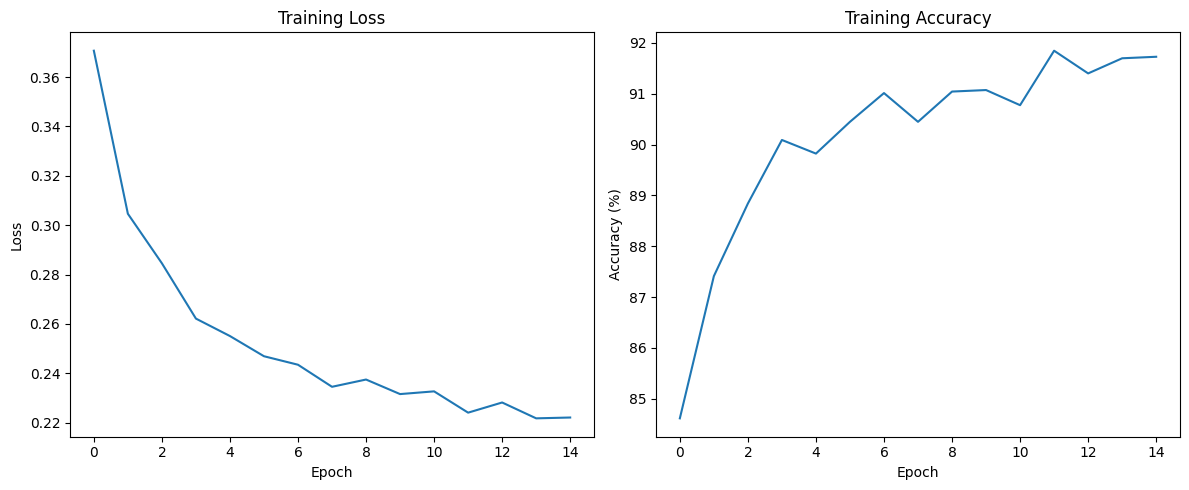


===== Generating ViT Attention Visualizations =====


`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


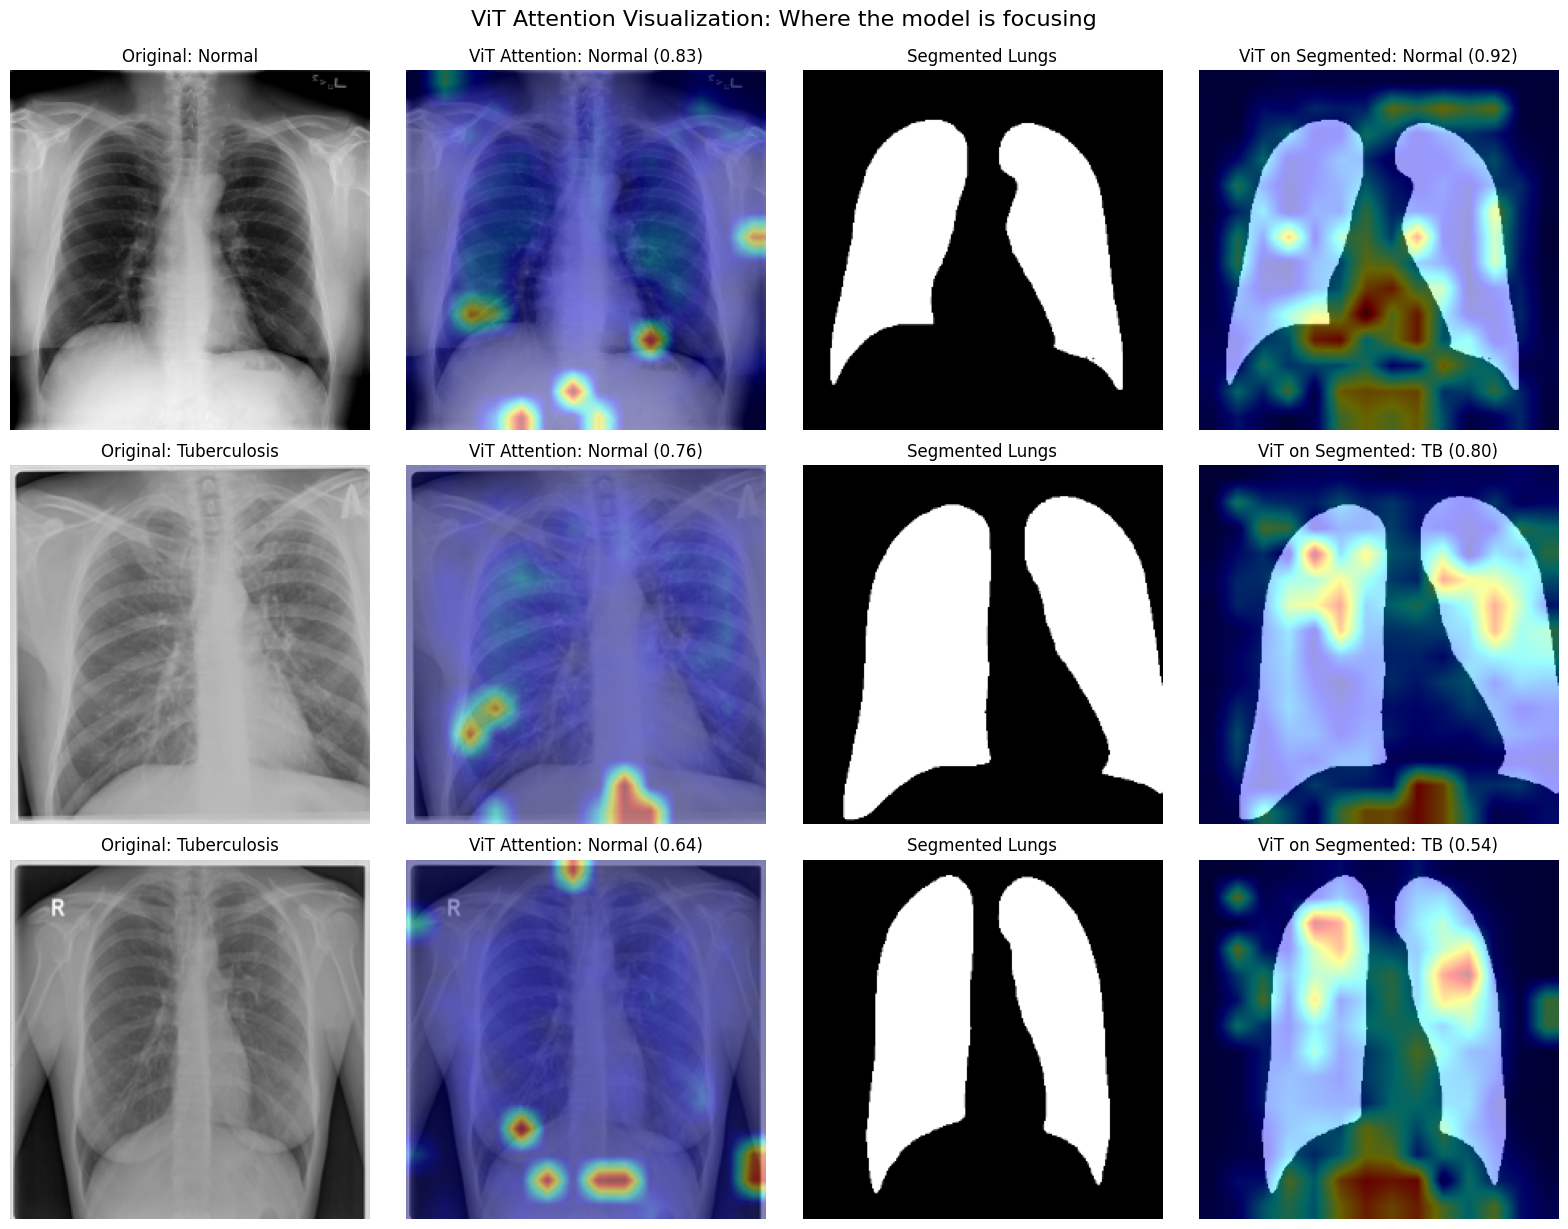


Model saved successfully.

Total runtime: 0h 7m 31s


In [ ]:
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
        print(f"GPU Memory Reserved: {torch.cuda.memory_reserved()/1e9:.2f} GB")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print_gpu_memory()


def load_segmentation_model():
    print("Loading pretrained chest X-ray segmentation model...")
    try:
        model = AutoModel.from_pretrained("ianpan/chest-x-ray-basic", trust_remote_code=True)
        model = model.eval().to(device)
        print("Successfully loaded pretrained segmentation model")
        return model
    except Exception as e:
        print(f"Error loading pretrained model: {e}")
        print("Using fallback segmentation method")
        return None


def basic_lung_segmentation(image):
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    
    _, binary = cv2.threshold(enhanced, 90, 255, cv2.THRESH_BINARY)
    
    
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    
    if len(image.shape) == 3:
        mask = np.stack([binary, binary, binary], axis=2) / 255.0
    else:
        mask = binary / 255.0
    
    segmented = image * mask
    
    return segmented


def segment_lungs(image, model=None):
    if model is None:
        return basic_lung_segmentation(image)
    
    
    orig_h, orig_w = image.shape[:2]
    
    
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray_img = image
    
    try:
        
        x = model.preprocess(gray_img)  
        x = torch.from_numpy(x).unsqueeze(0).unsqueeze(0)  
        x = x.float().to(device)
        
        
        with torch.no_grad():
            out = model(x)
            torch.cuda.synchronize()  
        
        
        mask = out["mask"].squeeze().cpu().numpy()
        
        
        mask = mask.argmax(0)
        
        
        binary_mask = np.zeros_like(mask)
        binary_mask[mask == 1] = 1 
        binary_mask[mask == 2] = 1  
        
        
        if binary_mask.shape[0] != orig_h or binary_mask.shape[1] != orig_w:
            binary_mask = cv2.resize(binary_mask.astype(np.float32), (orig_w, orig_h))
        
        
        if len(image.shape) == 3:
            segmented = image * np.expand_dims(binary_mask, axis=2)
        else:
            segmented = image * binary_mask
        
       
        if segmented.dtype == np.float32 or segmented.dtype == np.float64:
            
            segmented = np.clip(segmented, 0, 1)
            segmented = (segmented * 255).astype(np.uint8)
        
        return segmented
    
    except Exception as e:
        print(f"Error in segmentation: {e}")
        print(traceback.format_exc())
        return basic_lung_segmentation(image)

# Preprocess and cache segmented images
def preprocess_and_cache_segmented_images(df, model, cache_dir='segmented_cache'):
    os.makedirs(cache_dir, exist_ok=True)
    
    print("Pre-processing and caching segmented images...")
    processed_count = 0
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        
        src_path = row['image_path']
        filename = os.path.basename(src_path)
        dest_path = os.path.join(cache_dir, filename)
        
        
        if os.path.exists(dest_path):
            processed_count += 1
            continue
        
        
        try:
            img = cv2.imread(src_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            
            segmented = segment_lungs(img, model)
            
            
            segmented = cv2.resize(segmented, (224, 224))
            
            
            cv2.imwrite(dest_path, cv2.cvtColor(segmented, cv2.COLOR_RGB2BGR))
            processed_count += 1
            
            
            if idx % 100 == 0:
                torch.cuda.empty_cache()
                
        except Exception as e:
            print(f"Error processing {src_path}: {e}")
    
    print(f"Processed {processed_count} images. Cached at {cache_dir}/")
    
    
    new_df = df.copy()
    new_df['segmented_path'] = new_df['image_path'].apply(
        lambda x: os.path.join(cache_dir, os.path.basename(x))
    )
    
    return new_df


class OptimizedChestXRayDataset(Dataset):
    def __init__(self, dataframe, transform=None, use_segmented_paths=True):
        self.dataframe = dataframe
        self.transform = transform
        self.use_segmented_paths = use_segmented_paths and 'segmented_path' in dataframe.columns
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        
        if self.use_segmented_paths:
            img_path = self.dataframe.iloc[idx]['segmented_path']
        else:
            img_path = self.dataframe.iloc[idx]['image_path']
            
        label = 1 if self.dataframe.iloc[idx]['label'] == 'Tuberculosis' else 0
        
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        if img.shape[:2] != (224, 224):
            img = cv2.resize(img, (224, 224))
        
        
        if self.transform:
            
            if img.dtype == np.float32 or img.dtype == np.float64:
                img = np.clip(img, 0, 1)
                img = (img * 255).astype(np.uint8)
            
            img = self.transform(img)
        
        return img, label


def get_vit_transforms(is_training=True):
    """Get image transformations optimized for ViT"""
    if is_training:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
        ])
    else:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
        ])


def create_optimized_dataloaders(train_df, test_df, batch_size=8):
    train_transform = get_vit_transforms(is_training=True)
    test_transform = get_vit_transforms(is_training=False)
    
    train_dataset = OptimizedChestXRayDataset(
        train_df, 
        transform=train_transform,
        use_segmented_paths=True
    )
    
    test_dataset = OptimizedChestXRayDataset(
        test_df, 
        transform=test_transform,
        use_segmented_paths=True
    )
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0,  
        pin_memory=True  
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0,
        pin_memory=True
    )
    
    return train_loader, test_loader


def setup_vit_model(num_classes=2, model_name="google/vit-base-patch16-224"):
    """Load and configure ViT for transfer learning"""
    print(f"Loading pretrained Vision Transformer: {model_name}...")
    
    
    model = ViTForImageClassification.from_pretrained(
        model_name,
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    )
    
    
    for param in model.vit.parameters():
        param.requires_grad = False
    
    
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    print(f"Vision Transformer loaded successfully with {num_classes} output classes")
    return model


def train_vit_model(model, train_loader, criterion, optimizer, device, num_epochs=15, use_early_stopping=False, patience=3):

    model.to(device)
    history = {'train_loss': [], 'train_acc': []}
    
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        batch_count = 0
        start_time = time.time()
        
        try:
            for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
                
                if batch_count == 0:
                    print_gpu_memory()
                
                inputs, labels = inputs.to(device), labels.to(device)
                
                
                optimizer.zero_grad()
                
                
                outputs = model(inputs)
                loss = criterion(outputs.logits, labels)  
                
                
                loss.backward()
                optimizer.step()
                
                
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.logits, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                
                torch.cuda.empty_cache()
                batch_count += 1
                
                
                if batch_count % 10 == 0:
                    batch_acc = 100 * correct / total
                    print(f"Batch {batch_count}, Loss: {loss.item():.4f}, Running Acc: {batch_acc:.2f}%")
            
            
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = 100 * correct / total
            epoch_time = time.time() - start_time
            
            
            history['train_loss'].append(epoch_loss)
            history['train_acc'].append(epoch_acc)
            
            print(f'Epoch {epoch+1}/{num_epochs}, '
                  f'Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, '
                  f'Time: {epoch_time:.1f}s')
            
            
            torch.save(model.state_dict(), f'vit_tb_epoch_{epoch+1}.pth')
            
            
            if use_early_stopping:
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    patience_counter = 0
                    torch.save(model.state_dict(), 'best_vit_tb.pth')
                    print("Saved best model checkpoint")
                else:
                    patience_counter += 1
                    print(f"No improvement in loss. Patience: {patience_counter}/{patience}")
                    
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break
            else:
                
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), 'best_vit_tb.pth')
                    print("Saved best model checkpoint")
                
        except Exception as e:
            print(f"Error during training: {e}")
            print(traceback.format_exc())
            
            torch.save(model.state_dict(), 'emergency_vit_tb.pth')
            print("Saved emergency checkpoint due to error")
            break
    
    
    try:
        model.load_state_dict(torch.load('best_vit_tb.pth'))
        print("Loaded best model for evaluation")
    except:
        print("Could not load best model, using current model")
    
    return model, history


def evaluate_vit_model(model, test_loader, device):
    """Evaluate the ViT model with memory optimization"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs.logits, 1)  
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            
            torch.cuda.empty_cache()
    
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
    
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    
    if conf_matrix.size == 4:  
        tn, fp, fn, tp = conf_matrix.ravel()
    else:
       
        print("Warning: Could not unpack confusion matrix")
        tn, fp, fn, tp = 0, 0, 0, 0
    
    accuracy = accuracy_score(all_labels, all_preds) * 100
    
    
    try:
        precision = precision_score(all_labels, all_preds) * 100
    except:
        precision = 0
        
    try:
        recall = recall_score(all_labels, all_preds) * 100
    except:
        recall = 0
        
    try:
        f1 = f1_score(all_labels, all_preds) * 100
    except:
        f1 = 0
        
    try:
        specificity = tn / (tn + fp) * 100 if (tn + fp) > 0 else 0
    except:
        specificity = 0
    
    try:
        auc = roc_auc_score(all_labels, all_preds) * 100
    except:
        auc = 0
    
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'auc': auc,
        'confusion_matrix': conf_matrix
    }
    
    return results


class ViTAttentionVisualizer:
    def __init__(self, model, device=None):
        self.model = model
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.model.eval()
    
    def visualize(self, image_path, use_segmented=False, segmentation_model=None):
       
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        if use_segmented and segmentation_model is not None:
            img = segment_lungs(img, segmentation_model)
        
        
        img_resized = cv2.resize(img, (224, 224))
        
        
        if img_resized.dtype != np.uint8:
            img_resized = np.clip(img_resized, 0, 1) * 255
            img_resized = img_resized.astype(np.uint8)
        
        
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        
        img_tensor = transform(img_resized).unsqueeze(0).to(self.device)
        
        
        with torch.no_grad():
            outputs = self.model(img_tensor, output_attentions=True)
            logits = outputs.logits
            pred_class = torch.argmax(logits, dim=-1).item()
            pred_score = torch.softmax(logits, dim=-1)[0, pred_class].item()
            
            
            attn = outputs.attentions[-1]  
            
            
            attn = attn.mean(dim=1)[0]  
            
            
            cls_attn = attn[0, 1:]  
            
            
            patch_size = 16  
            grid_size = 224 // patch_size  
            attn_map = cls_attn.reshape(grid_size, grid_size).cpu().numpy()
            
            
            attn_map = cv2.resize(attn_map, (img_resized.shape[1], img_resized.shape[0]))
            
            
            attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)
            heatmap = cv2.applyColorMap(np.uint8(255 * attn_map), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            
            
            attn_img = (heatmap * 0.4 + img_resized * 0.6).astype(np.uint8)
            
            return img_resized, attn_img, pred_class, pred_score


def visualize_attention(model, test_df, segmentation_model=None, device=None, num_samples=3):
    
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    
    normal_df = test_df[test_df['label'] == 'Normal'].sample(num_samples//2)
    tb_df = test_df[test_df['label'] == 'Tuberculosis'].sample(num_samples - num_samples//2)
    sample_df = pd.concat([normal_df, tb_df])
    
    
    visualizer = ViTAttentionVisualizer(model, device=device)
    
    
    fig, axes = plt.subplots(len(sample_df), 4, figsize=(16, 4*len(sample_df)))
    
    
    if len(sample_df) == 1:
        axes = np.expand_dims(axes, axis=0)
    
    
    for i, (_, row) in enumerate(sample_df.iterrows()):
        try:
            
            img_path = row['image_path']
            label = row['label']
            
            
            if segmentation_model is not None and next(segmentation_model.parameters()).device != device:
                segmentation_model = segmentation_model.to(device)
            
            
            orig_img, orig_attn, orig_pred, orig_score = visualizer.visualize(
                img_path, 
                use_segmented=False
            )
            
            
            seg_img, seg_attn, seg_pred, seg_score = visualizer.visualize(
                img_path, 
                use_segmented=True,
                segmentation_model=segmentation_model
            )
            
            # Plot results
            axes[i, 0].imshow(orig_img)
            axes[i, 0].set_title(f"Original: {label}")
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(orig_attn)
            axes[i, 1].set_title(f"ViT Attention: {'TB' if orig_pred == 1 else 'Normal'} ({orig_score:.2f})")
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(seg_img)
            axes[i, 2].set_title(f"Segmented Lungs")
            axes[i, 2].axis('off')
            
            axes[i, 3].imshow(seg_attn)
            axes[i, 3].set_title(f"ViT on Segmented: {'TB' if seg_pred == 1 else 'Normal'} ({seg_score:.2f})")
            axes[i, 3].axis('off')
            
        except Exception as e:
            print(f"Error visualizing image {img_path}: {e}")
            traceback.print_exc()
    
    plt.tight_layout()
    plt.suptitle("ViT Attention Visualization: Where the model is focusing", fontsize=16, y=1.02)
    plt.savefig('vit_attention_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    if segmentation_model is not None:
        segmentation_model = segmentation_model.cpu()
    torch.cuda.empty_cache()
    
    return fig


def main():
    
    total_start_time = time.time()
    
    
    base_path = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database'
    normal_path = os.path.join(base_path, 'Normal')
    tb_path = os.path.join(base_path, 'Tuberculosis')
    
    def create_dataset_df(normal_dir, tb_dir):
        normal_files = glob(os.path.join(normal_dir, '*.png'))
        tb_files = glob(os.path.join(tb_dir, '*.png'))
        
        files = normal_files + tb_files
        labels = ['Normal'] * len(normal_files) + ['Tuberculosis'] * len(tb_files)
        
        return pd.DataFrame({
            'image_path': files,
            'label': labels
        })
    
    
    print("Creating dataset dataframe...")
    df = create_dataset_df(normal_path, tb_path)
    
    print("\nDataset Information:")
    print(f"Total number of images: {len(df)}")
    print(f"Class distribution:\n{df['label'].value_counts()}")
    
    
    train_df, test_df = train_test_split(
        df, 
        test_size=0.2, 
        random_state=42,
        stratify=df['label']
    )
    
    print("\nTrain/Test Split:")
    print(f"Training set: {len(train_df)} images")
    print(f"Testing set: {len(test_df)} images")
    
    try:
        
        segmentation_model = load_segmentation_model()
        
        
        cache_dir = '/kaggle/working/segmented_cache'
        train_df = preprocess_and_cache_segmented_images(train_df, segmentation_model, cache_dir)
        test_df = preprocess_and_cache_segmented_images(test_df, segmentation_model, cache_dir)
        
        
        segmentation_model = segmentation_model.cpu()
        torch.cuda.empty_cache()
        print_gpu_memory()
        
        
        print("\nCreating data loaders with pre-segmented lung images...")
        train_loader, test_loader = create_optimized_dataloaders(
            train_df, test_df, batch_size=8
        )
        
        
        model = setup_vit_model(num_classes=2, model_name="google/vit-base-patch16-224")
        model = model.to(device)
        
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=1e-4,
            weight_decay=0.01
        )
        
        
        print("\n===== Training Vision Transformer with Segmented Lungs =====")
        print_gpu_memory()
        model, history = train_vit_model(
            model, train_loader, criterion, optimizer, device, 
            num_epochs=15,
            use_early_stopping=False
        )
        
        
        print("\n===== Evaluating ViT Model =====")
        results = evaluate_vit_model(model, test_loader, device)
        
        
        print("\n===== Results Summary =====")
        print(f"Accuracy: {results['accuracy']:.2f}%")
        print(f"Precision: {results['precision']:.2f}%")
        print(f"Sensitivity/Recall: {results['recall']:.2f}%")
        print(f"F1 Score: {results['f1_score']:.2f}%")
        print(f"Specificity: {results['specificity']:.2f}%")
        print(f"AUC: {results['auc']:.2f}%")
        print("\nConfusion Matrix:")
        print(results['confusion_matrix'])
        
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'])
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'])
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        
        plt.tight_layout()
        plt.savefig('vit_training_history.png', dpi=300)
        plt.show()
        
        
        print("\n===== Generating ViT Attention Visualizations =====")
        try:
            
            visualize_attention(
                model=model,
                test_df=test_df,
                segmentation_model=segmentation_model,
                device=device,
                num_samples=3
            )
            
        except Exception as e:
            print(f"Error in visualization: {e}")
            traceback.print_exc()
        
        
        torch.save(model.state_dict(), 'vit_tb_segmented.pth')
        print("\nModel saved successfully.")
        
    except Exception as e:
        print(f"Error in main execution: {e}")
        print(traceback.format_exc())
    
    finally:
        
        total_time = time.time() - total_start_time
        hours, remainder = divmod(total_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f"\nTotal runtime: {int(hours)}h {int(minutes)}m {int(seconds)}s")


if __name__ == "__main__":
    try:
        import torch.multiprocessing as mp
        mp.set_start_method('spawn', force=True)
    except RuntimeError:
        
        pass
    
    main()


In [1]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CACHE_DIR = '/kaggle/working/segmented_cache'


def basic_lung_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if image.ndim == 3 else image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    _, binary = cv2.threshold(enhanced, 90, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    mask = binary / 255.0
    return (image * mask[:, :, None]).astype(np.uint8) if image.ndim == 3 else image * mask

def preprocess_and_cache(df):
    os.makedirs(CACHE_DIR, exist_ok=True)
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Caching segmentation"):
        src = row['image_path']
        dst = os.path.join(CACHE_DIR, os.path.basename(src))
        if not os.path.exists(dst):
            img = cv2.imread(src)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            seg = basic_lung_segmentation(img)
            seg = cv2.resize(seg, (224, 224))
            cv2.imwrite(dst, cv2.cvtColor(seg, cv2.COLOR_RGB2BGR))
    df['segmented_path'] = df['image_path'].apply(lambda p: os.path.join(CACHE_DIR, os.path.basename(p)))
    return df


def get_transforms(train):
    ts = [transforms.ToPILImage(), transforms.Resize((224, 224))]
    if train:
        ts += [transforms.RandomHorizontalFlip(), transforms.RandomRotation(10)]
    ts += [transforms.ToTensor(), transforms.Normalize([0.5] * 3, [0.5] * 3)]
    return transforms.Compose(ts)

class TBChestXRayDataset(Dataset):
    def __init__(self, df, transform): self.df, self.transform = df.reset_index(drop=True), transform
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        img = cv2.imread(self.df.loc[i, 'segmented_path'], cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        if self.transform: img = self.transform(img)
        label = 1 if self.df.loc[i, 'label'] == 'Tuberculosis' else 0
        return img, label


class Conv2d_BN(nn.Sequential):
    def __init__(self, a, b, ks=1, stride=1, pad=0, groups=1, bn_init=1):
        conv = nn.Conv2d(a, b, ks, stride, pad, groups=groups, bias=False)
        bn = nn.BatchNorm2d(b)
        super().__init__(conv, bn)
        nn.init.constant_(bn.weight, bn_init)
        nn.init.constant_(bn.bias, 0)

class Residual(nn.Module):
    def __init__(self, m): super().__init__(); self.m = m
    def forward(self, x): return x + self.m(x)

class FFN(nn.Module):
    def __init__(self, ed, h): super().__init__(); self.ffn = nn.Sequential(Conv2d_BN(ed, h), nn.ReLU(), Conv2d_BN(h, ed, bn_init=0))
    def forward(self, x): return self.ffn(x)

class MedicalXRayAttention(nn.Module):
    def __init__(self, C):
        super().__init__()
        self.roi = nn.Sequential(nn.Conv2d(C, C//2, 3, 1, 1), nn.ReLU(), nn.Conv2d(C//2, 4, 1), nn.Sigmoid())
        self.ca  = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Conv2d(C, C//16, 1), nn.ReLU(), nn.Conv2d(C//16, C, 1), nn.Sigmoid())
        self.sa  = nn.Sequential(nn.Conv2d(2, 1, 7, 1, 3), nn.Sigmoid())
    def forward(self, x):
        B, C, H, W = x.shape
        coords = self.roi(x).mean((2, 3))
        out = []
        for i in range(B):
            x1, y1, x2, y2 = (coords[i] * torch.tensor([W, H, W, H], device=x.device)).int()
            x1, y1 = x1.clamp(0, W-1), y1.clamp(0, H-1)
            x2, y2 = x2.clamp(x1+1, W), y2.clamp(y1+1, H)
            crop = x[i:i+1, :, y1:y2, x1:x2]
            out.append(F.interpolate(crop, (H, W), mode='bilinear', align_corners=False))
        x = torch.cat(out, 0)
        x = x * self.ca(x)
        pooled = torch.cat([x.max(1, keepdim=True)[0], x.mean(1, keepdim=True)], dim=1)
        return x * self.sa(pooled)

class EfficientViTBlock(nn.Module):
    def __init__(self, ed):
        super().__init__()
        self.ffn1 = Residual(FFN(ed, ed * 2))
        self.mxa  = Residual(MedicalXRayAttention(ed))
        self.ffn2 = Residual(FFN(ed, ed * 2))
    def forward(self, x):
        return self.ffn2(self.mxa(self.ffn1(x)))

class EfficientViT(nn.Module):
    def __init__(self, in_ch=3, num_classes=1):
        super().__init__()
        self.patch  = nn.Sequential(Conv2d_BN(in_ch, 64, 7, 2, 3), nn.ReLU(), Conv2d_BN(64, 128, 3, 2, 1), nn.ReLU())
        self.blocks = nn.Sequential(*[EfficientViTBlock(128) for _ in range(6)])
        self.head   = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.patch(x)
        x = self.blocks(x)
        x = F.adaptive_avg_pool2d(x, 1).flatten(1)
        return self.head(x).squeeze(1)

def train_epoch(model, dl, crit, opt):
    model.train(); total, correct, loss_sum = 0, 0, 0.0
    for x, y in dl:
        x, y = x.to(device), y.float().to(device)
        opt.zero_grad(); logits = model(x); loss = crit(logits, y)
        loss.backward(); opt.step()
        preds = (torch.sigmoid(logits) > 0.5).long()
        correct += (preds == y.long()).sum().item(); total += x.size(0)
        loss_sum += loss.item() * x.size(0)
    return loss_sum / total, correct / total

def eval_model(model, dl):
    model.eval(); preds, labels = [], []
    with torch.no_grad():
        for x, y in dl:
            logits = model(x.to(device))
            preds += (torch.sigmoid(logits) > 0.5).long().cpu().tolist()
            labels += y.tolist()
    return metrics.accuracy_score(labels, preds), metrics.roc_auc_score(labels, preds)


class GradCAMVisualizer:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.gradients = None
        self.activations = None
        def save_grad(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        def save_activation(module, input, output):
            self.activations = output
        self.model.blocks[-1].register_forward_hook(save_activation)
        self.model.blocks[-1].register_full_backward_hook(save_grad)

    def generate(self, image_tensor, raw_image, save_path):
        image_tensor = image_tensor.unsqueeze(0).to(device)
        self.model.zero_grad()
        output = self.model(image_tensor)
        pred = torch.sigmoid(output).item()
        output.backward()
        grads = self.gradients.squeeze().mean(dim=(1, 2))
        act = self.activations.squeeze()
        cam = torch.sum(grads[:, None, None] * act, dim=0).cpu().detach().numpy()
        cam = np.maximum(cam, 0)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        cam = cv2.resize(cam, (224, 224))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        overlay = (heatmap * 0.4 + raw_image * 0.6).astype(np.uint8)
        cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
        return pred

def visualize_gradcam(model, sample_df, transform):
    visualizer = GradCAMVisualizer(model)
    for _, row in sample_df.iterrows():
        img_path = row['segmented_path']
        raw_img = cv2.imread(img_path)
        raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
        tensor_img = transform(raw_img)
        pred = visualizer.generate(tensor_img, raw_img, f"/kaggle/working/cam_{os.path.basename(img_path)}")


def main():
    base = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database'
    df = pd.DataFrame({
        'image_path': glob(f"{base}/Normal/*.png") + glob(f"{base}/Tuberculosis/*.png"),
        'label': ['Normal'] * len(glob(f"{base}/Normal/*.png")) + ['Tuberculosis'] * len(glob(f"{base}/Tuberculosis/*.png"))
    })

    df = preprocess_and_cache(df)
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
    train_dl = DataLoader(TBChestXRayDataset(train_df, get_transforms(True)), batch_size=16, shuffle=True, num_workers=2)
    test_dl  = DataLoader(TBChestXRayDataset(test_df,  get_transforms(False)), batch_size=16, shuffle=False, num_workers=2)

    model = EfficientViT().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)

    for epoch in range(15):
        loss, acc = train_epoch(model, train_dl, criterion, optimizer)
        print(f"Epoch {epoch+1}: Loss={loss:.4f}, Accuracy={acc:.4f}")

    acc, auc = eval_model(model, test_dl)
    print(f"Final Test Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    torch.save(model.state_dict(), '/kaggle/working/efficientvit_tb.pth')

    visualize_gradcam(model, test_df.sample(3), transform=get_transforms(False))

if __name__ == '__main__':
    main()


Caching segmentation: 100%|██████████| 4200/4200 [02:36<00:00, 26.76it/s]


Epoch 1: Loss=0.3908, Accuracy=0.8479
Epoch 2: Loss=0.3102, Accuracy=0.8810
Epoch 3: Loss=0.2703, Accuracy=0.9024
Epoch 4: Loss=0.2552, Accuracy=0.9033
Epoch 5: Loss=0.2413, Accuracy=0.9074
Epoch 6: Loss=0.2189, Accuracy=0.9185
Epoch 7: Loss=0.2179, Accuracy=0.9179
Epoch 8: Loss=0.2136, Accuracy=0.9185
Epoch 9: Loss=0.2084, Accuracy=0.9199
Epoch 10: Loss=0.1941, Accuracy=0.9271
Epoch 11: Loss=0.1903, Accuracy=0.9253
Epoch 12: Loss=0.1895, Accuracy=0.9298
Epoch 13: Loss=0.1884, Accuracy=0.9301
Epoch 14: Loss=0.1818, Accuracy=0.9304
Epoch 15: Loss=0.1784, Accuracy=0.9336
Final Test Accuracy: 0.6619, AUC: 0.7743


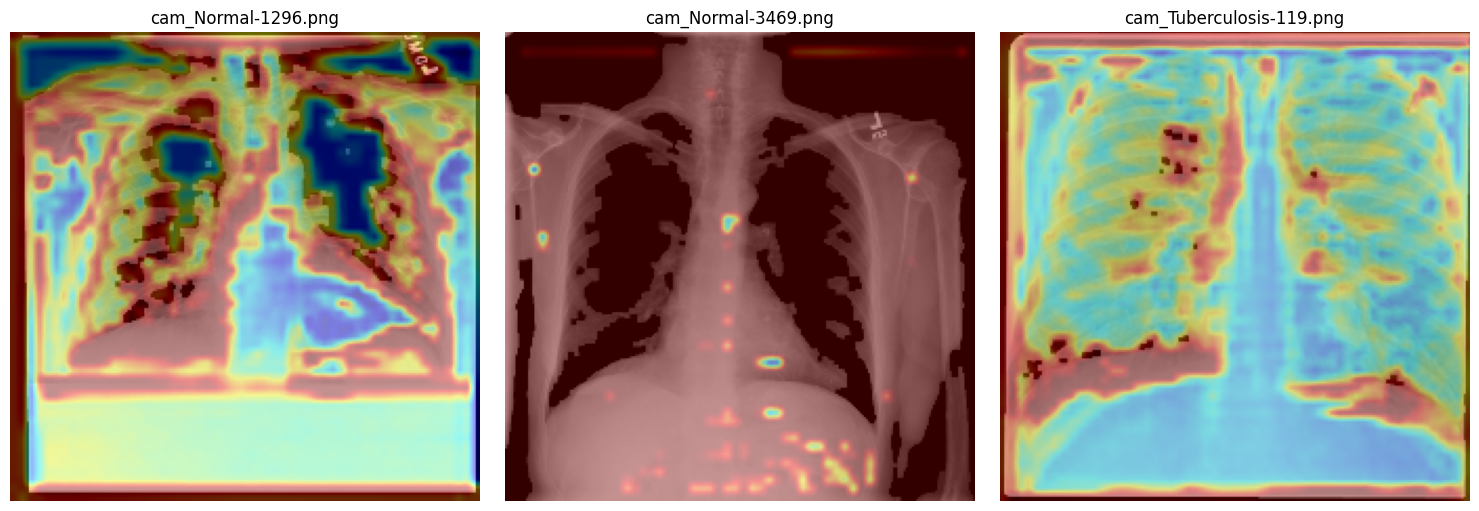

In [32]:

import matplotlib.pyplot as plt
import cv2
import glob

def show_cam_images(cam_dir="/kaggle/working", num_images=3):
    cam_paths = sorted(glob.glob(f"{cam_dir}/cam_*.png"))[:num_images]
    if not cam_paths:
        print("No CAM images found.")
        return

    plt.figure(figsize=(5 * num_images, 5))
    for i, path in enumerate(cam_paths):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(path), fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# showing top 3 images
show_cam_images()


In [13]:
data = pd.read_excel('/kaggle/input/tb-pos-dl-proj/tuberculosis dataset.xlsx')
data = data.dropna()
data.rename(columns={
    'CO': 'Cough', 
    'NS': 'Night sweats', 
    'BD': 'Difficulty in Breathing',
    'FV': 'Fever',
    'CP': 'Chest Pain',
    'SP': 'Sputum',
    'LP': 'Loss of pleasure',
    'CH': 'Chills',
    'LC': 'Lack of concentration',
    'IR': 'Irritation',
    'LA': 'Loss of appetite',
    'LE': 'Loss of energy',
    'LNE': 'Lymph Node Enlargement',
    'SBP': 'Systolic Blood Pressure',
    'BMI': 'Body Mass Index',
    'IS': 'Immune Suppression'
}, inplace=True)
def transform_to_hot(dataset):
    # if value is >=1 then 1 else 0
    dataset['Cough'] = np.where(dataset['Cough'] >= 1, 1, 0)
    dataset['Night sweats'] = np.where(dataset['Night sweats'] >= 1, 1, 0)
    dataset['Difficulty in Breathing'] = np.where(dataset['Difficulty in Breathing'] >= 1, 1, 0)
    dataset['Fever'] = np.where(dataset['Fever'] >= 1, 1, 0)
    dataset['Chest Pain'] = np.where(dataset['Chest Pain'] >= 1, 1, 0)
    dataset['Sputum'] = np.where(dataset['Sputum'] >= 1, 1, 0)
    dataset['Loss of pleasure'] = np.where(dataset['Loss of pleasure'] >= 1, 1, 0)
    dataset['Chills'] = np.where(dataset['Chills'] >= 1, 1, 0)
    dataset['Lack of concentration'] = np.where(dataset['Lack of concentration'] >= 1, 1, 0)
    dataset['Irritation'] = np.where(dataset['Irritation'] >= 1, 1, 0)
    dataset['Loss of appetite'] = np.where(dataset['Loss of appetite'] >= 1, 1, 0)
    dataset['Loss of energy'] = np.where(dataset['Loss of energy'] >= 1, 1, 0)
    dataset['Lymph Node Enlargement'] = np.where(dataset['Lymph Node Enlargement'] >= 1, 1, 0)
    dataset['Systolic Blood Pressure'] = np.where(dataset['Systolic Blood Pressure'] >= 1, 1, 0)
    dataset['Body Mass Index'] = np.where(dataset['Body Mass Index'] >= 1, 1, 0)
    dataset['Immune Suppression'] = np.where(dataset['Immune Suppression'] >= 1, 1, 0)
    return dataset
data = transform_to_hot(data)
data['is_tb'] = 1
data.sample(6)


Cough  Night sweats  Difficulty in Breathing  Fever  Chest Pain  Sputum  \
426      1             1                        0      1           1       1   
100      1             1                        0      1           1       1   
383      1             1                        1      0           0       0   
80       1             0                        1      0           0       1   
148      1             0                        1      1           1       0   
86       1             1                        0      1           1       1   

     Immune Suppression  Loss of pleasure  Chills  Lack of concentration  \
426                   1                 1       0                      1   
100                   1                 1       0                      1   
383                   1                 1       1                      0   
80                    1                 0       1                      0   
148                   1                 0       1                      1   
86                    1                 1       0                      1   

     Irritation  Loss of appetite  Loss of energy  Lymph Node Enlargement  \
426           1                 1               1                       1   
100           1                 1               1                       1   
383           0                 0               1                       1   
80            0                 1               1                       0   
148           1                 0               1                       0   
86            1                 1               1                       1   

     Systolic Blood Pressure  Body Mass Index  is_tb  
426                        0                1      1  
100                        0                1      1  
383                        1                0      1  
80                         1                0      1  
148                        1                1      1  
86                         0                1      1

In [14]:
X = data.drop(columns=['is_tb'])
y = data['is_tb']
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
common_X_cols = X_train.columns.intersection(X_train_pos.columns)
X_train_merged = pd.concat([X_train[common_X_cols], X_train_pos[common_X_cols]], ignore_index=True)
X_test_merged = pd.concat([X_test[common_X_cols], X_test_pos[common_X_cols]], ignore_index=True)
y_train_merged = pd.concat([y_train, y_train_pos], ignore_index=True)
y_test_merged = pd.concat([y_test, y_test_pos], ignore_index=True)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_merged)
X_test_scaled = scaler.transform(X_test_merged)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_merged.values.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_merged.values.reshape(-1, 1), dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=(device.type == 'cuda'), num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=(device.type == 'cuda'), num_workers=0)


In [17]:
class TBClassifier(nn.Module):
    def __init__(self, input_size=4):
        super(TBClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 1)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)
        self.swish = nn.SiLU()
        
    def forward(self, x):
        x = self.dropout1(self.swish(self.bn1(self.fc1(x))))
        x = self.dropout2(self.swish(self.bn2(self.fc2(x))))
        x = self.dropout3(self.swish(self.bn3(self.fc3(x))))
        x = self.fc4(x)
        return x

In [18]:
model = TBClassifier().to(device)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()


y_train_tensor_cpu = y_train_tensor.cpu() if y_train_tensor.is_cuda else y_train_tensor
neg_count_train = len(y_train_tensor_cpu) - y_train_tensor_cpu.sum().item()
pos_count_train = y_train_tensor_cpu.sum().item()
weights_train = torch.tensor([1. / neg_count_train, 1. / pos_count_train], dtype=torch.float32)
samples_weights_train = weights_train[y_train_tensor_cpu.long()].flatten()
sampler = WeightedRandomSampler(weights=samples_weights_train,num_samples=len(samples_weights_train),replacement=True)
train_loader = DataLoader(train_dataset,batch_size=64,sampler=sampler,num_workers=0,pin_memory=True if device.type == 'cuda' else False)
print("\n[Train] Class distribution info:")
print(f"Negative samples: {neg_count_train}")
print(f"Positive samples: {pos_count_train}")
print(f"Class weights: {weights_train.tolist()}")
print(f"Sample weights shape: {samples_weights_train.shape}")
y_test_tensor_cpu = y_test_tensor.cpu() if y_test_tensor.is_cuda else y_test_tensor
neg_count_test = len(y_test_tensor_cpu) - y_test_tensor_cpu.sum().item()
pos_count_test = y_test_tensor_cpu.sum().item()
weights_test = torch.tensor([1. / neg_count_test, 1. / pos_count_test], dtype=torch.float32)
samples_weights_test = weights_test[y_test_tensor_cpu.long()].flatten()

criterion = FocalLoss(alpha=0.75, gamma=2.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3,weight_decay=1e-5)


print("\n[Test] Class distribution info:")
print(f"Negative samples: {neg_count_test}")
print(f"Positive samples: {pos_count_test}")
print(f"Class weights: {weights_test.tolist()}")
print(f"Sample weights shape: {samples_weights_test.shape}")



[Train] Class distribution info:
Negative samples: 390.0
Positive samples: 345.0
Class weights: [0.0025641026441007853, 0.0028985508251935244]
Sample weights shape: torch.Size([735])

[Test] Class distribution info:
Negative samples: 413.0
Positive samples: 149.0
Class weights: [0.002421307610347867, 0.00671140942722559]
Sample weights shape: torch.Size([562])


In [19]:

num_epochs = 50
best_f1 = 0
patience = 10
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1, 1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    y_scores, y_true = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            y_scores.extend(probs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    y_pred = (np.array(y_scores) > optimal_threshold).astype(int)
    epoch_f1 = f1_score(y_true, y_pred, zero_division=0)
    epoch_precision = precision_score(y_true, y_pred, zero_division=0)
    epoch_recall = recall_score(y_true, y_pred, zero_division=0)
    epoch_accuracy = accuracy_score(y_true, y_pred)
    if epoch_f1 > best_f1:
        best_f1 = epoch_f1
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f" Early stopping triggered at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}: Loss={running_loss/len(train_loader):.4f}, "
          f"F1={epoch_f1:.4f}, Precision={epoch_precision:.4f}, "
          f"Recall={epoch_recall:.4f}, Accuracy={epoch_accuracy:.4f}, "
          f"Threshold={optimal_threshold:.4f}")


Epoch 1: Loss=0.0529, F1=0.9375, Precision=0.9712, Recall=0.9060, Accuracy=0.9680, Threshold=0.5238
Epoch 2: Loss=0.0171, F1=0.9375, Precision=0.9712, Recall=0.9060, Accuracy=0.9680, Threshold=0.5691
Epoch 3: Loss=0.0203, F1=0.9400, Precision=0.9338, Recall=0.9463, Accuracy=0.9680, Threshold=0.5425
Epoch 4: Loss=0.0207, F1=0.9400, Precision=0.9338, Recall=0.9463, Accuracy=0.9680, Threshold=0.5158
Epoch 5: Loss=0.0211, F1=0.9400, Precision=0.9338, Recall=0.9463, Accuracy=0.9680, Threshold=0.5329
Epoch 6: Loss=0.0167, F1=0.9412, Precision=0.9172, Recall=0.9664, Accuracy=0.9680, Threshold=0.4201
Epoch 7: Loss=0.0215, F1=0.9400, Precision=0.9338, Recall=0.9463, Accuracy=0.9680, Threshold=0.6349
Epoch 8: Loss=0.0222, F1=0.9375, Precision=0.9712, Recall=0.9060, Accuracy=0.9680, Threshold=0.6741
Epoch 9: Loss=0.0246, F1=0.9412, Precision=0.9172, Recall=0.9664, Accuracy=0.9680, Threshold=0.5434
Epoch 10: Loss=0.0235, F1=0.9283, Precision=0.9444, Recall=0.9128, Accuracy=0.9626, Threshold=0.5141

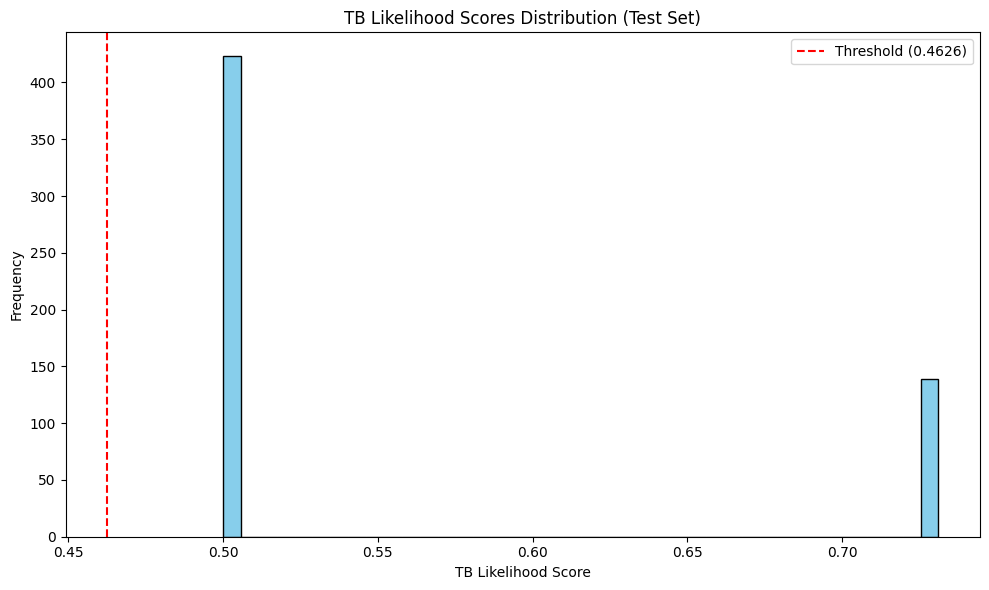

In [20]:

y_pred_prob = torch.sigmoid(torch.tensor(y_pred))  
y_pred_prob = y_pred_prob.flatten().cpu().numpy()
plt.figure(figsize=(10, 6))
plt.hist(y_pred_prob, bins=40, color='skyblue', edgecolor='black')
plt.axvline(x=0.4626, color='red', linestyle='--', label='Threshold (0.4626)')
plt.title('TB Likelihood Scores Distribution (Test Set)')
plt.xlabel('TB Likelihood Score')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


In [21]:


def model_predict(input_data):
    with torch.no_grad():
        input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)  
        output = model(input_tensor)
        return torch.sigmoid(output).cpu().numpy()  

explainer = shap.KernelExplainer(model_predict, X_train_tensor.cpu().numpy())  


  0%|          | 0/562 [00:00<?, ?it/s]


 Weighted Average SHAP Contribution per Feature:
Cough: 0.2205
Night sweats: 0.0906
Chills: 0.0525
Loss of appetite: 0.0148

 Normalized SHAP Feature Contributions (sum to 1):
Cough: 0.5829
Night sweats: 0.2394
Chills: 0.1387
Loss of appetite: 0.0391


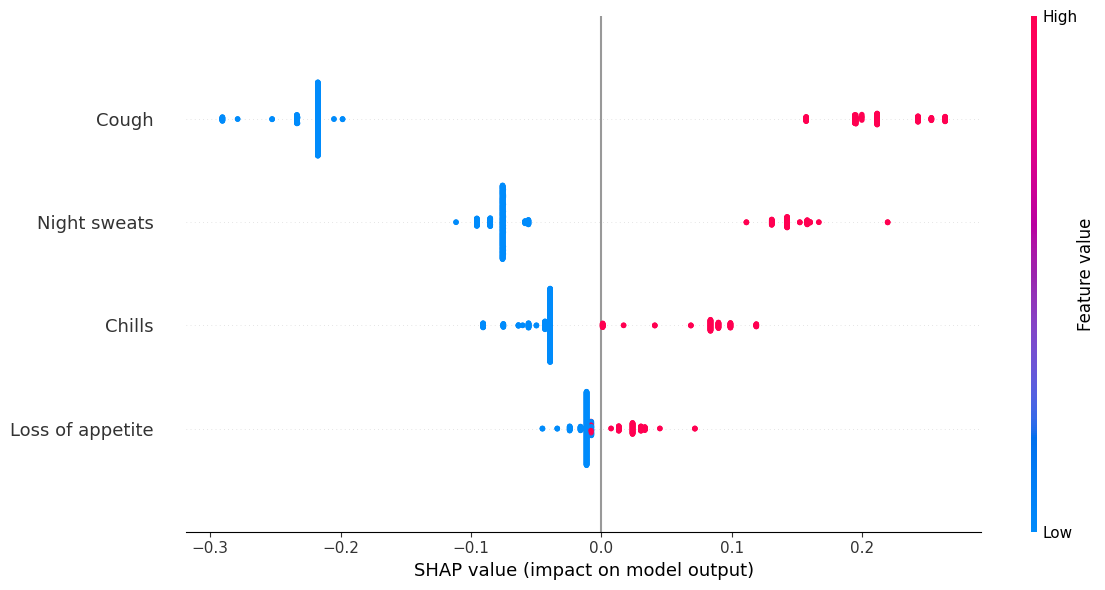

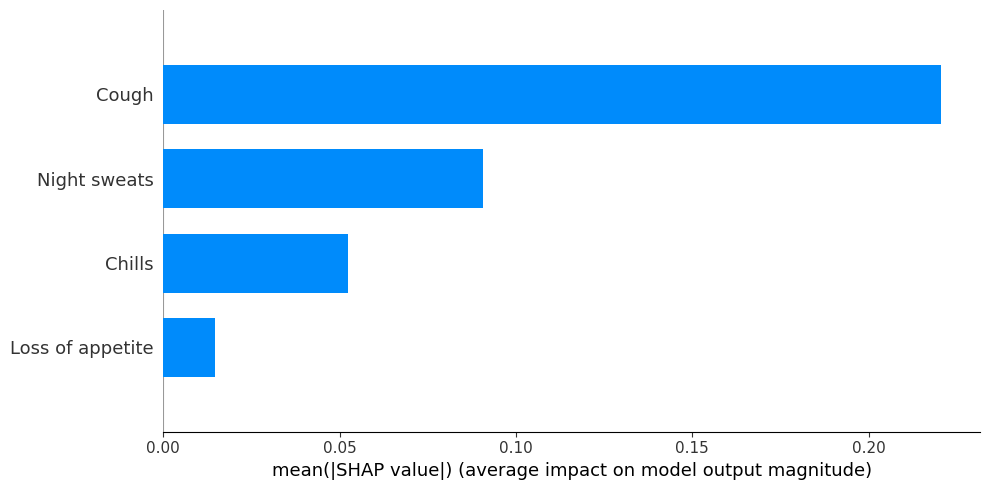

In [22]:
shap_values = explainer.shap_values(X_test_tensor.cpu().numpy())  

mean_abs_shap = np.abs(shap_values[0]).mean(axis=0)
raw_importance = dict(zip(X_test_merged.columns, mean_abs_shap))
sorted_importance = dict(sorted(raw_importance.items(), key=lambda item: item[1], reverse=True))

normalized_contrib = mean_abs_shap / mean_abs_shap.sum()
normalized_importance = dict(zip(X_test_merged.columns, normalized_contrib))
sorted_normalized = dict(sorted(normalized_importance.items(), key=lambda item: item[1], reverse=True))

print("\n Weighted Average SHAP Contribution per Feature:")
for feature, val in sorted_importance.items():
    print(f"{feature}: {val:.4f}")

print("\n Normalized SHAP Feature Contributions (sum to 1):")
for feature, val in sorted_normalized.items():
    print(f"{feature}: {val:.4f}")

shap.summary_plot(
    shap_values[0], 
    X_test_merged.values, 
    feature_names=X_test_merged.columns.tolist(), 
    show=True, 
    plot_size=(12, 6),
    color_bar=True,
    plot_type="dot"  
)

shap.summary_plot(
    shap_values[0], 
    X_test_merged.values, 
    feature_names=X_test_merged.columns.tolist(), 
    plot_type="bar", 
    show=True, 
    plot_size=(10, 5)
)


In [24]:
# now combining symptom and radiology score
class TBClassifier(nn.Module):
    def __init__(self, input_size=4):
        super(TBClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 1)  

        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)
        self.swish = nn.SiLU()
        
    def forward_features(self, x):
        x = self.dropout1(self.swish(self.bn1(self.fc1(x))))
        x = self.dropout2(self.swish(self.bn2(self.fc2(x))))
        x = self.dropout3(self.swish(self.bn3(self.fc3(x))))
        return x  

    def forward(self, x):
        features = self.forward_features(x)
        out = self.fc4(features)  
        return out


In [25]:
class EfficientViT(nn.Module):
    def __init__(self, in_ch=3, num_classes=1):
        super().__init__()
        self.patch  = nn.Sequential(Conv2d_BN(in_ch, 64, 7, 2, 3), nn.ReLU(), Conv2d_BN(64, 128, 3, 2, 1), nn.ReLU())
        self.blocks = nn.Sequential(*[EfficientViTBlock(128) for _ in range(6)])
        self.head   = nn.Linear(128, num_classes)

    def forward_features(self, x):
        x = self.patch(x)
        x = self.blocks(x)
        x = F.adaptive_avg_pool2d(x, 1).flatten(1)
        return x  

    def forward(self, x):
        features = self.forward_features(x)
        out = self.head(features).squeeze(1)
        return out


In [26]:
class DiagnosticScore(nn.Module):
    def __init__(self):
        super(DiagnosticScore, self).__init__()
        self.image_model = EfficientViT()   
        self.symptom_model = TBClassifier() 
        self.fc = nn.Sequential(            
            nn.Linear(64 + 128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
    
    def forward(self, image, symptoms):
        img_feat = self.image_model.forward_features(image)     
        symp_feat = self.symptom_model.forward_features(symptoms) 
        combined = torch.cat([img_feat, symp_feat], dim=1)       
        out = self.fc(combined)                                  
        return out.squeeze(1)  


## Evaluation loop

Epoch 1: 100%|██████████| 23/23 [00:21<00:00,  1.06it/s, loss=0.631]


Epoch [1], Loss: 0.6307


Epoch 2: 100%|██████████| 23/23 [00:20<00:00,  1.10it/s, loss=0.453]


Epoch [2], Loss: 0.4529


Epoch 3: 100%|██████████| 23/23 [00:20<00:00,  1.10it/s, loss=0.333]


Epoch [3], Loss: 0.3327


Epoch 4: 100%|██████████| 23/23 [00:20<00:00,  1.10it/s, loss=0.268]


Epoch [4], Loss: 0.2685


Epoch 5: 100%|██████████| 23/23 [00:21<00:00,  1.09it/s, loss=0.219]


Epoch [5], Loss: 0.2187


Epoch 6: 100%|██████████| 23/23 [00:21<00:00,  1.09it/s, loss=0.201]


Epoch [6], Loss: 0.2015


Epoch 7: 100%|██████████| 23/23 [00:21<00:00,  1.09it/s, loss=0.164]


Epoch [7], Loss: 0.1637


Epoch 8: 100%|██████████| 23/23 [00:21<00:00,  1.09it/s, loss=0.154]


Epoch [8], Loss: 0.1545


Epoch 9: 100%|██████████| 23/23 [00:21<00:00,  1.09it/s, loss=0.154]


Epoch [9], Loss: 0.1540


Epoch 10: 100%|██████████| 23/23 [00:21<00:00,  1.09it/s, loss=0.14] 


Epoch [10], Loss: 0.1401


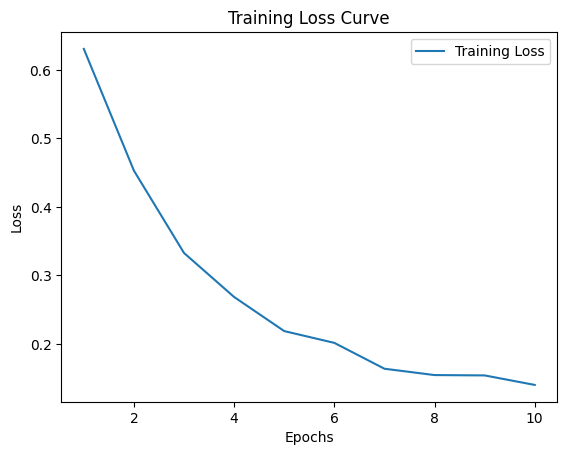


Evaluation Metrics:
Accuracy:  0.9484
Precision: 0.8488
Recall:    0.9799
F1 Score:  0.9097
AUROC:     0.9948

Confusion Matrix:
[[387  26]
 [  3 146]]


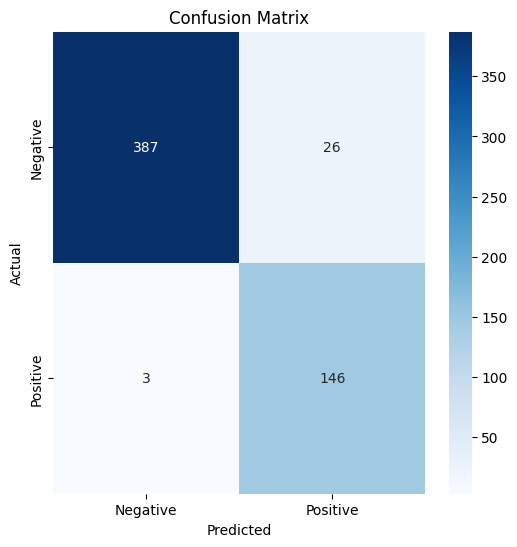

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class CombinedDataset(Dataset):
    def __init__(self, image_dataset, symptom_dataset):
        min_len = min(len(image_dataset), len(symptom_dataset))
        if isinstance(image_dataset, pd.DataFrame):
            self.image_dataset = image_dataset.iloc[:min_len].reset_index(drop=True)
        else:
            self.image_dataset = image_dataset
        self.symptom_dataset = Subset(symptom_dataset, range(min_len))

    def __len__(self):
        return len(self.symptom_dataset)

    def __getitem__(self, idx):
        if isinstance(self.image_dataset, pd.DataFrame):
            image_path = self.image_dataset.iloc[idx, 0]
            image = Image.open(image_path).convert('RGB')
            image = transform(image)
        else:
            image = self.image_dataset[idx]
        symptoms, label = self.symptom_dataset[idx]
        return image, symptoms, label

def train_model(model, train_loader, optimizer, criterion, num_epochs=10):
    model.train()
    train_losses = [] 
    for epoch in range(num_epochs):
        running_loss = 0.0
        loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}")
        for batch_idx, (images, symptoms, labels) in loop:
            images = images.to(device)
            symptoms = symptoms.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, symptoms)
            loss = criterion(outputs, labels.view(-1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            loop.set_postfix(loss=running_loss / (batch_idx + 1))
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}], Loss: {avg_loss:.4f}")
    
    # Plot loss curve
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, symptoms, labels in test_loader:
            images = images.to(device)
            symptoms = symptoms.to(device)
            labels = labels.to(device)
            outputs = model(images, symptoms)
            probs = torch.sigmoid(outputs)
            all_preds.append(probs.cpu())
            all_labels.append(labels.view(-1).cpu())
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    accuracy = accuracy_score(all_labels, all_preds > 0.5)
    precision = precision_score(all_labels, all_preds > 0.5)
    recall = recall_score(all_labels, all_preds > 0.5)
    f1 = f1_score(all_labels, all_preds > 0.5)
    auroc = roc_auc_score(all_labels, all_preds)

    print("\nEvaluation Metrics:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUROC:     {auroc:.4f}")
    cm = confusion_matrix(all_labels, all_preds > 0.5)
    print(f"\nConfusion Matrix:\n{cm}")

    
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def main(train_df, test_df, train_dataset, test_dataset, num_epochs=10):
    train_data = CombinedDataset(train_df, train_dataset)
    test_data = CombinedDataset(test_df, test_dataset)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    model = DiagnosticScore().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()
    train_model(model, train_loader, optimizer, criterion, num_epochs=num_epochs)
    evaluate_model(model, test_loader)

main(train_df, test_df, train_dataset, test_dataset)
